In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
from scipy.stats import invwishart
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.collections import PolyCollection
import math
import seaborn as sns

In [3]:
np.random.seed(47)

# Hierarchical model with covariates

In [4]:
s2 = pd.read_table("Scores_with_covariates", sep = ' ')
s2

sch_id  sch_freelunch   stu_ses  stu_mathscore
0       1011              6 -0.059948          52.11
1       1011              6  1.051652          57.65
2       1011              6 -0.863515          66.44
3       1011              6 -0.796551          44.68
4       1011              6 -1.613511          40.57
...      ...            ...       ...            ...
1988    3702              8  0.234693          54.95
1989    3702              8 -0.823337          30.29
1990    3702              8  0.890939          47.66
1991    3702              8 -0.421553          55.43
1992    3702              8  0.154336          29.73

[1993 rows x 4 columns]

In [323]:
 np.corrcoef(s2['sch_freelunch'], s2['stu_ses'])

array([[ 1.        , -0.19213334],
       [-0.19213334,  1.        ]])

In [5]:
unique_sid = s2['sch_id'].unique()
len(unique_sid)

100

In [7]:
def OLS(Y, X):
    
    n = np.shape(X)[0]
    p = np.shape(X)[1]-1
    beta_hat = np.linalg.multi_dot([np.linalg.inv(np.dot(X.T, X)), X.T, Y])
    
    residual = Y - np.dot(X, beta_hat)  
    sigma2_hat = sum(residual ** 2) / (n - p - 1)
    
    return beta_hat, sigma2_hat

In [8]:
#within school we do not consider sch_freelunch as the number is the same for all the students in the same school. 
m = len(unique_sid) #number of schools
B_ols = np.zeros((m, 2))
sigma2_ols = np.zeros(m)  
for j, sch_id in enumerate(unique_sid):
    Y = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
    X = np.array(s2[s2['sch_id'] == sch_id]['stu_ses'])
    n = Y.shape[0]
    Y = Y.reshape((n, 1))
    X = np.hstack((np.ones((n,1)), X.reshape((n, 1))))
    beta_hat, sigma2_hat = OLS(Y,X)
    B_ols[j] = beta_hat.reshape((2,))
    sigma2_ols[j] = sigma2_hat

In [9]:
def posterior_with_covariates_batch_it(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size):
    
    n = np.shape(X)[0] #number of observations
    p = np.shape(X)[1]-1 #number of covariates, without the intercept
    eta0 = p + 2
    m = len(unique_sid)
    L0_inv = np.linalg.inv(L0)
    S0 = L0
    S0_inv = L0_inv
    a = (v0+n)/2

    #initial values
    theta = np.random.multivariate_normal(mean = mu0.reshape((p+1),), cov = L0).reshape((p+1), 1)
    Sigma = invwishart.rvs(eta0, S0)
    sigma2 = 1/np.random.gamma(shape = v0/2, scale = 1/(v0*sigma2_0/2), size = 1)
#     betas = np.random.multivariate_normal(mean = theta, cov = Sigma).reshape((p+1), 1)
    
    #BurnIn
    Beta = np.zeros((m, p+1))
    for i in range(burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = (1/np.random.gamma(shape = a, scale = b, size = 1))
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
    
    #Actual iterations
    Beta = np.zeros((m, p+1))
    Beta_store = np.zeros((it_after_burnin//batch_size, m, p+1))
    theta_store = np.zeros((it_after_burnin//batch_size, p+1))
    Sigma_store = np.zeros((it_after_burnin//batch_size, p+1, p+1))
    sigma2_store = np.zeros((it_after_burnin//batch_size))
    for i in range(it_after_burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = 1/np.random.gamma(shape = a, scale = b, size = 1)
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
        
        #save the data
        if i%batch_size == 0:
            for j in range (m):
                Beta_store[i//batch_size,j] = Beta[j]
            sigma2_store[i//batch_size] = sigma2
            theta_store[i//batch_size] = theta.reshape((3,))
            Sigma_store[i//batch_size] = Sigma
        
    
    return Beta_store, sigma2_store, theta_store, Sigma_store   

In [10]:
Y = np.array(s2['stu_mathscore'])[:,np.newaxis]
X = np.array(s2[['stu_ses', 'sch_freelunch']])
X = np.hstack((np.ones((len(s2),1)), X.reshape((len(s2), 2))))
#adding a 0 for the coefficient of sch_freelunch to the B_ols
B_ols = np.hstack((B_ols, np.zeros((m, 1))))
mu0 = np.mean(B_ols, axis = 0).reshape((3, 1))
sigma2_0 = np.mean(sigma2_ols, axis = 0)

In [11]:
L0 = 300*sigma2_0*np.linalg.inv(np.dot(X.T, X))
v0 = 1
burnin = 10000
it_after_burnin = 10000
batch_size = 10
Beta, sigma2, theta, Sigma = posterior_with_covariates_batch_it(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size)

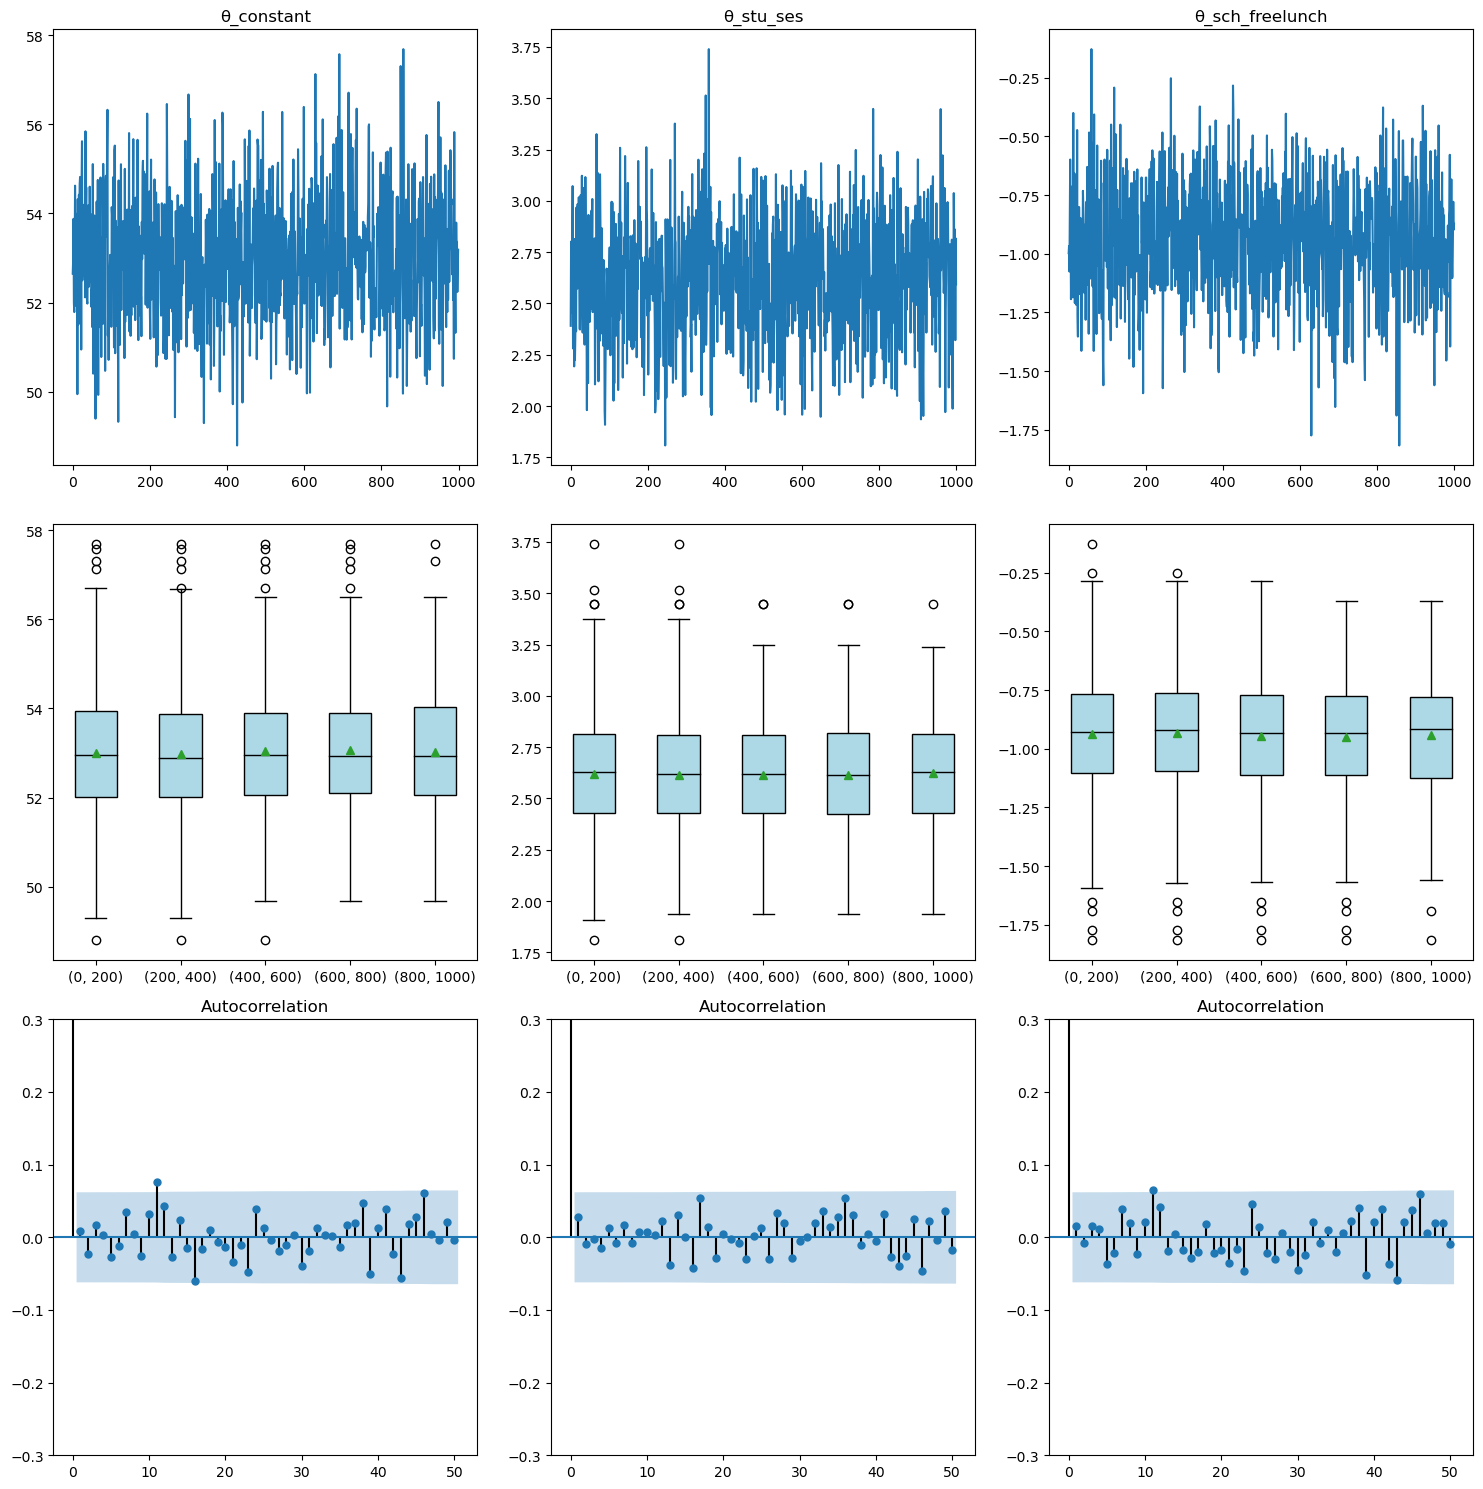

In [134]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(theta[:,0])
ax[0,1].plot(theta[:,1])
ax[0,2].plot(theta[:,2])
ax[0,0].title.set_text('θ_constant')
ax[0,1].title.set_text('θ_stu_ses')
ax[0,2].title.set_text('θ_sch_freelunch')
ax[1,0].boxplot(np.array([theta[k:, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([theta[k:, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([theta[k:, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)], 
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black"))
plot_acf(theta[:,0], lags = 50, ax = ax[2,0])
plot_acf(theta[:,1], lags = 50, ax = ax[2,1])
plot_acf(theta[:,2], lags = 50, ax = ax[2,2])
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
fig.tight_layout()
fig.savefig('TPACB-Theta0.pdf')

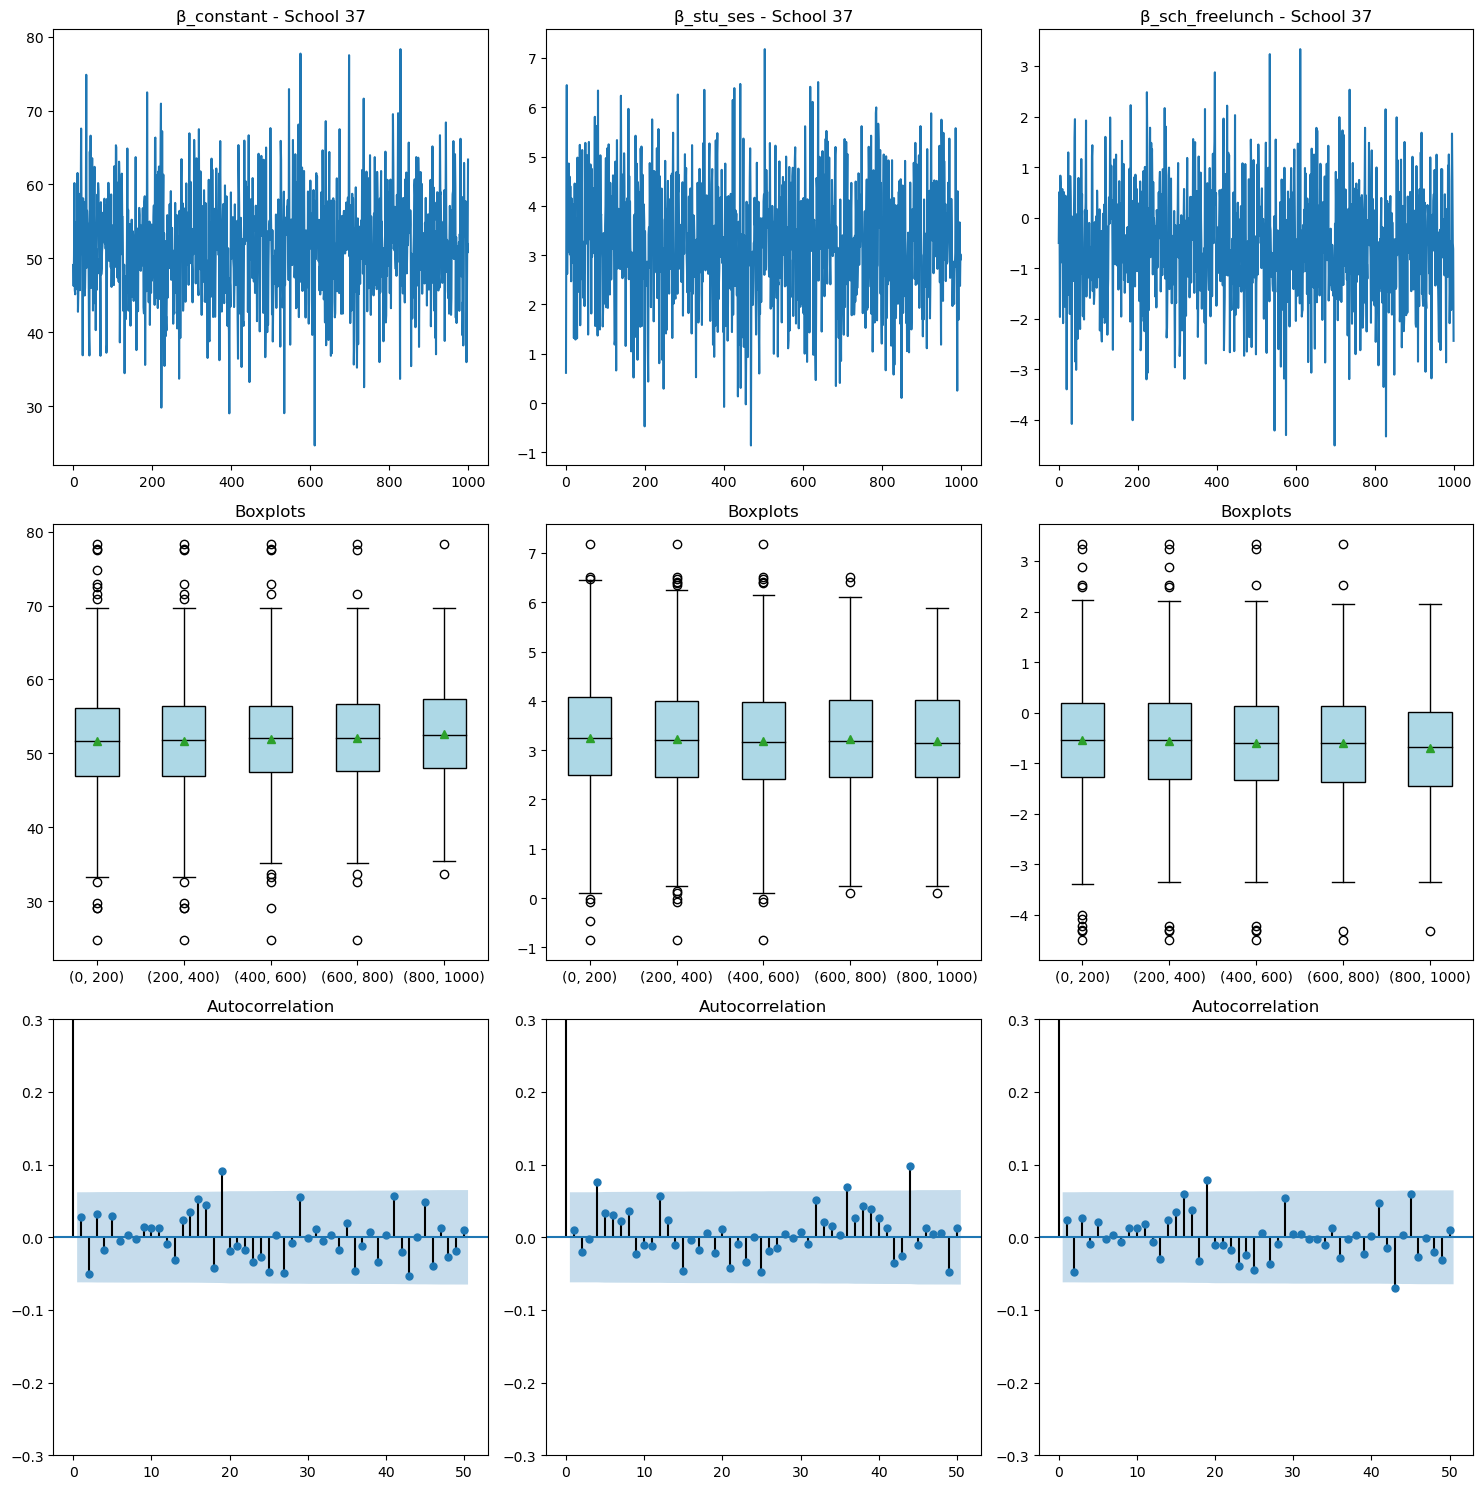

In [450]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta[:,36,0])
ax[0,1].plot(Beta[:,36,1])
ax[0,2].plot(Beta[:,36,2])
ax[1,0].boxplot(np.array([Beta[k:,36, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta[k:,36, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta[k:,36, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black"))
plot_acf(Beta[:,36,0], lags = 50, ax = ax[2,0])
plot_acf(Beta[:,36,1], lags = 50, ax = ax[2,1])
plot_acf(Beta[:,36,2], lags = 50, ax = ax[2,2])
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[0,0].title.set_text('β_constant - School 37')
ax[0,1].title.set_text('β_stu_ses - School 37')
ax[0,2].title.set_text('β_sch_freelunch - School 37')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')

fig.tight_layout()
fig.savefig('TPACB-Beta0_36.pdf')

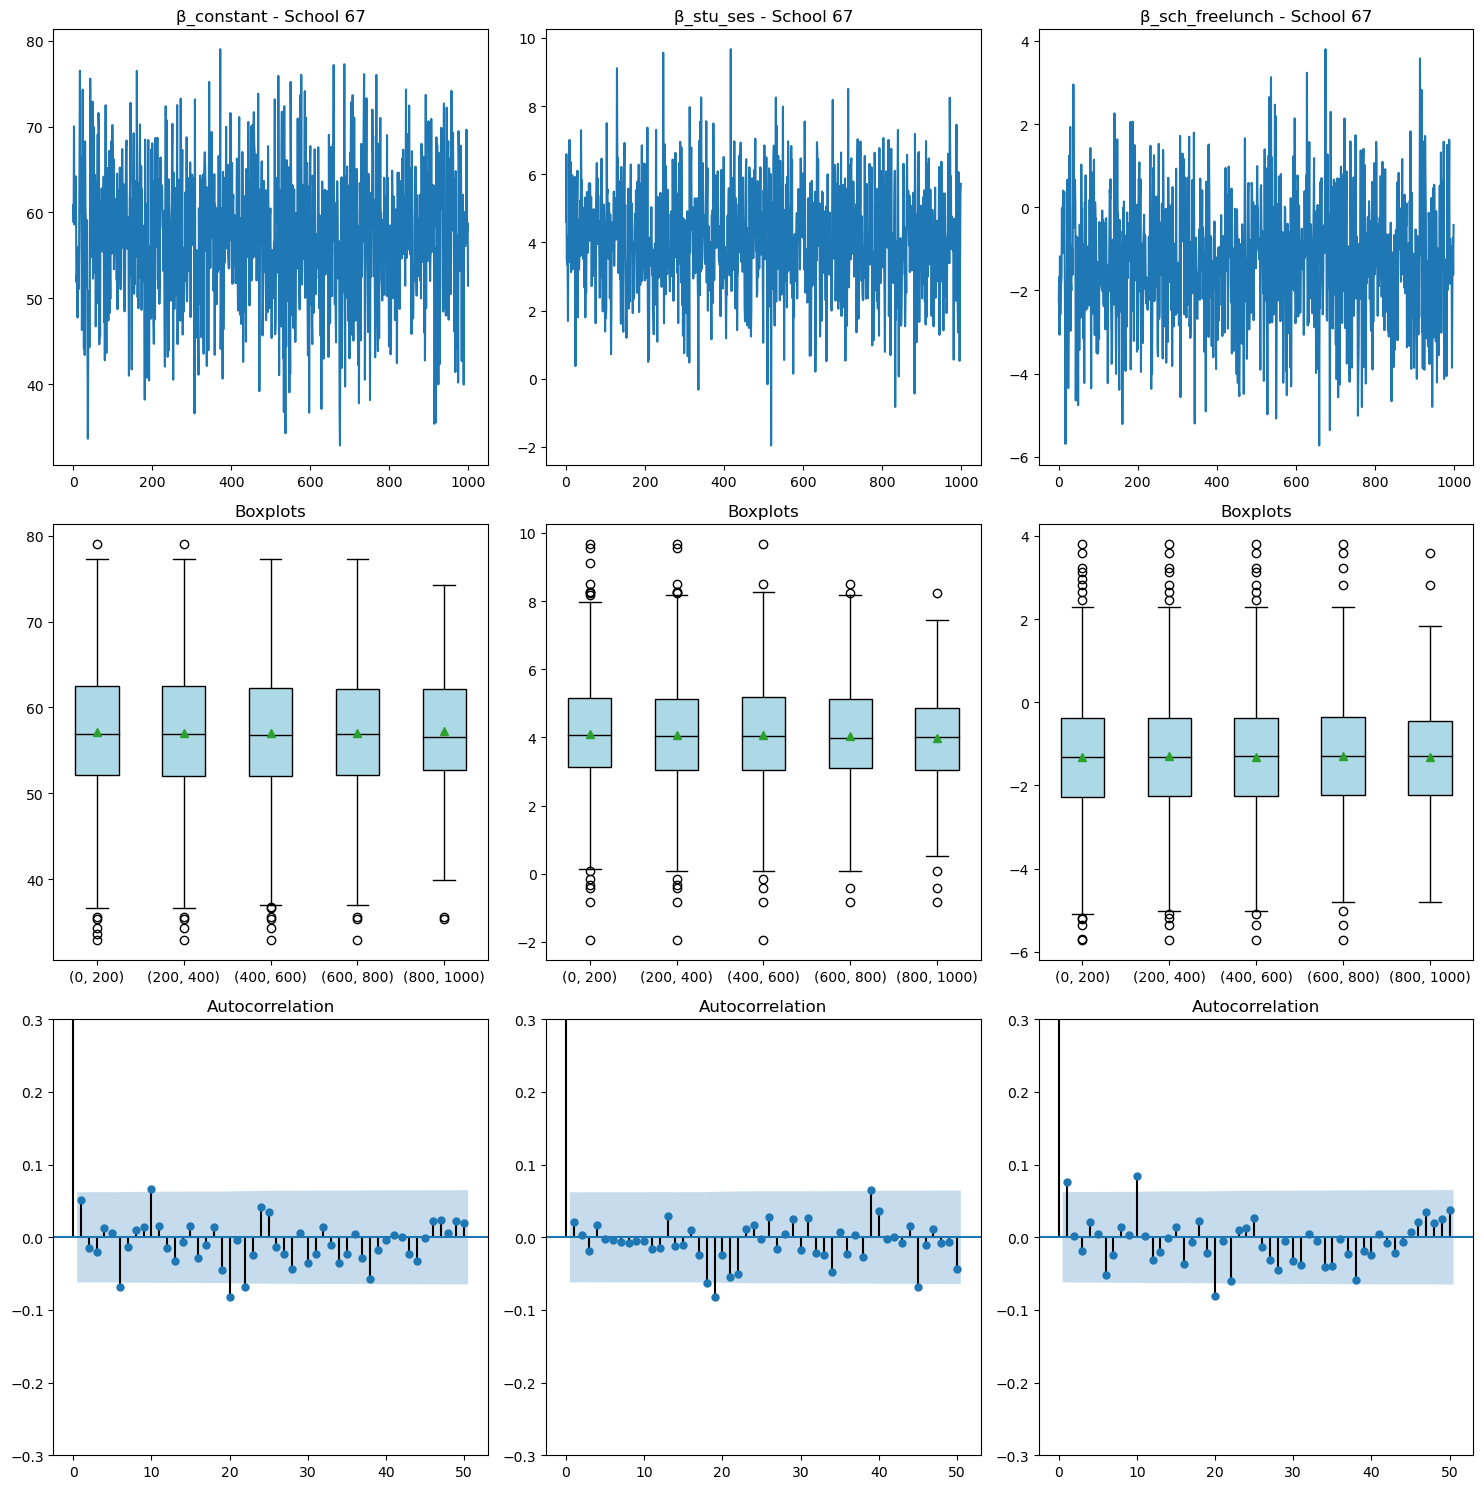

In [451]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta[:,66,0])
ax[0,1].plot(Beta[:,66,1])
ax[0,2].plot(Beta[:,66,2])
ax[1,0].boxplot(np.array([Beta[k:,66, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta[k:,66, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta[k:,66, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black"))
plot_acf(Beta[:,66,0], lags = 50, ax = ax[2,0])
plot_acf(Beta[:,66,1], lags = 50, ax = ax[2,1])
plot_acf(Beta[:,66,2], lags = 50, ax = ax[2,2])
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[0,0].title.set_text('β_constant - School 67')
ax[0,1].title.set_text('β_stu_ses - School 67')
ax[0,2].title.set_text('β_sch_freelunch - School 67')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
fig.tight_layout()
fig.savefig('TPACB-Beta0_66.pdf')

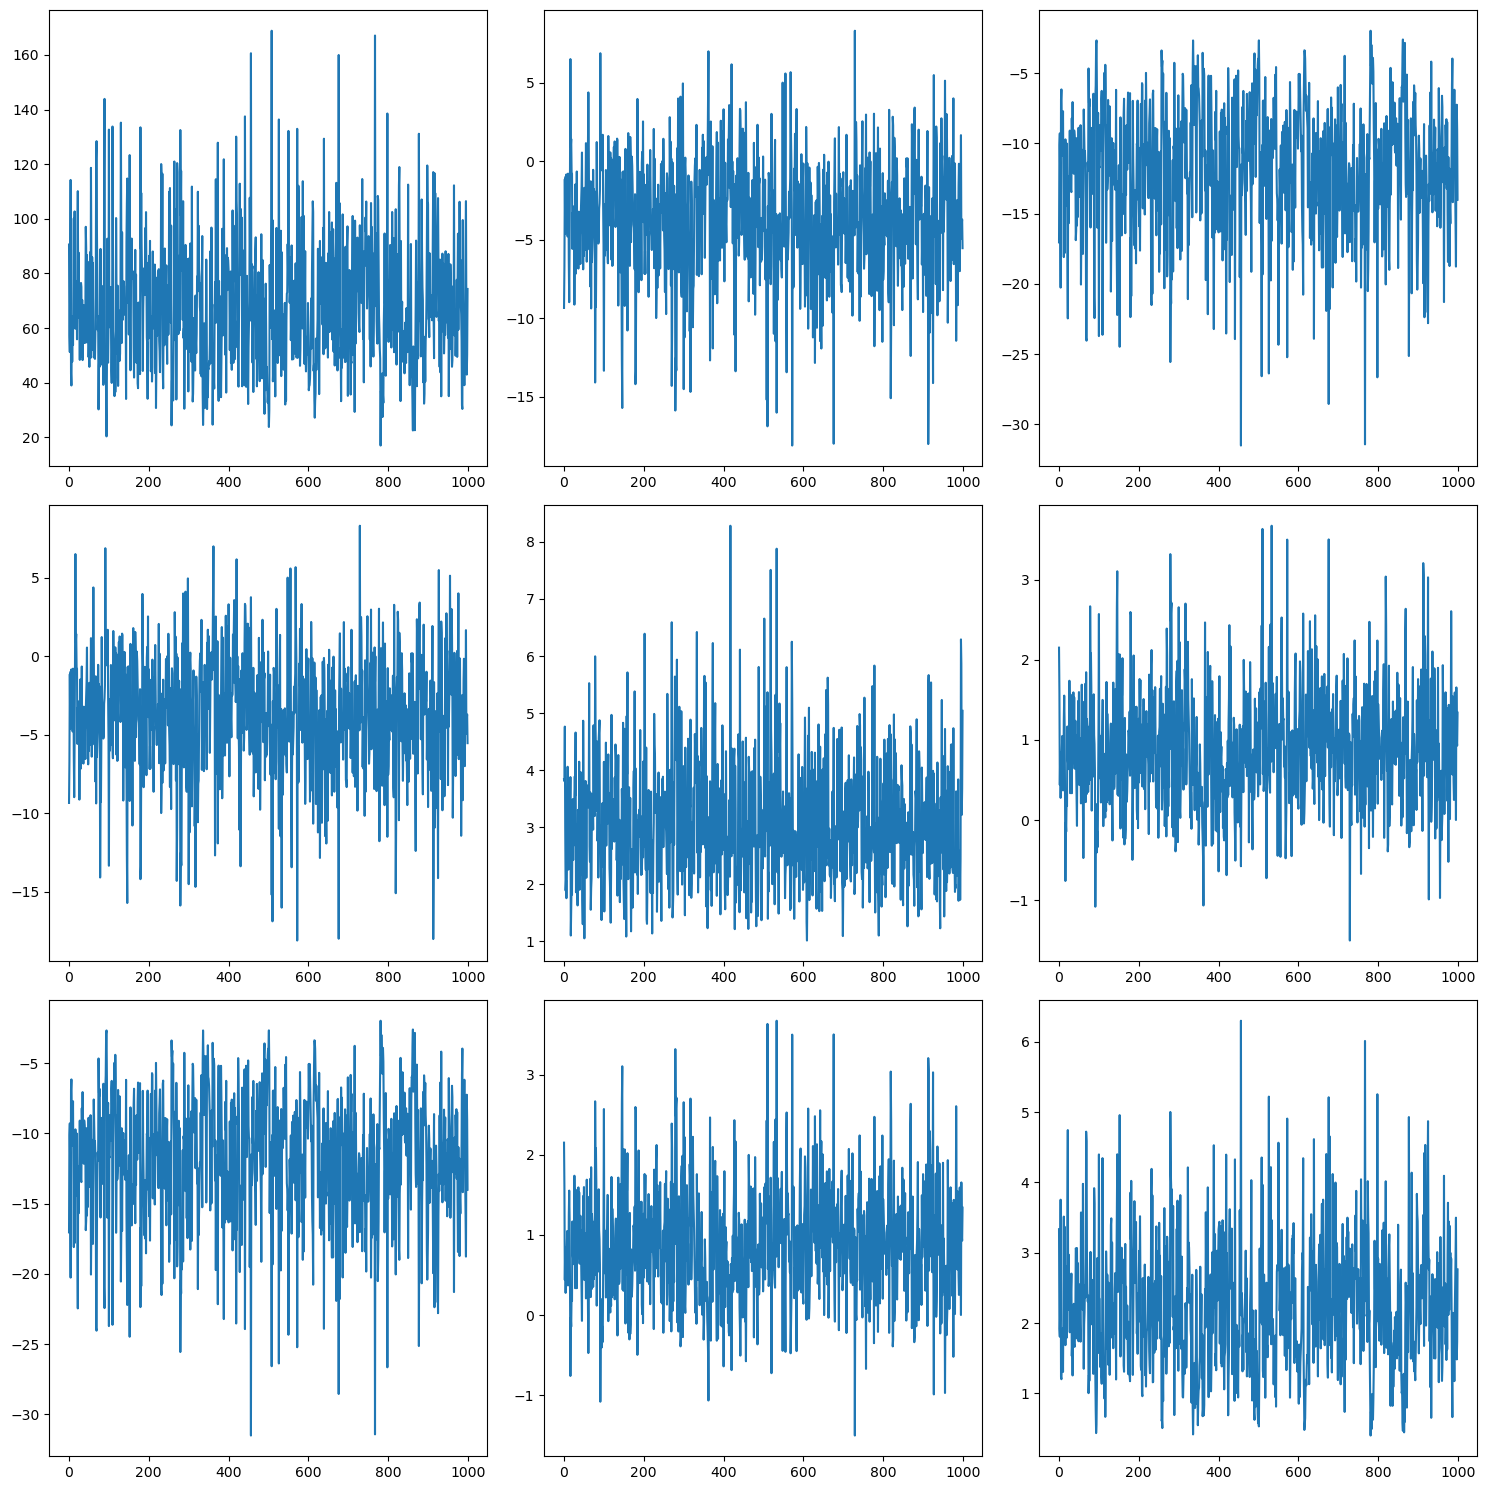

In [15]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Sigma[:,0,0])
ax[0,1].plot(Sigma[:,0,1])
ax[0,2].plot(Sigma[:,0,2])
ax[1,0].plot(Sigma[:,1,0])
ax[1,1].plot(Sigma[:,1,1])
ax[1,2].plot(Sigma[:,1,2])
ax[2,0].plot(Sigma[:,2,0])
ax[2,1].plot(Sigma[:,2,1])
ax[2,2].plot(Sigma[:,2,2])
fig.tight_layout()

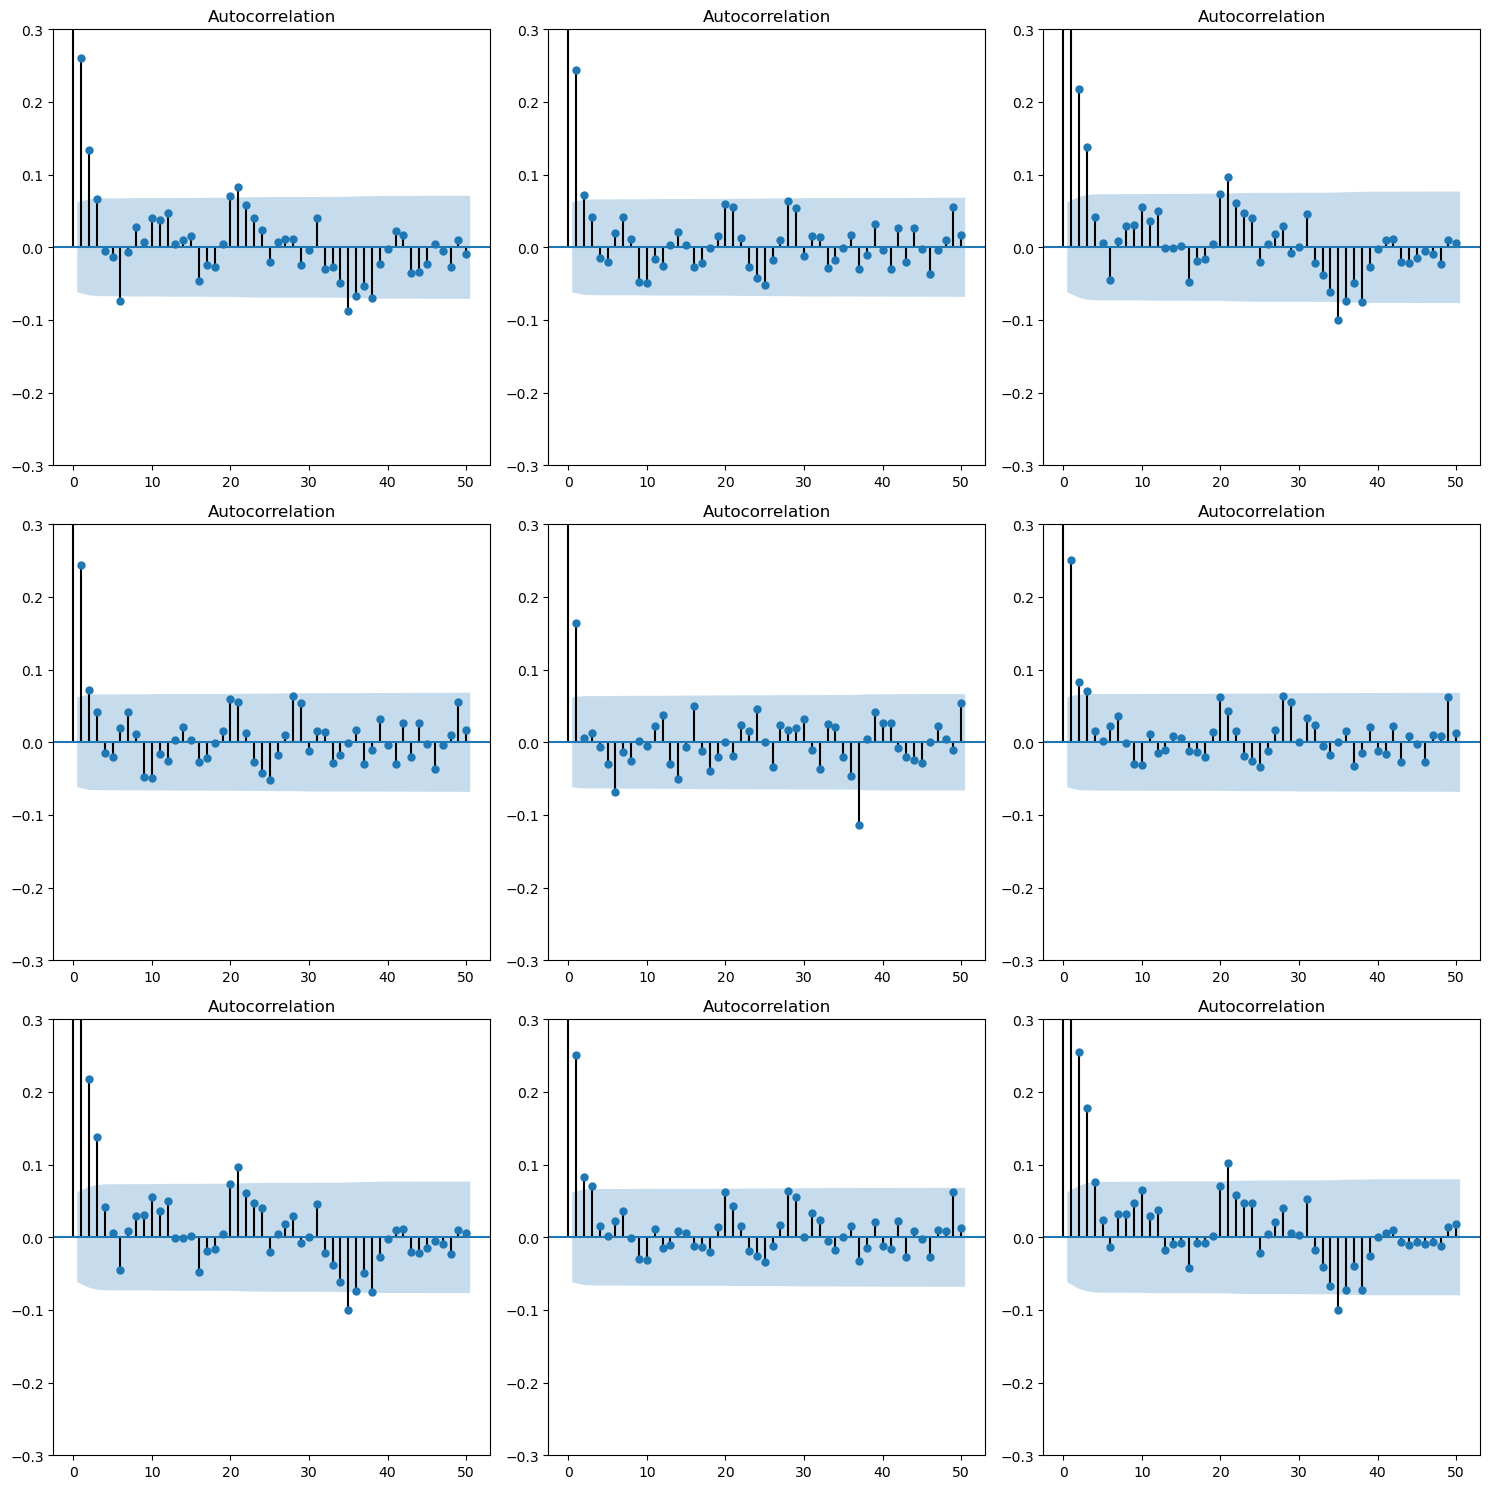

In [49]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
plot_acf(Sigma[:,0,0], lags = 50, ax = ax[0,0])
plot_acf(Sigma[:,0,1], lags = 50, ax = ax[0,1])
plot_acf(Sigma[:,0,2], lags = 50, ax = ax[0,2])
plot_acf(Sigma[:,1,0], lags = 50, ax = ax[1,0])
plot_acf(Sigma[:,1,1], lags = 50, ax = ax[1,1])
plot_acf(Sigma[:,1,2], lags = 50, ax = ax[1,2])
plot_acf(Sigma[:,2,0], lags = 50, ax = ax[2,0])
plot_acf(Sigma[:,2,1], lags = 50, ax = ax[2,1])
plot_acf(Sigma[:,2,2], lags = 50, ax = ax[2,2])
ax[0,0].set_ylim([-0.3, 0.3])
ax[0,1].set_ylim([-0.3, 0.3])
ax[0,2].set_ylim([-0.3, 0.3])
ax[1,0].set_ylim([-0.3, 0.3])
ax[1,1].set_ylim([-0.3, 0.3])
ax[1,2].set_ylim([-0.3, 0.3])
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
fig.tight_layout()

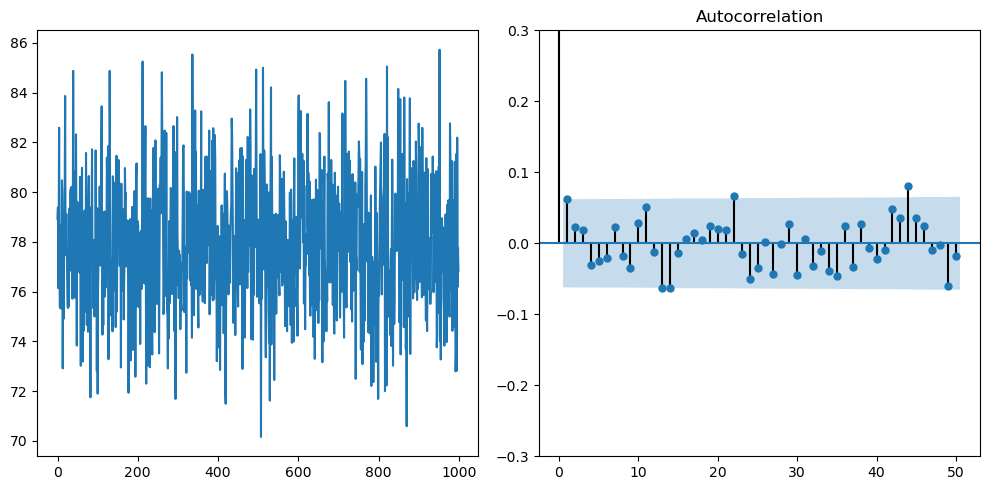

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(sigma2)
plot_acf(sigma2, lags = 50, ax = ax[1])
ax[1].set_ylim([-0.3, 0.3])
fig.tight_layout()

In [18]:
L0 = 1993*sigma2_0*np.linalg.inv(np.dot(X.T, X))
v0 = 1
burnin = 10000
it_after_burnin = 10000
batch_size = 10
Beta_1, sigma2_1, theta_1, Sigma_1 = posterior_with_covariates_batch_it(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size)

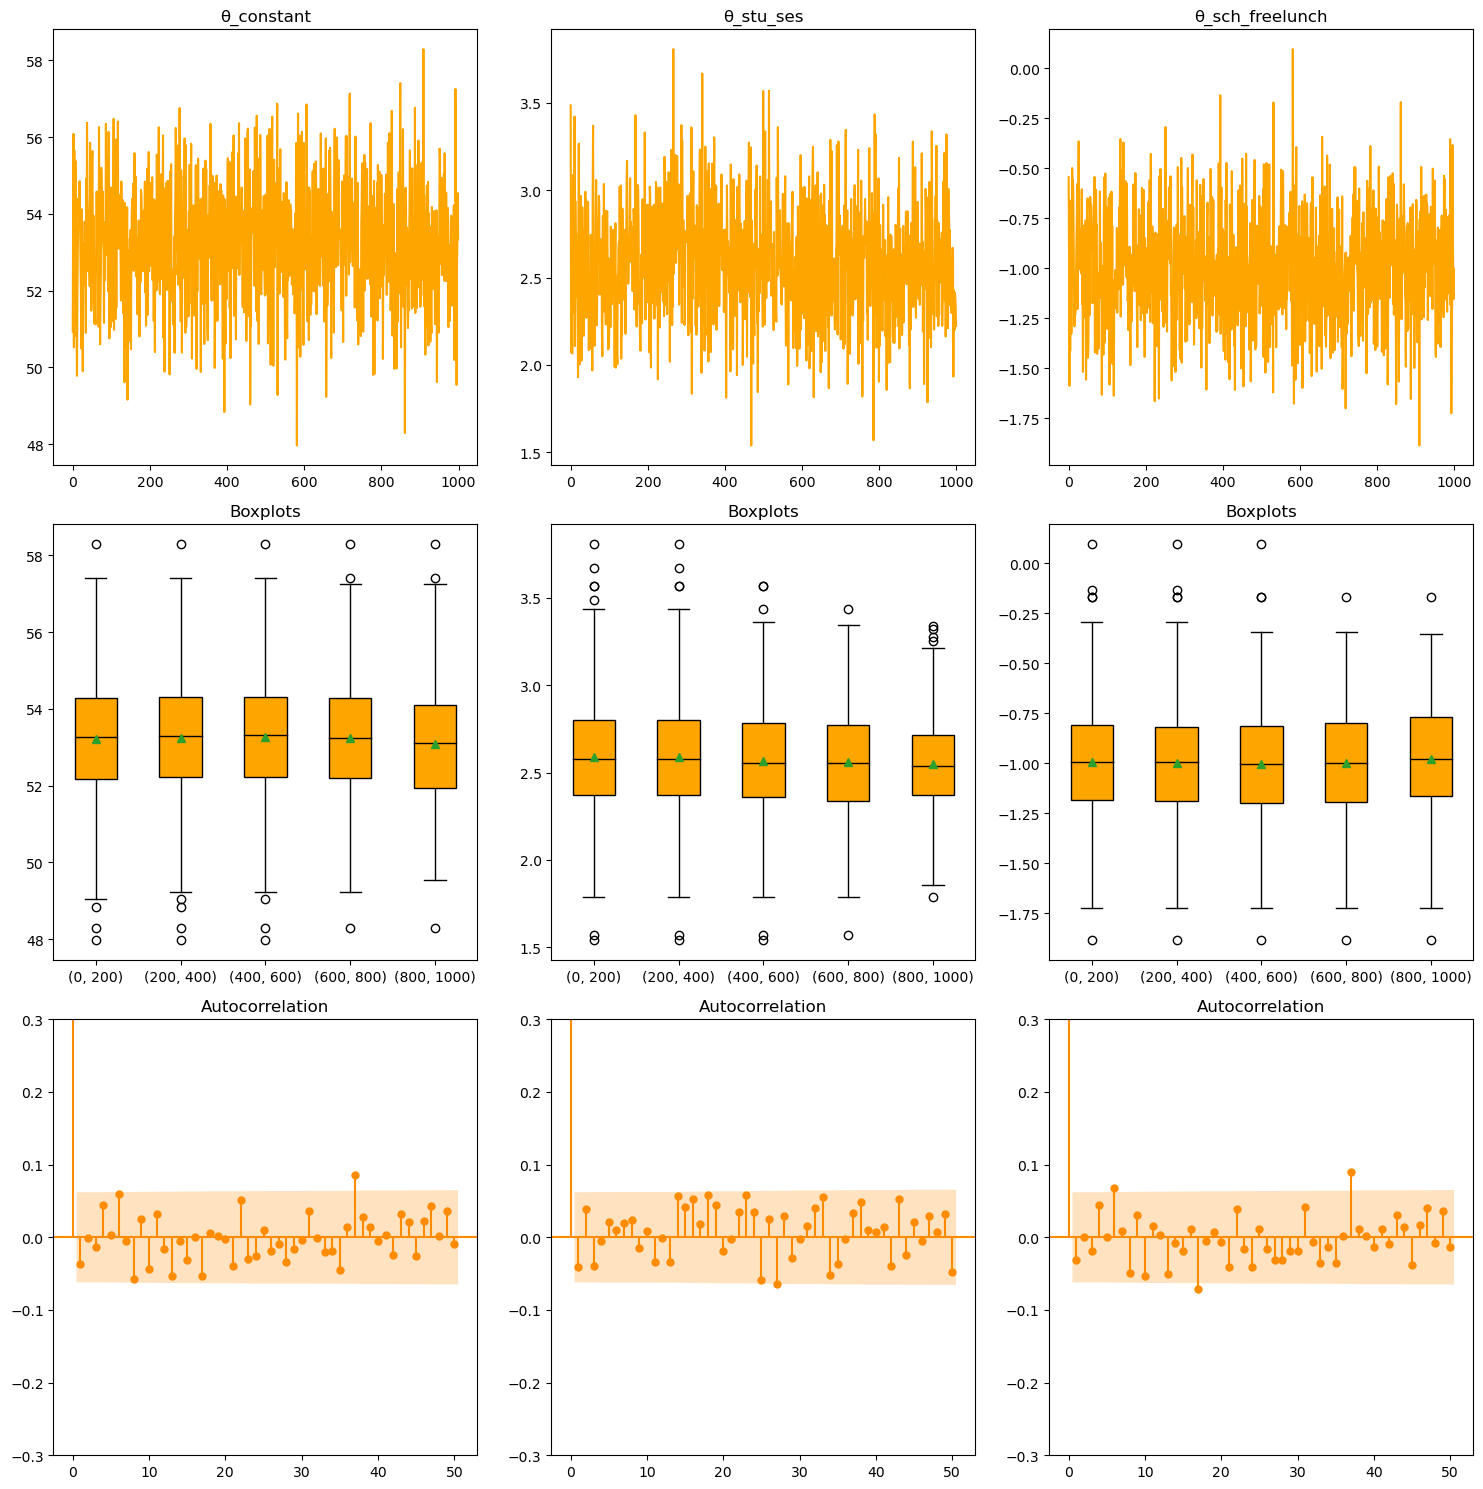

In [163]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(theta_1[:,0], 'orange')
ax[0,1].plot(theta_1[:,1], 'orange')
ax[0,2].plot(theta_1[:,2], 'orange')
ax[0,0].title.set_text('θ_constant')
ax[0,1].title.set_text('θ_stu_ses')
ax[0,2].title.set_text('θ_sch_freelunch')
ax[1,0].boxplot(np.array([theta_1[k:, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([theta_1[k:, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([theta_1[k:, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black"))
plot_acf(theta_1[:,0], lags = 50, ax = ax[2,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(theta_1[:,1], lags = 50, ax = ax[2,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(theta_1[:,2], lags = 50, ax = ax[2,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
fig.tight_layout()
fig.savefig('TPACB-Theta1.pdf')

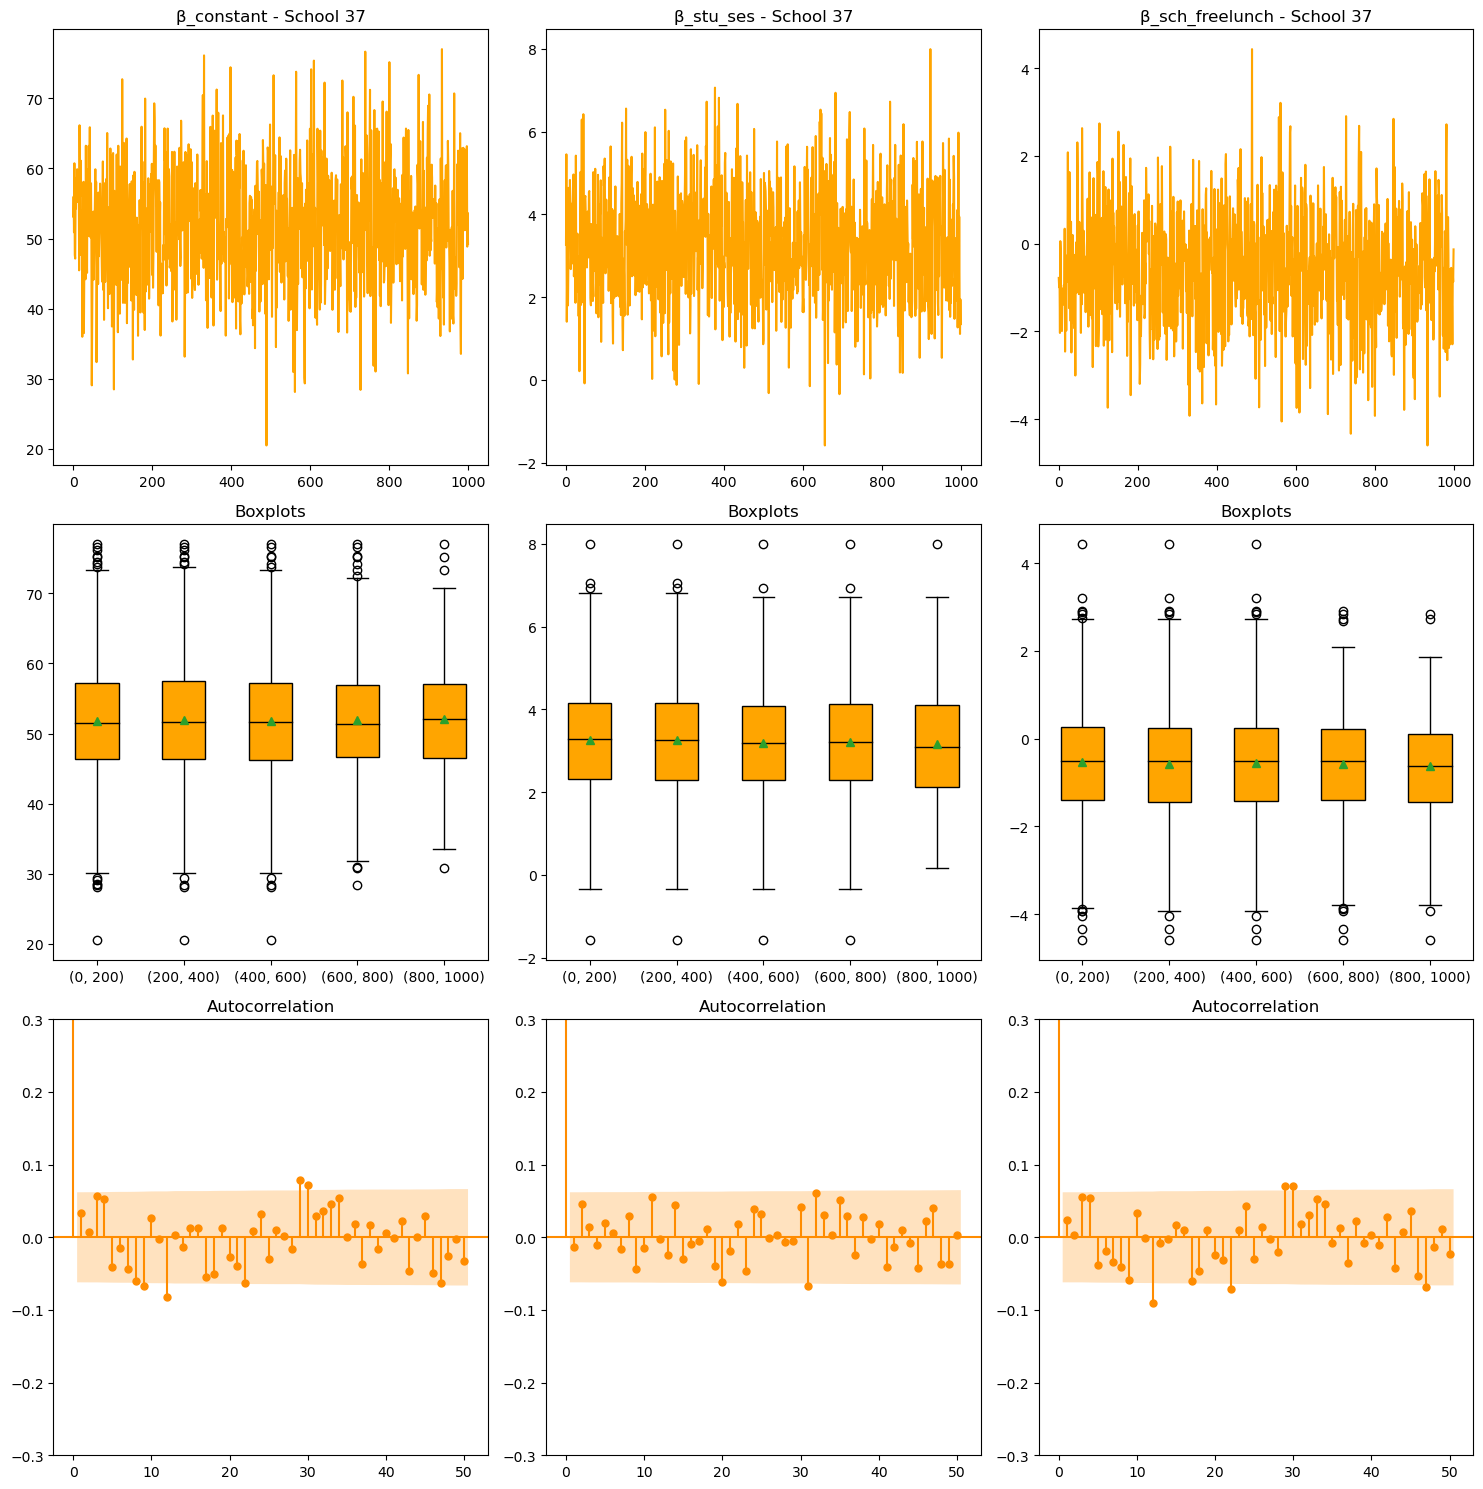

In [452]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_1[:,36,0], color = 'orange')
ax[0,1].plot(Beta_1[:,36,1], color = 'orange')
ax[0,2].plot(Beta_1[:,36,2], color = 'orange')
plot_acf(Beta_1[:,36,0], lags = 50, ax = ax[2,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Beta_1[:,36,1], lags = 50, ax = ax[2,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Beta_1[:,36,2], lags = 50, ax = ax[2,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ax[1,0].boxplot(np.array([Beta_1[k:,36, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_1[k:,36, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_1[k:,36, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black"))
ax[0,0].title.set_text('β_constant - School 37')
ax[0,1].title.set_text('β_stu_ses - School 37')
ax[0,2].title.set_text('β_sch_freelunch - School 37')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
fig.tight_layout()
fig.savefig('TPACB-Beta1_36.pdf')

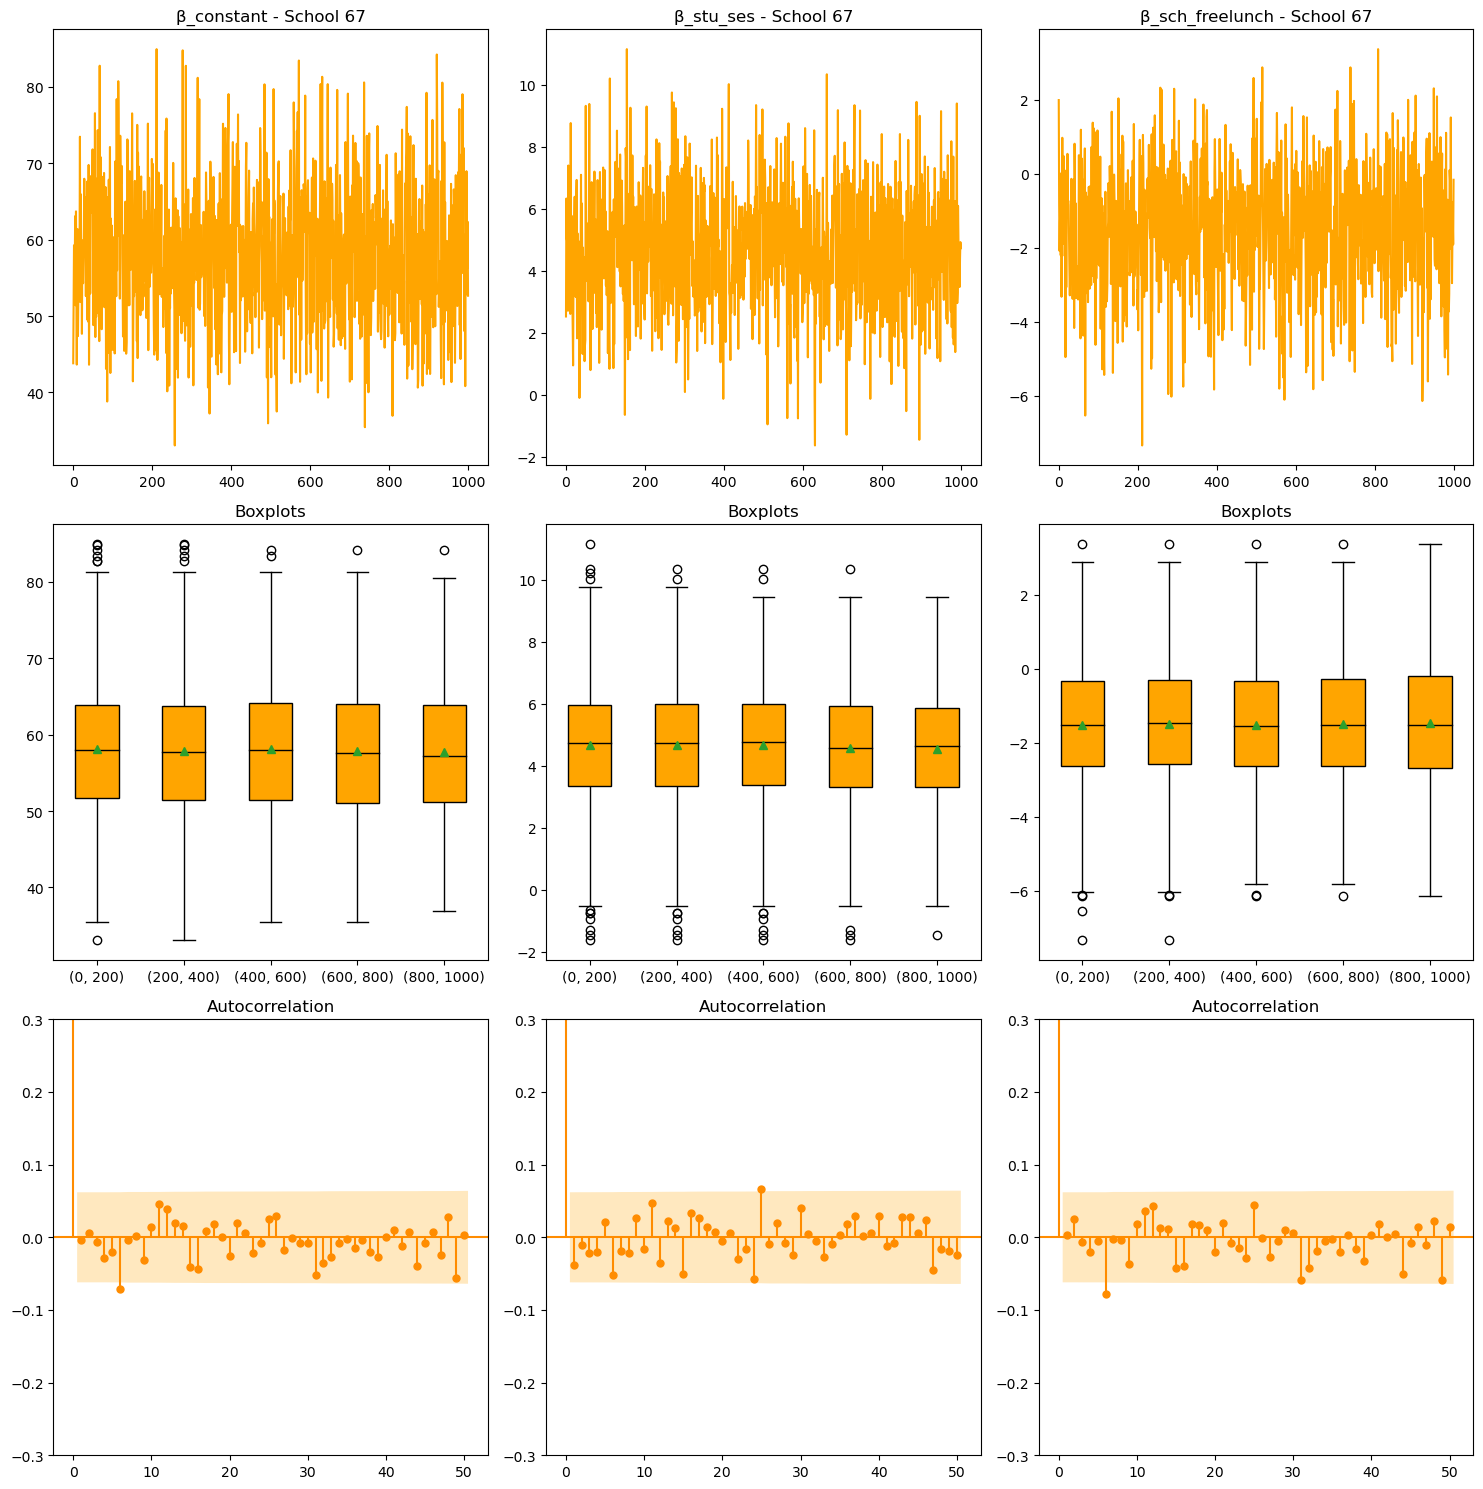

In [453]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_1[:,66,0], color = 'orange')
ax[0,1].plot(Beta_1[:,66,1], color = 'orange')
ax[0,2].plot(Beta_1[:,66,2], color = 'orange')
ax[1,0].boxplot(np.array([Beta_1[k:,66, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_1[k:,66, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_1[k:,66, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black"))
plot_acf(Beta_1[:,66,0], lags = 50, ax = ax[2,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Beta_1[:,66,1], lags = 50, ax = ax[2,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Beta_1[:,66,2], lags = 50, ax = ax[2,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ax[0,0].title.set_text('β_constant - School 67')
ax[0,1].title.set_text('β_stu_ses - School 67')
ax[0,2].title.set_text('β_sch_freelunch - School 67')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
fig.tight_layout()
fig.savefig('TPACB-Beta1_66.pdf')

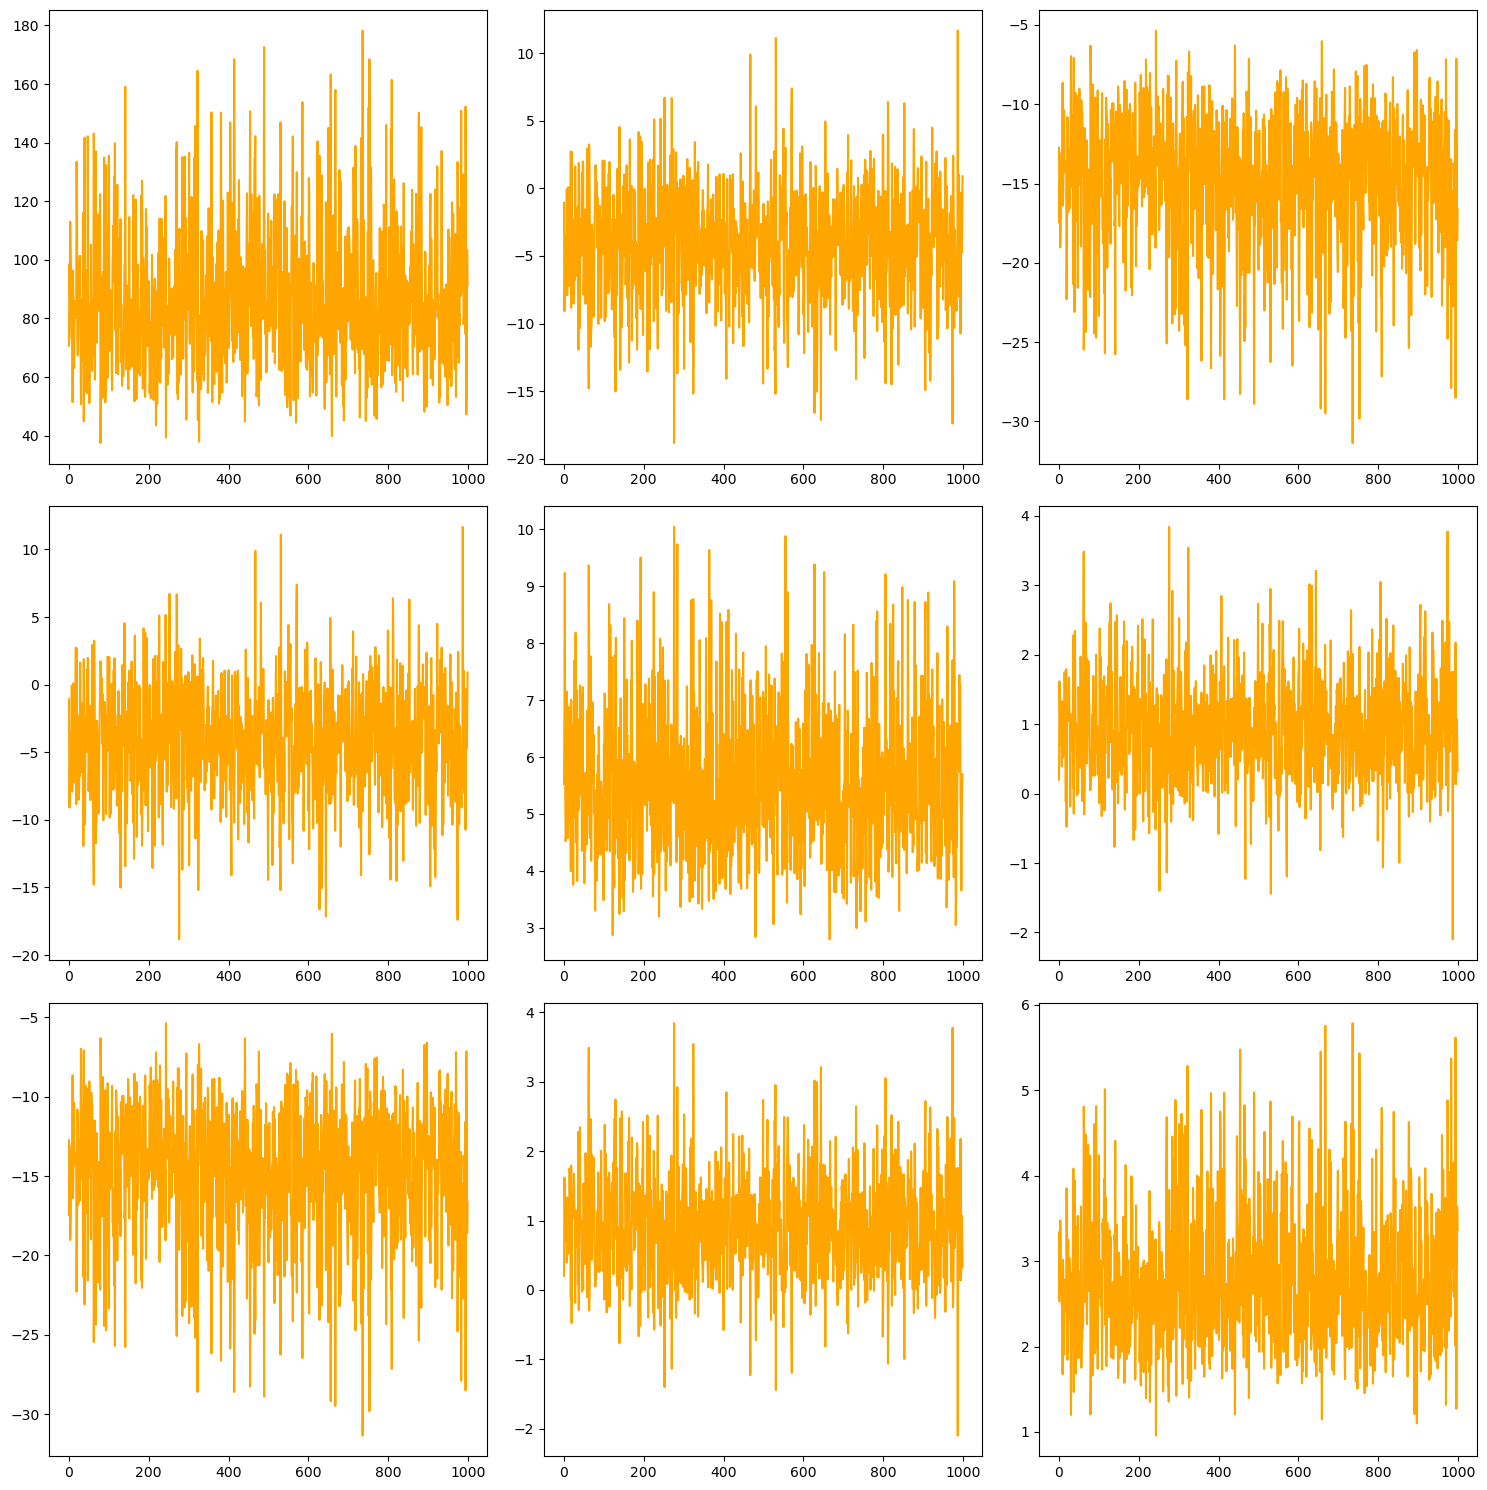

In [78]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Sigma_1[:,0,0], color = 'orange')
ax[0,1].plot(Sigma_1[:,0,1], color = 'orange')
ax[0,2].plot(Sigma_1[:,0,2], color = 'orange')
ax[1,0].plot(Sigma_1[:,1,0], color = 'orange')
ax[1,1].plot(Sigma_1[:,1,1], color = 'orange')
ax[1,2].plot(Sigma_1[:,1,2], color = 'orange')
ax[2,0].plot(Sigma_1[:,2,0], color = 'orange')
ax[2,1].plot(Sigma_1[:,2,1], color = 'orange')
ax[2,2].plot(Sigma_1[:,2,2], color = 'orange')
fig.tight_layout()

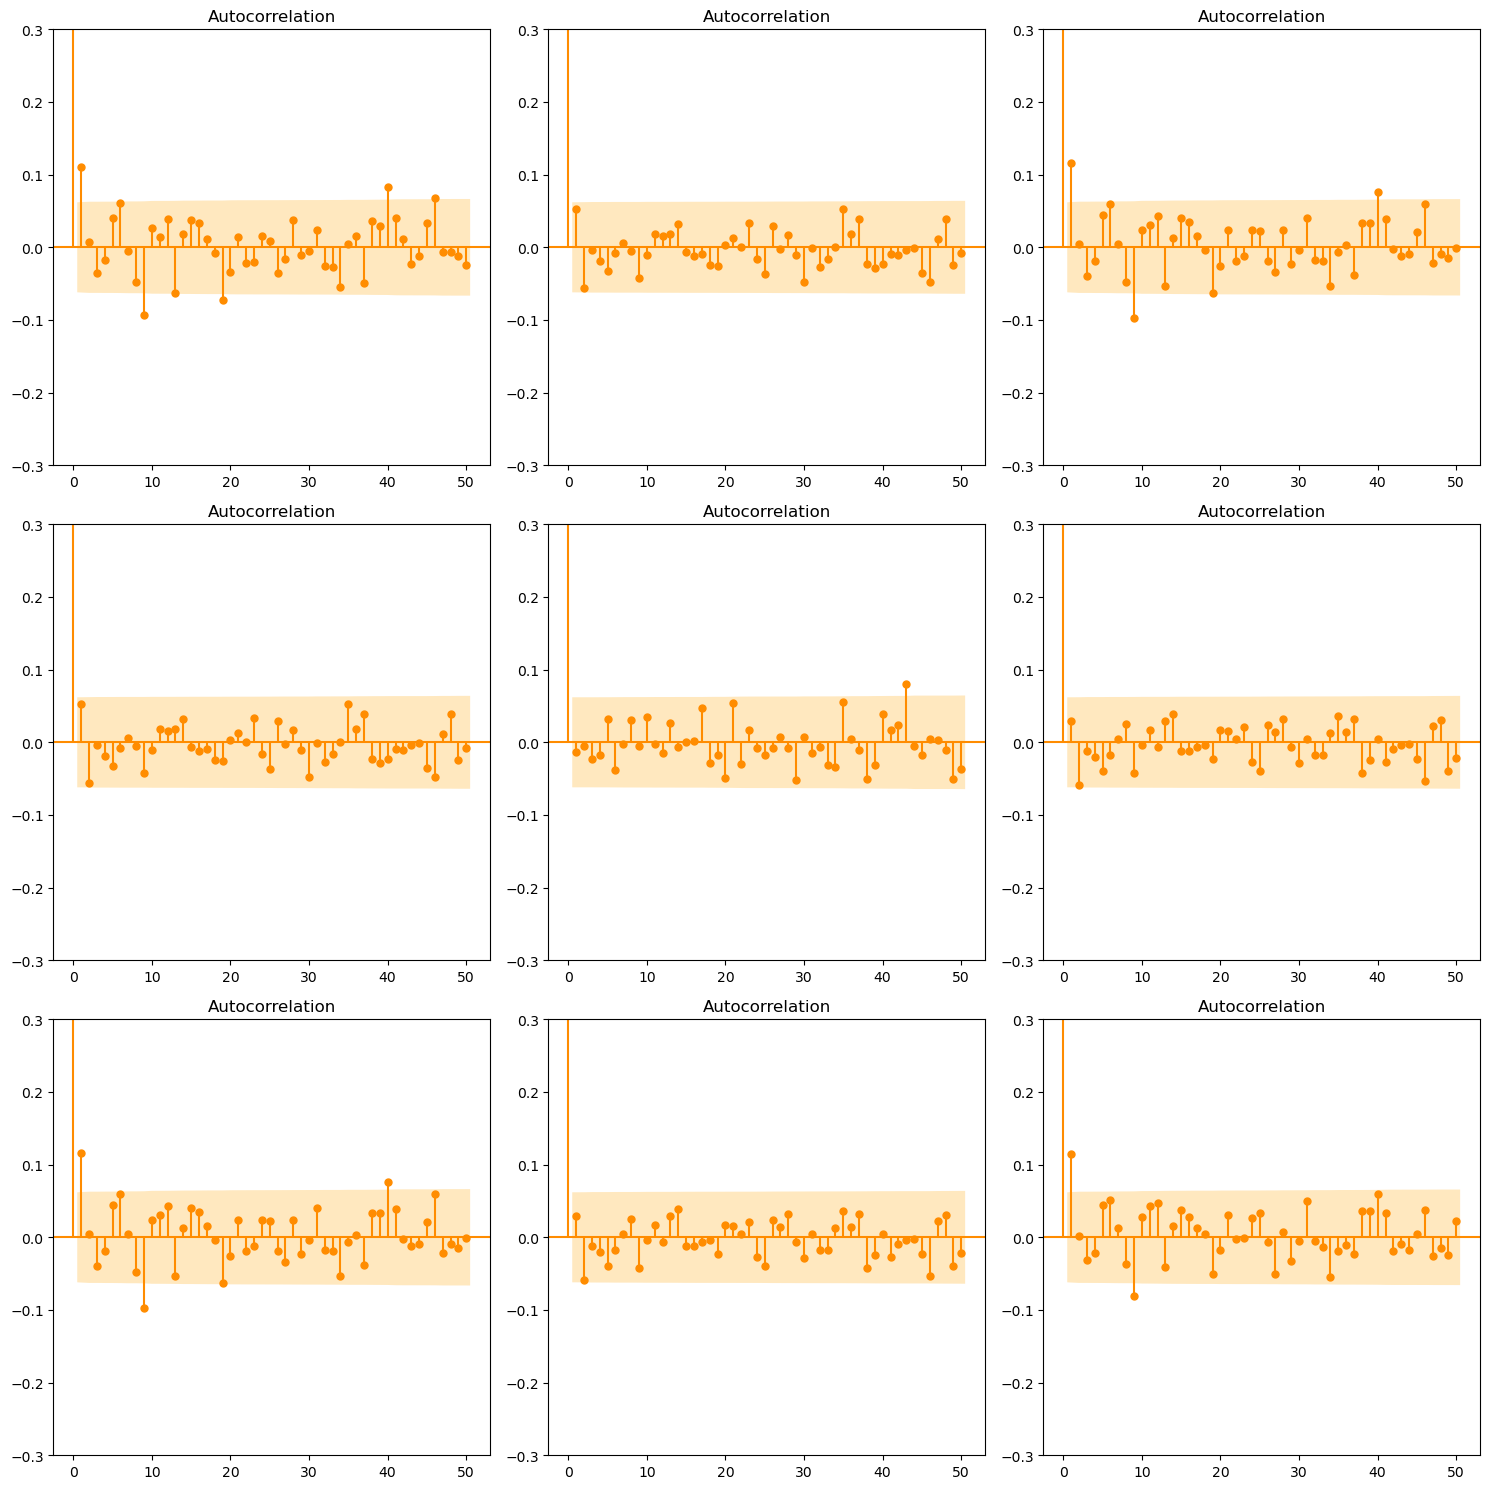

In [87]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
plot_acf(Sigma_1[:,0,0], lags = 50, ax = ax[0,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,0,1], lags = 50, ax = ax[0,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,0,2], lags = 50, ax = ax[0,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,1,0], lags = 50, ax = ax[1,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,1,1], lags = 50, ax = ax[1,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,1,2], lags = 50, ax = ax[1,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,2,0], lags = 50, ax = ax[2,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,2,1], lags = 50, ax = ax[2,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
plot_acf(Sigma_1[:,2,2], lags = 50, ax = ax[2,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ax[0,0].set_ylim([-0.3, 0.3])
ax[0,1].set_ylim([-0.3, 0.3])
ax[0,2].set_ylim([-0.3, 0.3])
ax[1,0].set_ylim([-0.3, 0.3])
ax[1,1].set_ylim([-0.3, 0.3])
ax[1,2].set_ylim([-0.3, 0.3])
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for i in range(3):
    for item in ax[i,0].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orange')
    for item in ax[i,1].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orange')
    for item in ax[i,2].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orange')
fig.tight_layout()

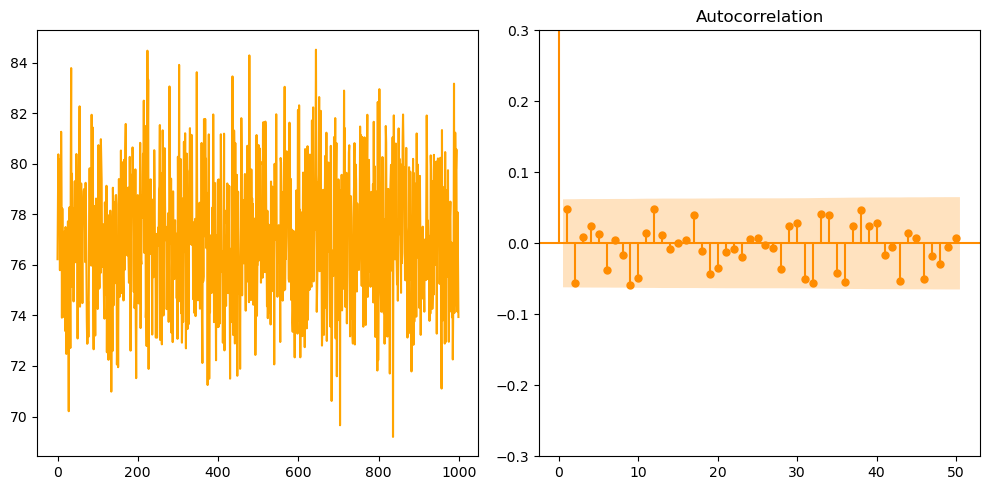

In [85]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(sigma2_1, color = 'orange')
plot_acf(sigma2_1, lags = 50, ax = ax[1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ax[1].set_ylim([-0.3, 0.3])
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkorange')
fig.tight_layout()

In [23]:
X_b = np.zeros((m,3))
Y_b = np.zeros((m,))
for j, sch_id in enumerate(unique_sid):
    Y = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
    X = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
    n = Y.shape[0]
    Y = Y.reshape((n, 1))
    X = np.hstack((np.ones((n,1)), X.reshape((n, 2))))
    X_b[j] = X.mean(axis = 0)
    Y_b[j] = Y.mean(axis = 0)

In [24]:
beta_hat, sigma2_hat = OLS(Y_b, X_b)

In [25]:
Y = np.array(s2['stu_mathscore'])[:,np.newaxis]
X = np.array(s2[['stu_ses', 'sch_freelunch']])
X = np.hstack((np.ones((len(s2),1)), X.reshape((len(s2), 2))))
beta_hat = beta_hat.reshape((3,1))
L0_b = 300*sigma2_hat*np.linalg.inv(np.dot(X.T, X))
v0 = 1
burnin = 10000
it_after_burnin = 10000
batch_size = 10
Beta_2, sigma2_2, theta_2, Sigma_2 = posterior_with_covariates_batch_it(Y, X, s2, L0_b, unique_sid, beta_hat, v0, sigma2_hat, burnin, it_after_burnin, batch_size)

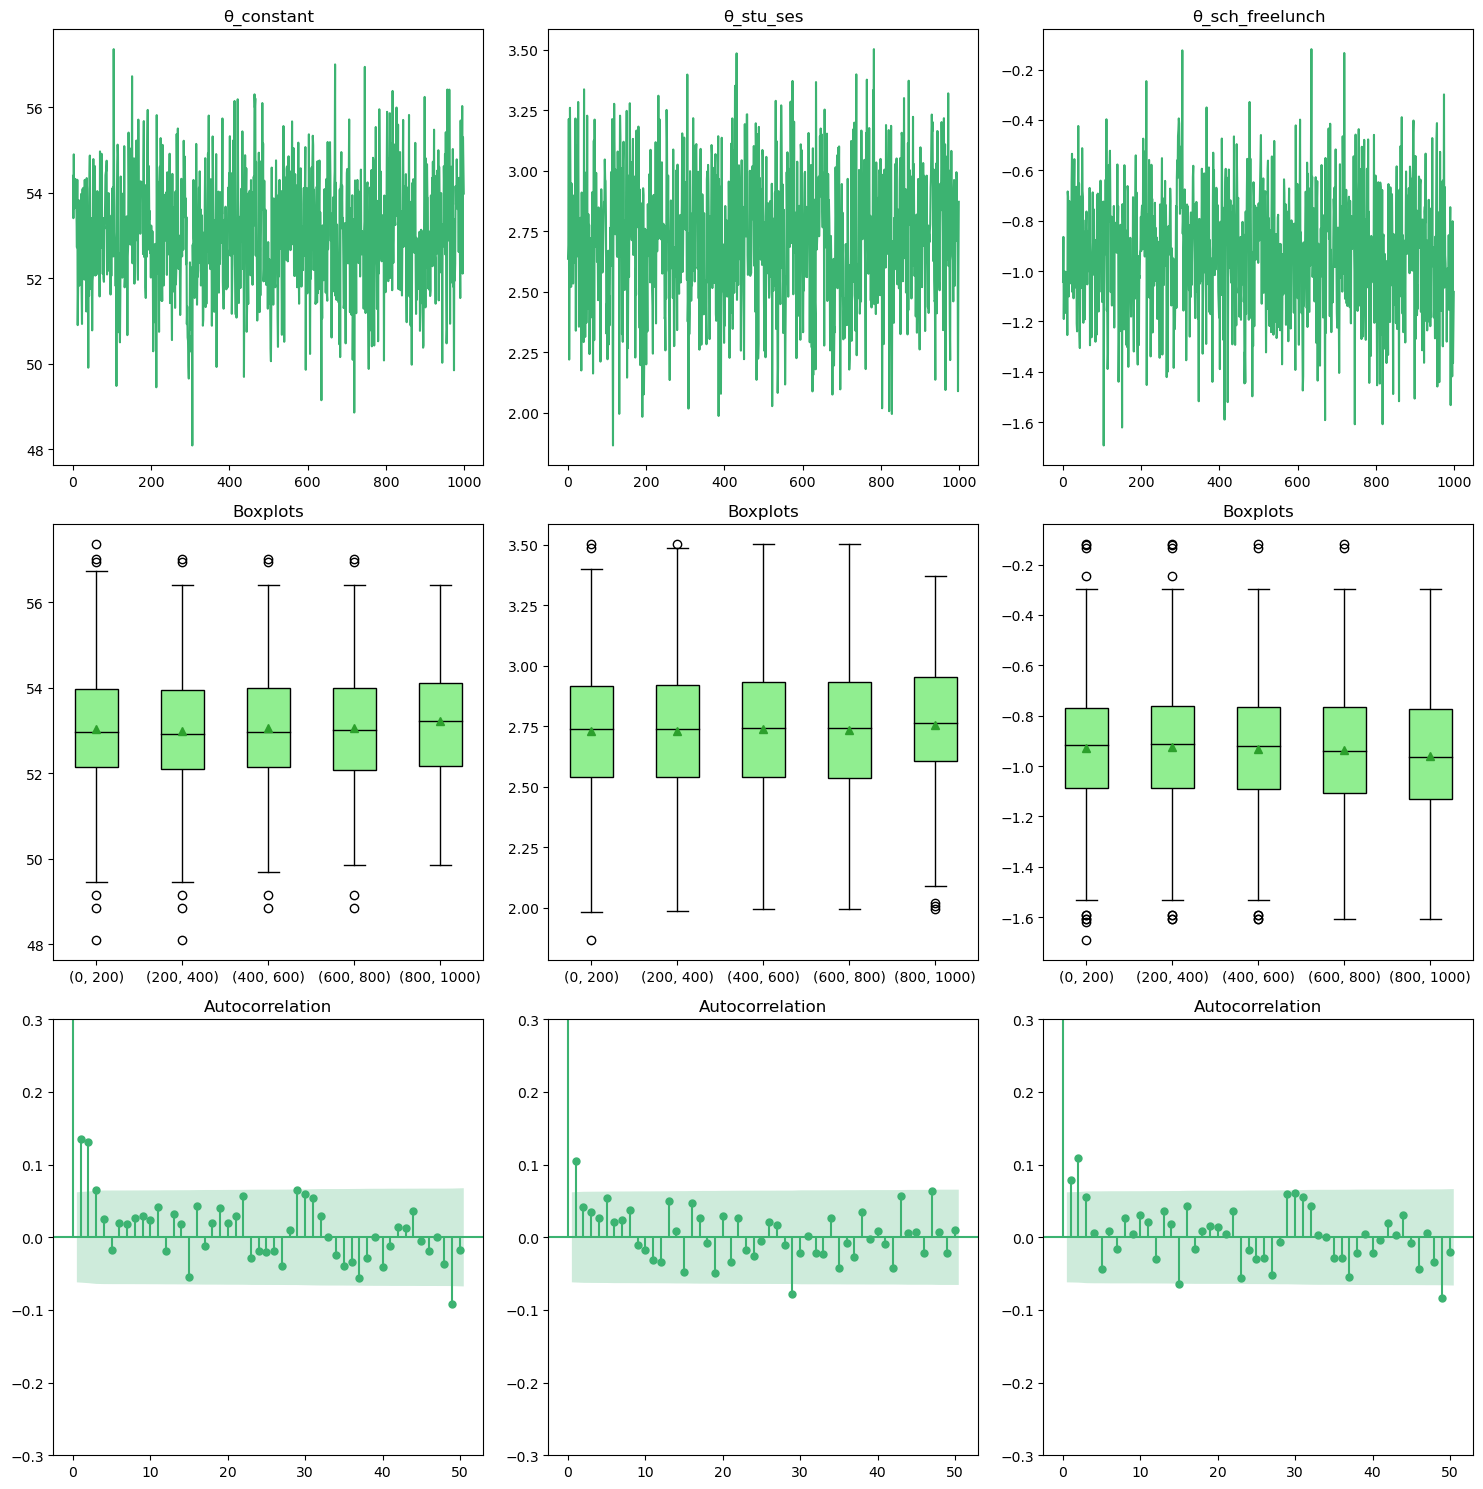

In [166]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(theta_2[:,0], 'mediumseagreen')
ax[0,1].plot(theta_2[:,1], 'mediumseagreen')
ax[0,2].plot(theta_2[:,2], 'mediumseagreen')
ax[0,0].title.set_text('θ_constant')
ax[0,1].title.set_text('θ_stu_ses')
ax[0,2].title.set_text('θ_sch_freelunch')
ax[1,0].boxplot(np.array([theta_2[k:, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([theta_2[k:, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([theta_2[k:, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black"))
plot_acf(theta_2[:,0], lags = 50, ax = ax[2,0], color= 'mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(theta_2[:,1], lags = 50, ax = ax[2,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(theta_2[:,2], lags = 50, ax = ax[2,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
fig.tight_layout()
fig.savefig('TPACB-Theta2.pdf')

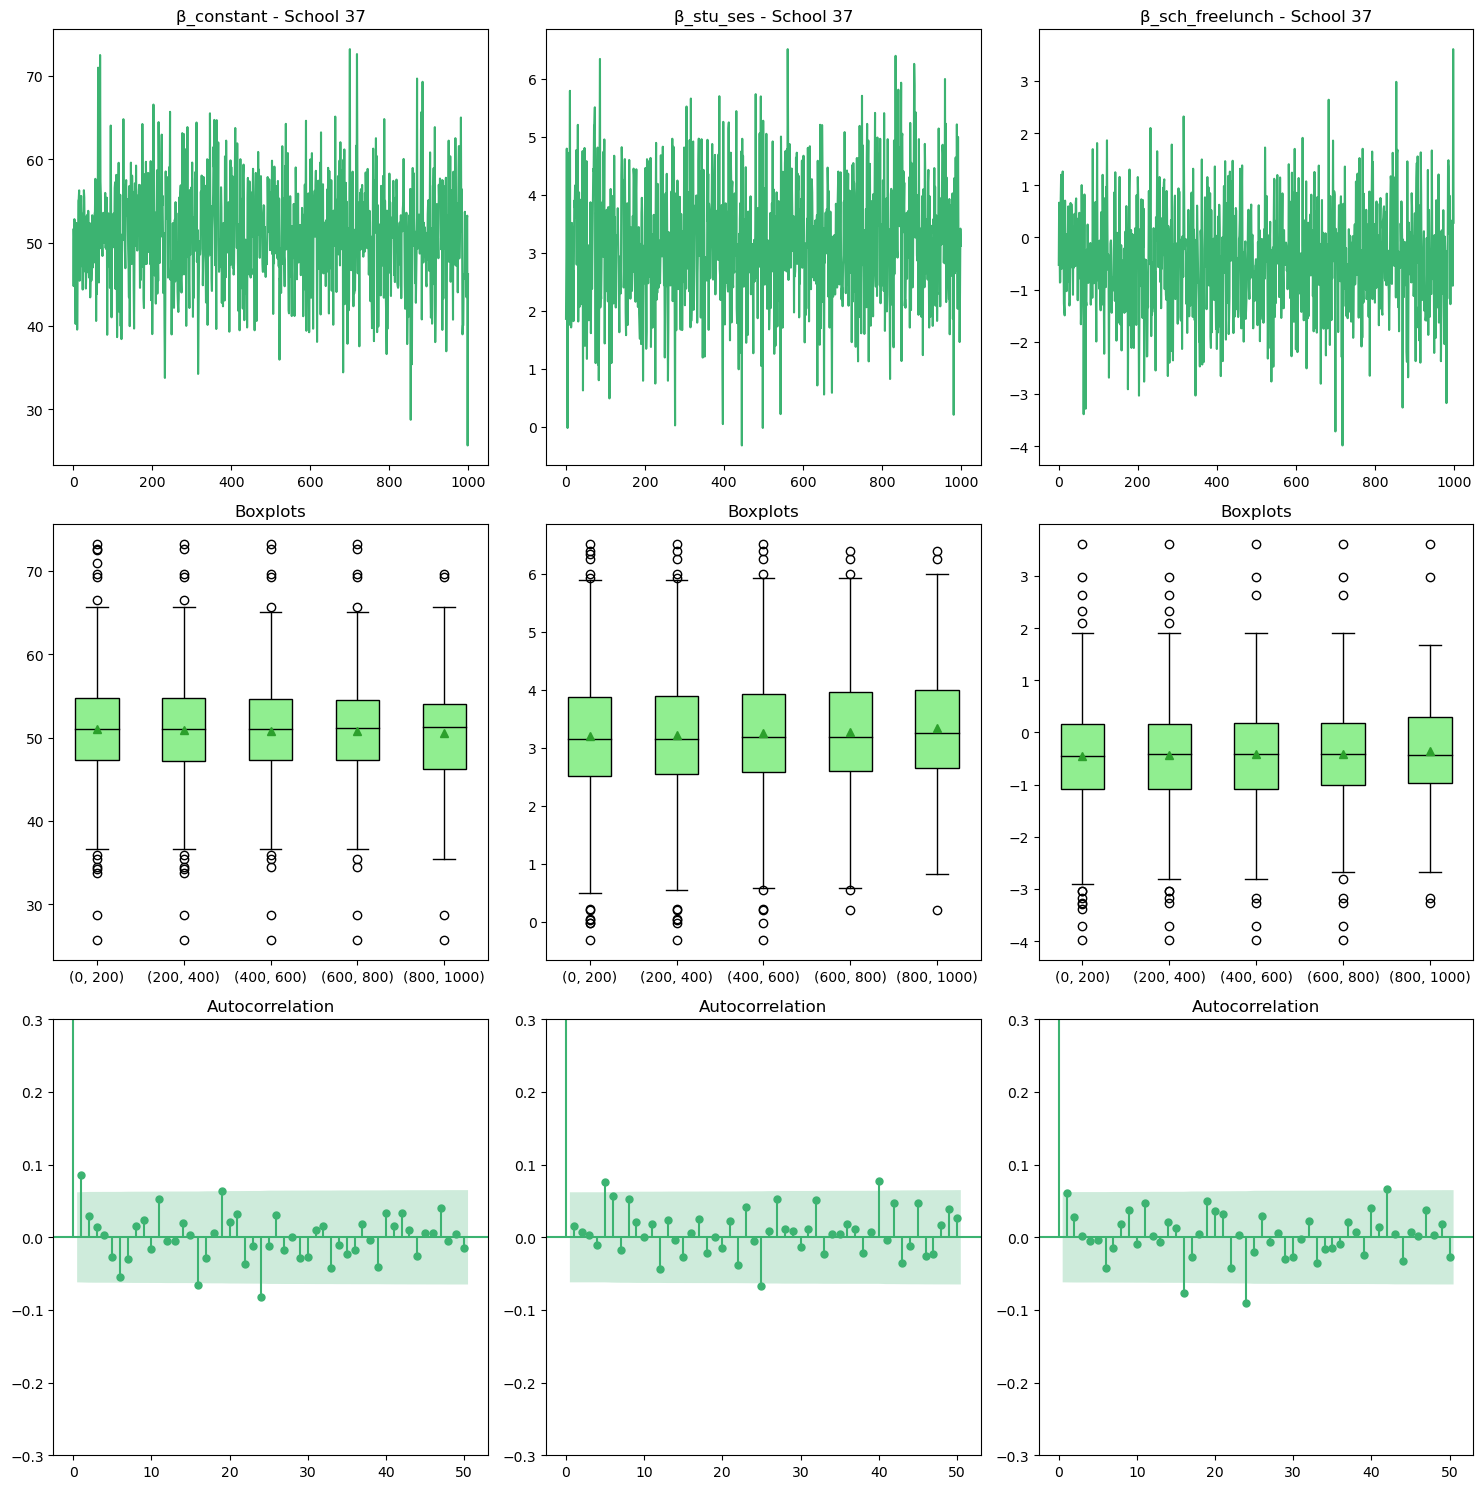

In [454]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_2[:,36,0], color = 'mediumseagreen')
ax[0,1].plot(Beta_2[:,36,1], color = 'mediumseagreen')
ax[0,2].plot(Beta_2[:,36,2], color = 'mediumseagreen')
plot_acf(Beta_2[:,36,0], lags = 50, ax = ax[2,0], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Beta_2[:,36,1], lags = 50, ax = ax[2,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Beta_2[:,36,2], lags = 50, ax = ax[2,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ax[1,0].boxplot(np.array([Beta_2[k:,36, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_2[k:,36, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_2[k:,36, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black"))
ax[0,0].title.set_text('β_constant - School 37')
ax[0,1].title.set_text('β_stu_ses - School 37')
ax[0,2].title.set_text('β_sch_freelunch - School 37')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
fig.tight_layout()
fig.savefig('TPACB-Beta2_36.pdf')

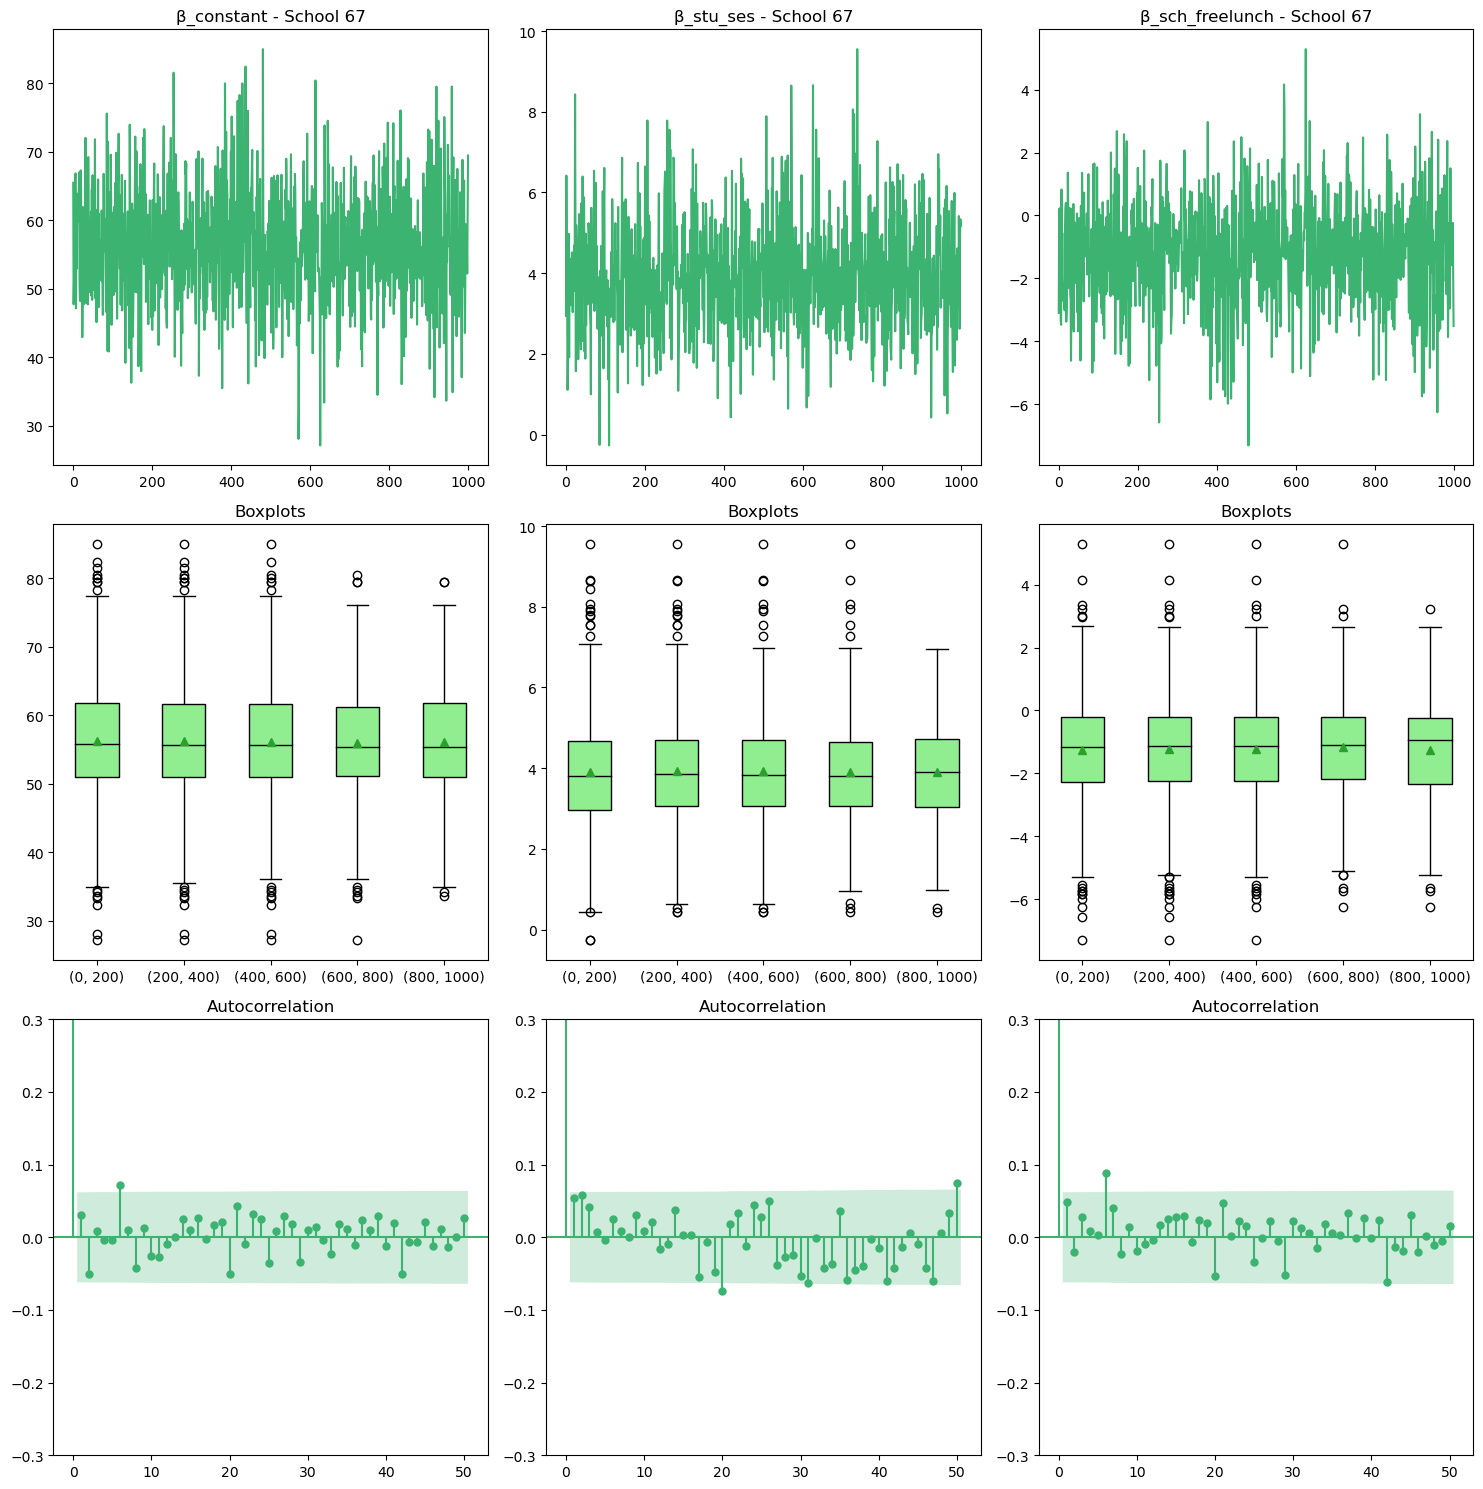

In [455]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_2[:,66,0], color = 'mediumseagreen')
ax[0,1].plot(Beta_2[:,66,1], color = 'mediumseagreen')
ax[0,2].plot(Beta_2[:,66,2], color = 'mediumseagreen')
plot_acf(Beta_2[:,66,0], lags = 50, ax = ax[2,0], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Beta_2[:,66,1], lags = 50, ax = ax[2,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Beta_2[:,66,2], lags = 50, ax = ax[2,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ax[1,0].boxplot(np.array([Beta_2[k:,66, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_2[k:,66, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_2[k:,66, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black"))
ax[0,0].title.set_text('β_constant - School 67')
ax[0,1].title.set_text('β_stu_ses - School 67')
ax[0,2].title.set_text('β_sch_freelunch - School 67')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
fig.tight_layout()
fig.savefig('TPACB-Beta2_66.pdf')

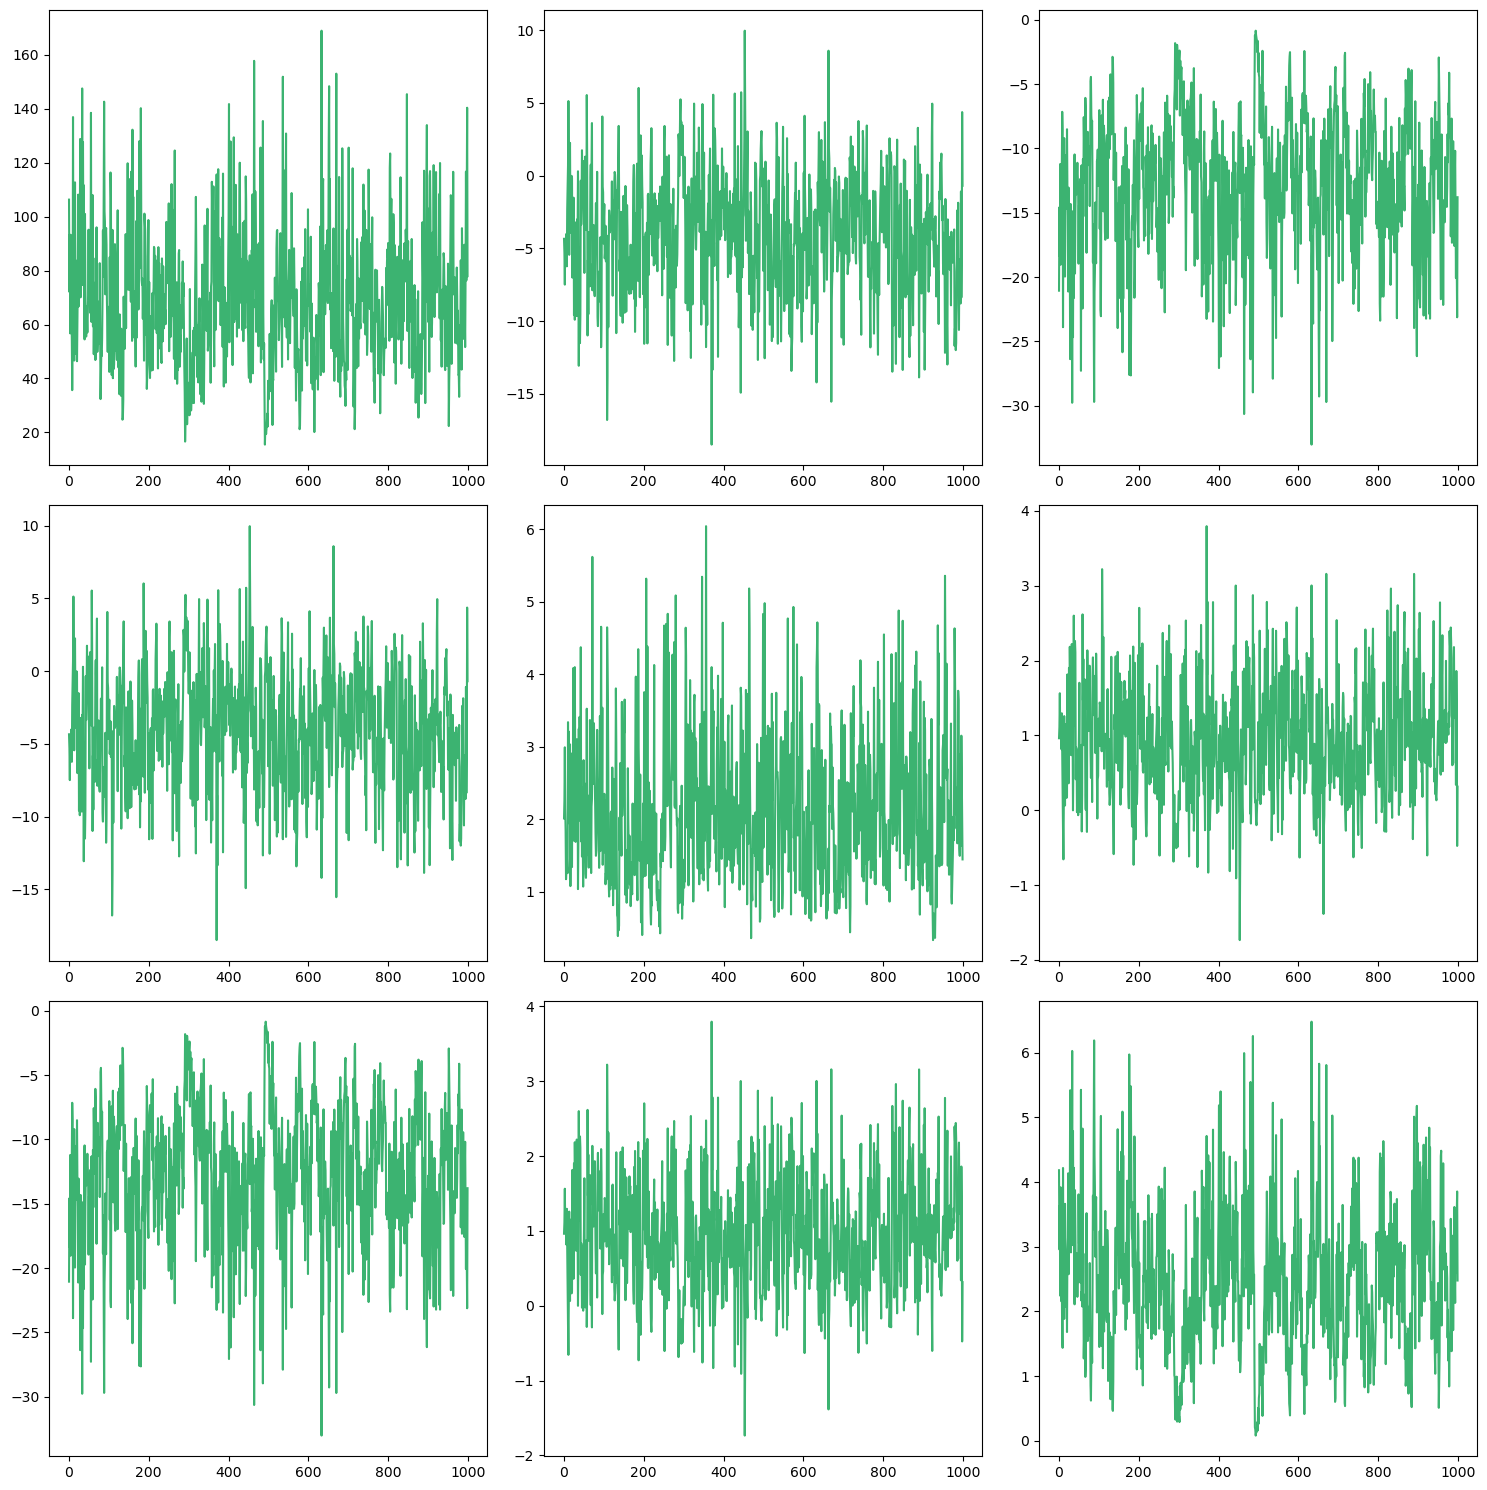

In [81]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Sigma_2[:,0,0], color = 'mediumseagreen')
ax[0,1].plot(Sigma_2[:,0,1], color = 'mediumseagreen')
ax[0,2].plot(Sigma_2[:,0,2], color = 'mediumseagreen')
ax[1,0].plot(Sigma_2[:,1,0], color = 'mediumseagreen')
ax[1,1].plot(Sigma_2[:,1,1], color = 'mediumseagreen')
ax[1,2].plot(Sigma_2[:,1,2], color = 'mediumseagreen')
ax[2,0].plot(Sigma_2[:,2,0], color = 'mediumseagreen')
ax[2,1].plot(Sigma_2[:,2,1], color = 'mediumseagreen')
ax[2,2].plot(Sigma_2[:,2,2], color = 'mediumseagreen')
fig.tight_layout()

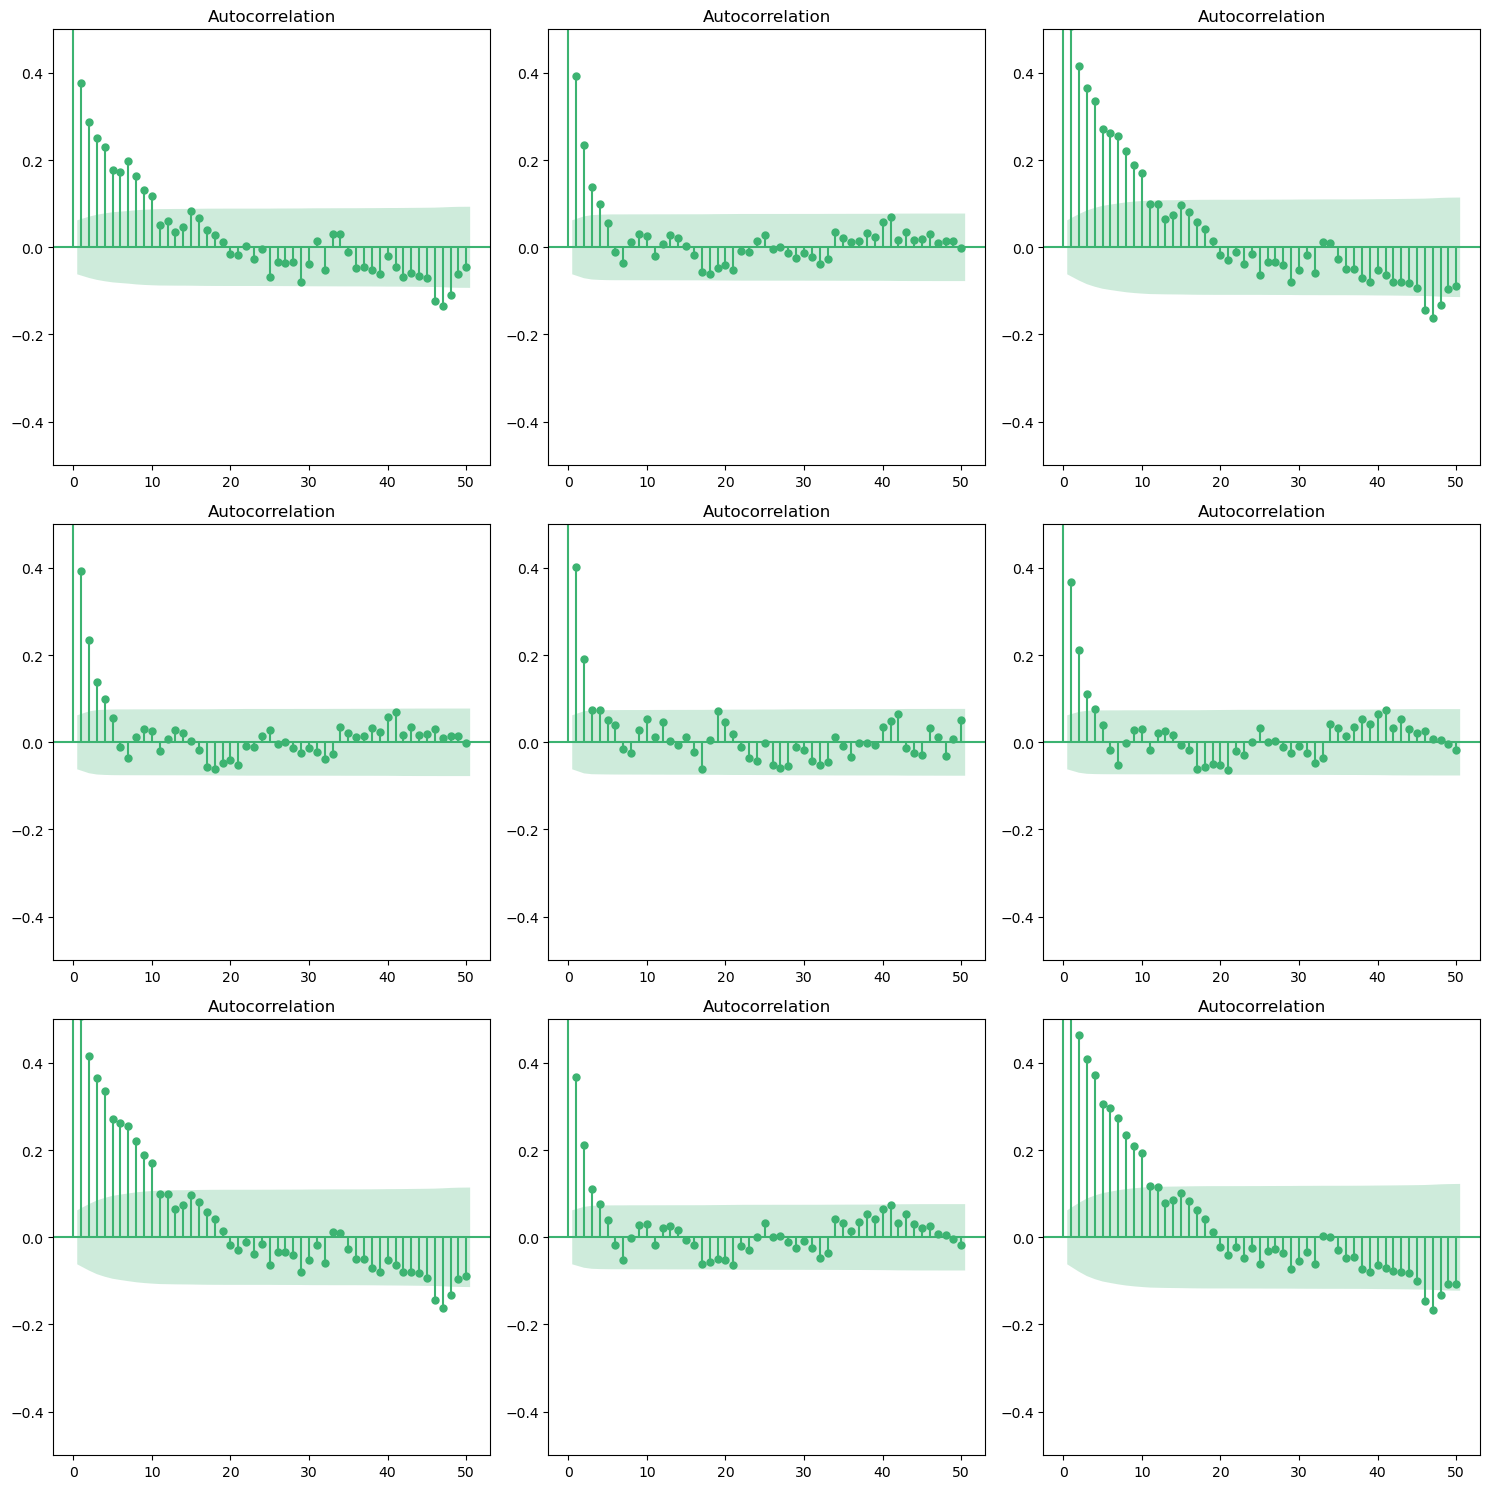

In [281]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
plot_acf(Sigma_2[:,0,0], lags = 50, ax = ax[0,0], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,0,1], lags = 50, ax = ax[0,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,0,2], lags = 50, ax = ax[0,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,1,0], lags = 50, ax = ax[1,0], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,1,1], lags = 50, ax = ax[1,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,1,2], lags = 50, ax = ax[1,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,2,0], lags = 50, ax = ax[2,0], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,2,1], lags = 50, ax = ax[2,1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
plot_acf(Sigma_2[:,2,2], lags = 50, ax = ax[2,2], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ax[0,0].set_ylim([-0.5, 0.5])
ax[0,1].set_ylim([-0.5, 0.5])
ax[0,2].set_ylim([-0.5, 0.5])
ax[1,0].set_ylim([-0.5, 0.5])
ax[1,1].set_ylim([-0.5, 0.5])
ax[1,2].set_ylim([-0.5, 0.5])
ax[2,0].set_ylim([-0.5, 0.5])
ax[2,1].set_ylim([-0.5, 0.5])
ax[2,2].set_ylim([-0.5, 0.5])
for i in range(3):
    for item in ax[i,0].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('mediumseagreen')
    for item in ax[i,1].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('mediumseagreen')
    for item in ax[i,2].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('mediumseagreen')
fig.tight_layout()

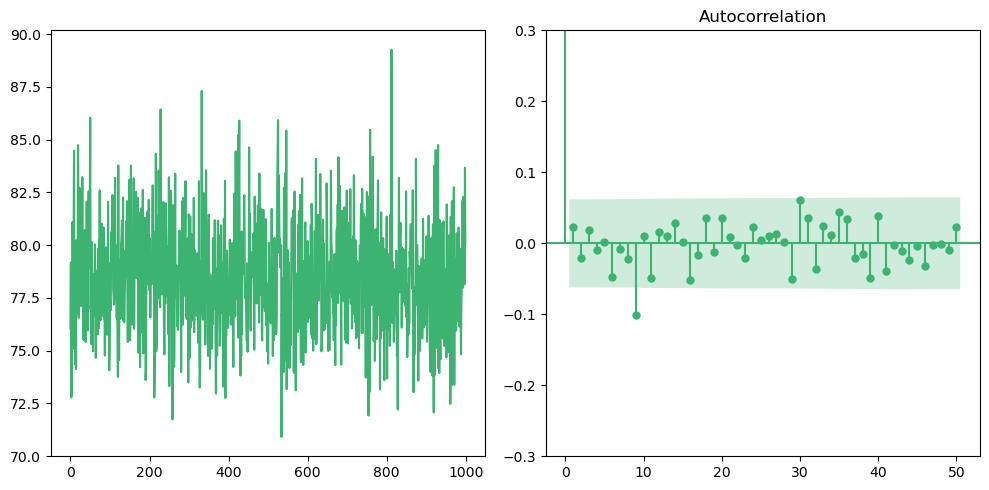

In [111]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(sigma2_2, color = 'mediumseagreen')
plot_acf(sigma2_2, lags = 50, ax = ax[1], color='mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ax[1].set_ylim([-0.3, 0.3])
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
fig.tight_layout()

In [29]:
def posterior_with_covariates_batch_from_exp(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size):
    
    n = np.shape(X)[0] #number of observations
    p = np.shape(X)[1]-1 #number of covariates, without the intercept
    eta0 = p + 2
    m = len(unique_sid)
    L0_inv = np.linalg.inv(L0)
    S0 = L0
    S0_inv = L0_inv
    a = (v0+n)/2

    #initial values
    theta = mu0
    Sigma = S0
    sigma2 = sigma2_0
    
    #BurnIn
    Beta = np.zeros((m, p+1))
    for i in range(burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = (1/np.random.gamma(shape = a, scale = b, size = 1))
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
    
    #Actual iterations
    Beta = np.zeros((m, p+1))
    Beta_store = np.zeros((it_after_burnin//batch_size, m, p+1))
    theta_store = np.zeros((it_after_burnin//batch_size, p+1))
    Sigma_store = np.zeros((it_after_burnin//batch_size, p+1, p+1))
    sigma2_store = np.zeros((it_after_burnin//batch_size))
    for i in range(it_after_burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = 1/np.random.gamma(shape = a, scale = b, size = 1)
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
        
        #save the data
        if i%batch_size == 0:
            for j in range (m):
                Beta_store[i//batch_size,j] = Beta[j]
            sigma2_store[i//batch_size] = sigma2
            theta_store[i//batch_size] = theta.reshape((3,))
            Sigma_store[i//batch_size] = Sigma
        
    
    return Beta_store, sigma2_store, theta_store, Sigma_store   

In [30]:
L0 = 300*sigma2_0*np.linalg.inv(np.dot(X.T, X))
v0 = 1
burnin = 10000
it_after_burnin = 10000
batch_size = 10
Beta_3, sigma2_3, theta_3, Sigma_3 = posterior_with_covariates_batch_from_exp(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size)

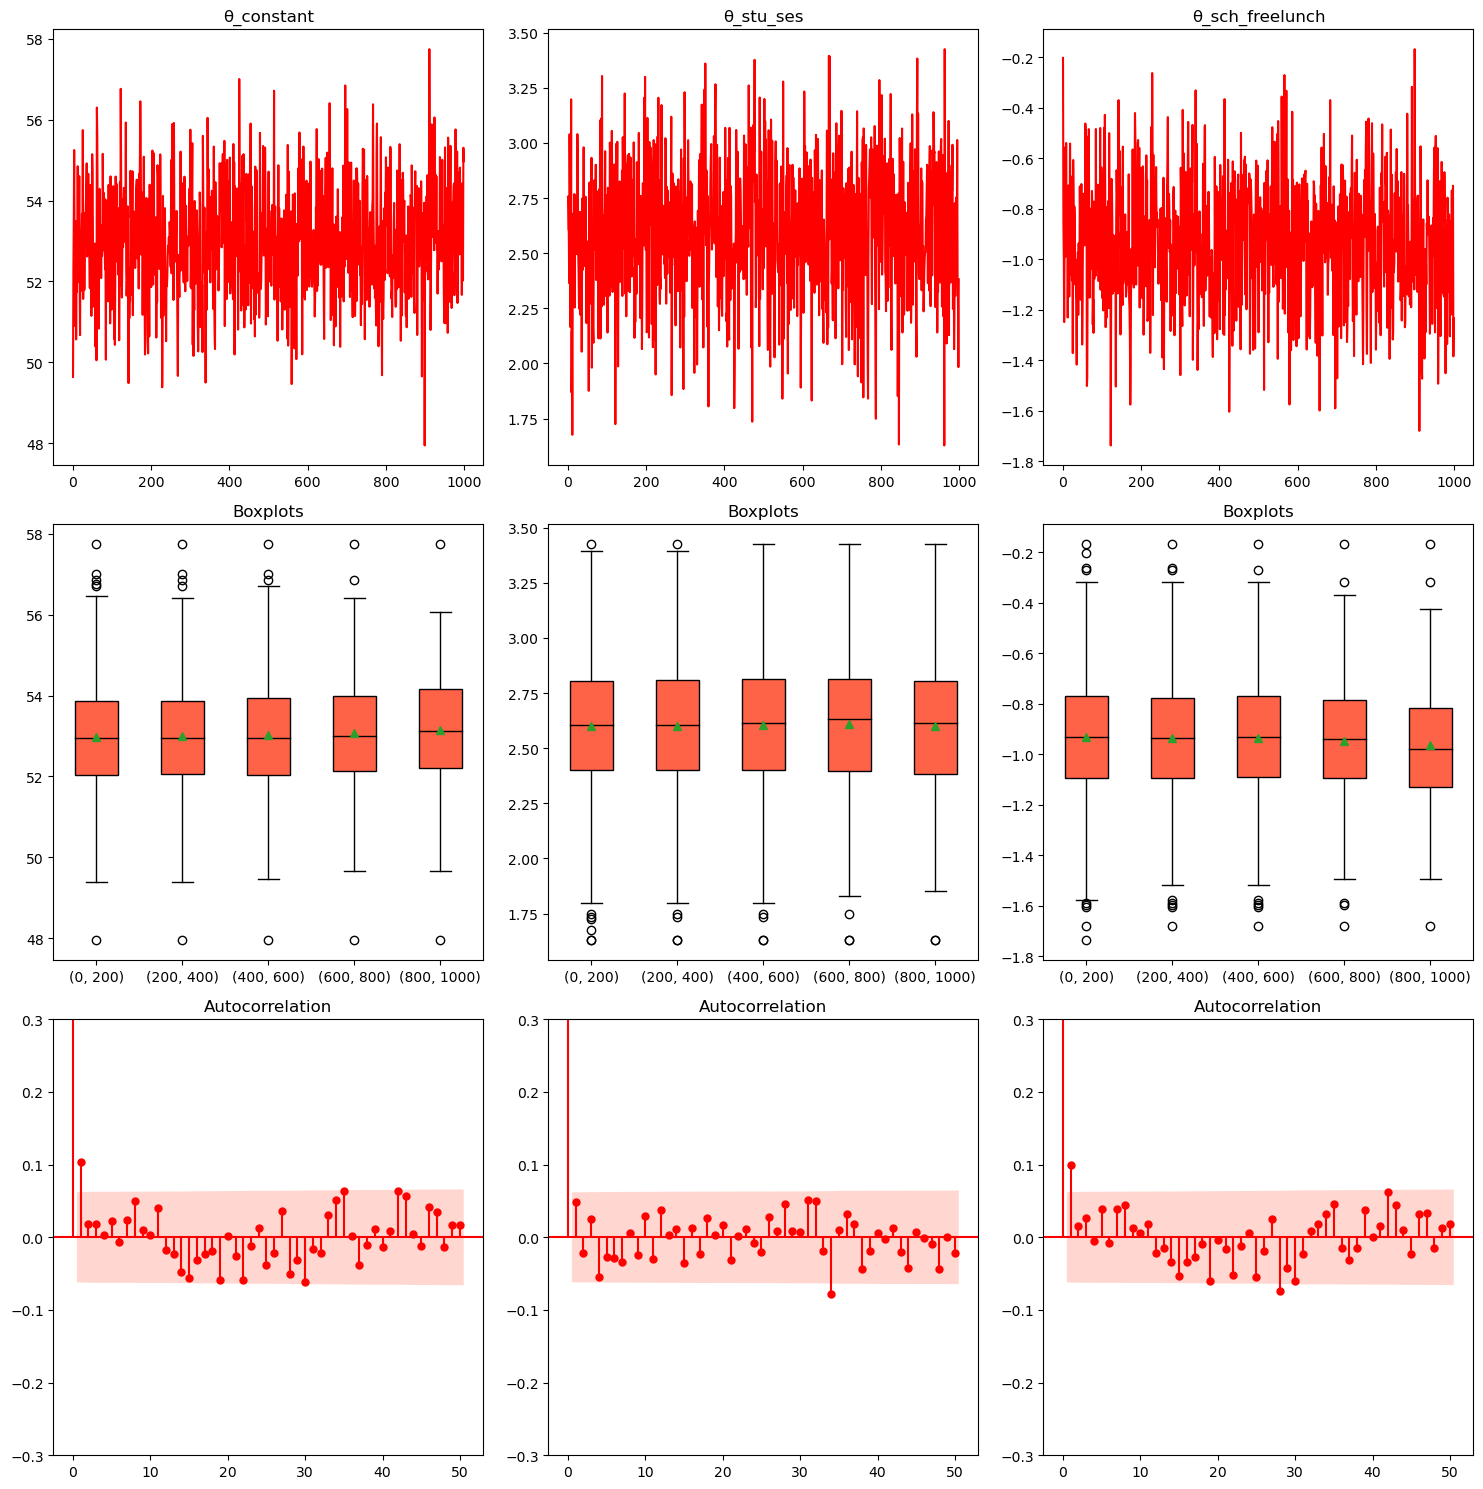

In [167]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(theta_3[:,0], 'r')
ax[0,1].plot(theta_3[:,1], 'r')
ax[0,2].plot(theta_3[:,2], 'r')
ax[0,0].title.set_text('θ_constant')
ax[0,1].title.set_text('θ_stu_ses')
ax[0,2].title.set_text('θ_sch_freelunch')
ax[1,0].boxplot(np.array([theta_3[k:, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([theta_3[k:, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([theta_3[k:, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black"))
plot_acf(theta_3[:,0], lags = 50, ax = ax[2,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(theta_3[:,1], lags = 50, ax = ax[2,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(theta_3[:,2], lags = 50, ax = ax[2,2], color='r', vlines_kwargs={"colors": 'r'})
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')

fig.tight_layout()
fig.savefig('TPACB-Theta3.pdf')

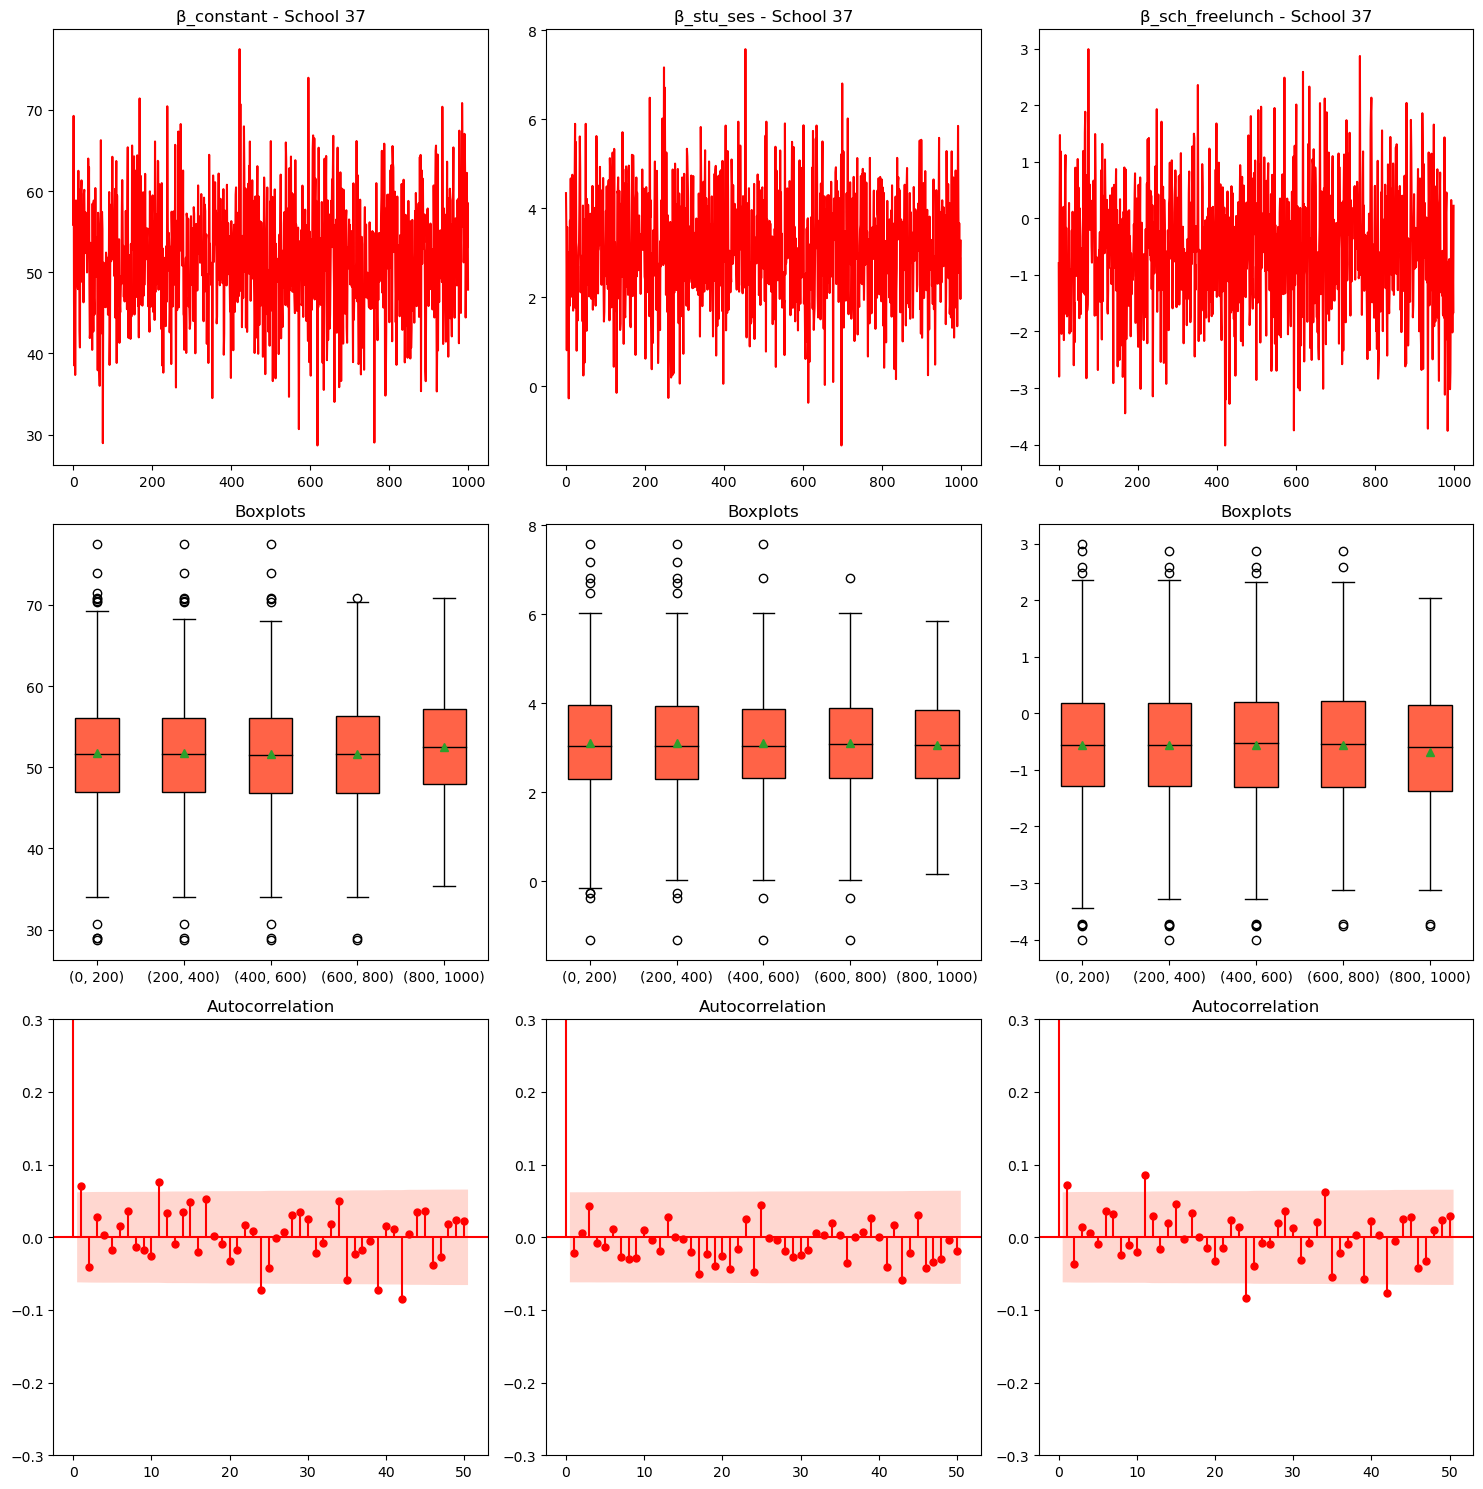

In [456]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_3[:,36,0], color = 'r')
ax[0,1].plot(Beta_3[:,36,1], color = 'r')
ax[0,2].plot(Beta_3[:,36,2], color = 'r')
plot_acf(Beta_3[:,36,0], lags = 50, ax = ax[2,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Beta_3[:,36,1], lags = 50, ax = ax[2,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Beta_3[:,36,2], lags = 50, ax = ax[2,2], color='r', vlines_kwargs={"colors": 'r'})
ax[1,0].boxplot(np.array([Beta_3[k:,36, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_3[k:,36, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_3[k:,36, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black"))
ax[0,0].title.set_text('β_constant - School 37')
ax[0,1].title.set_text('β_stu_ses - School 37')
ax[0,2].title.set_text('β_sch_freelunch - School 37')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')

fig.tight_layout()
fig.savefig('TPACB-Beta3_36.pdf')

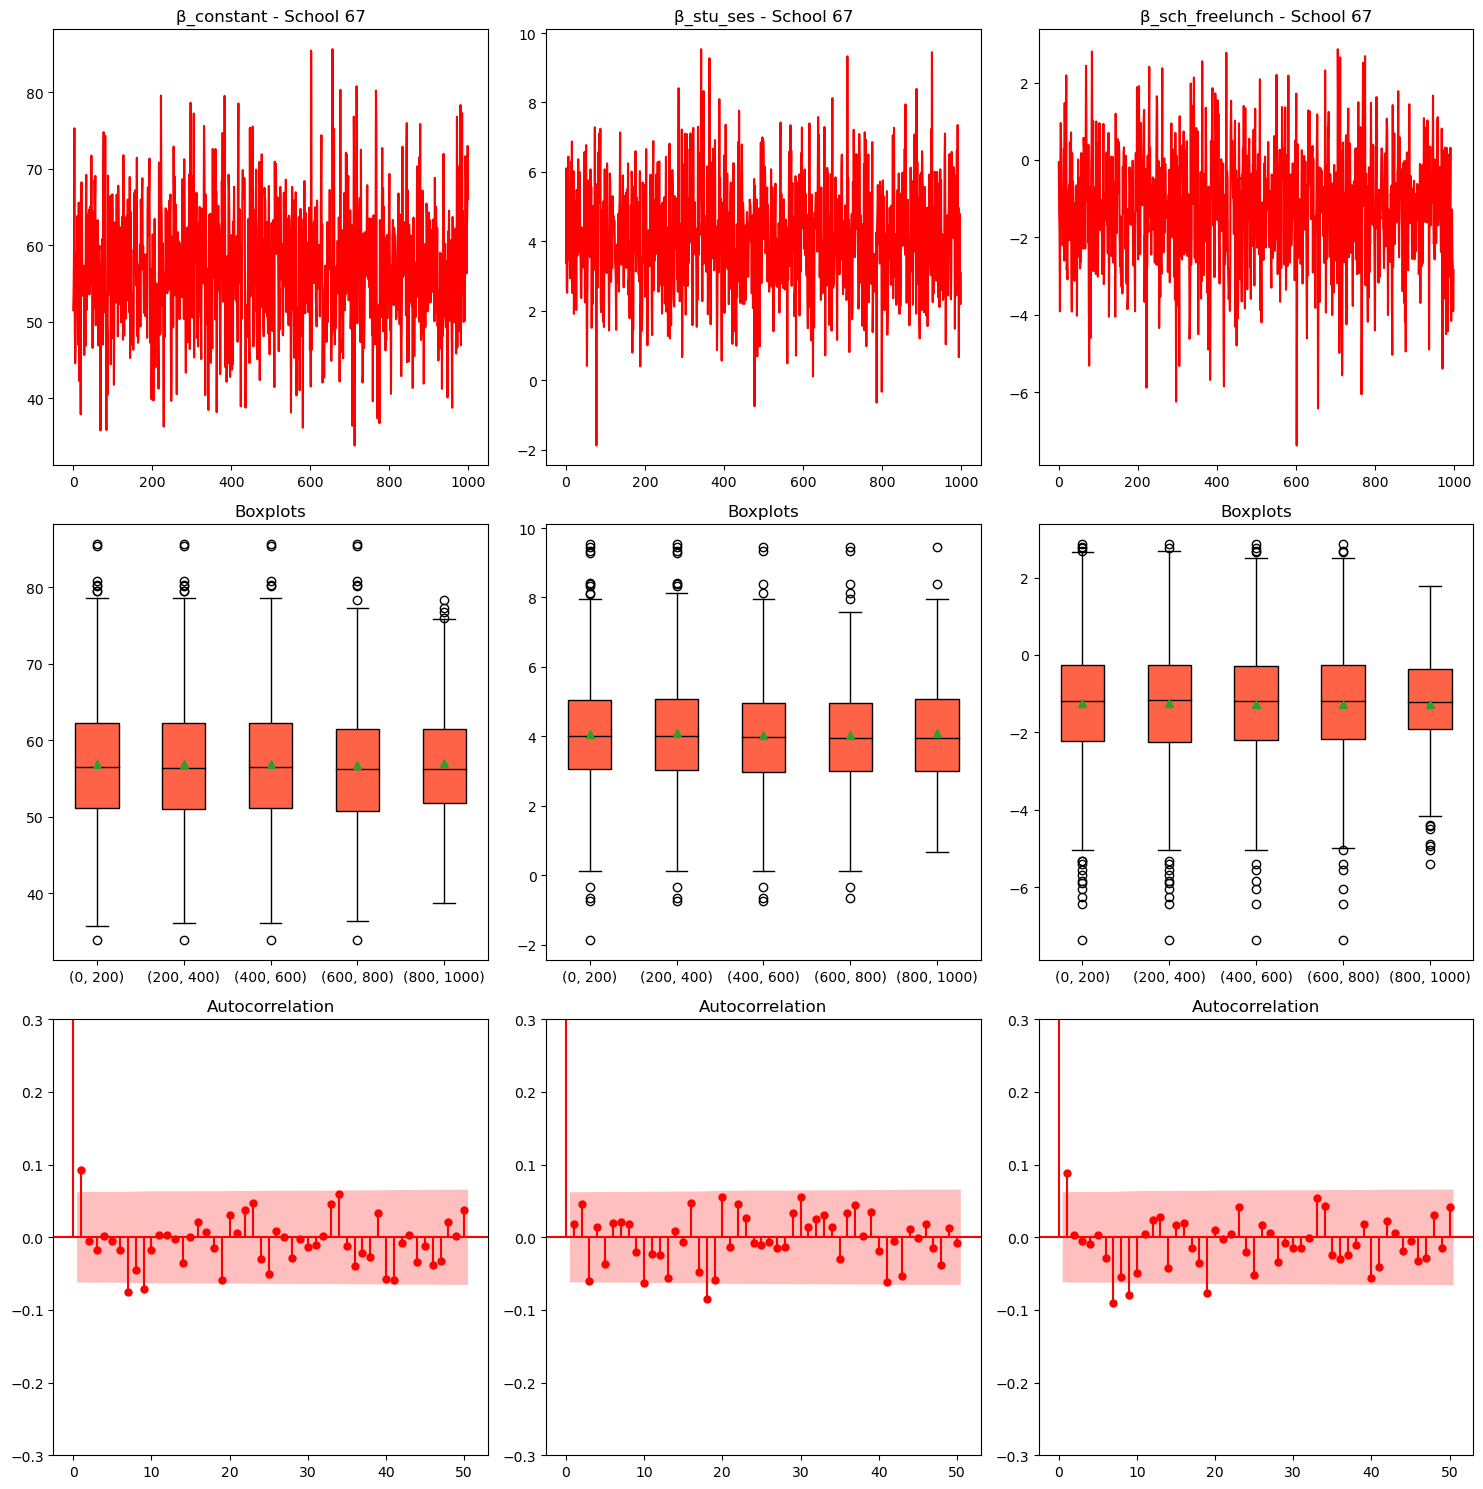

In [457]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_3[:,66,0], color = 'r')
ax[0,1].plot(Beta_3[:,66,1], color = 'r')
ax[0,2].plot(Beta_3[:,66,2], color = 'r')
plot_acf(Beta_3[:,66,0], lags = 50, ax = ax[2,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Beta_3[:,66,1], lags = 50, ax = ax[2,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Beta_3[:,66,2], lags = 50, ax = ax[2,2], color='r', vlines_kwargs={"colors": 'r'})
ax[1,0].boxplot(np.array([Beta_3[k:,66, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_3[k:,66, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_3[k:,66, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='tomato'), showmeans=True, medianprops = dict(color="black"))
ax[0,0].title.set_text('β_constant - School 67')
ax[0,1].title.set_text('β_stu_ses - School 67')
ax[0,2].title.set_text('β_sch_freelunch - School 67')
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('r')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('r')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('r')

fig.tight_layout()
fig.savefig('TPACB-Beta3_66.pdf')

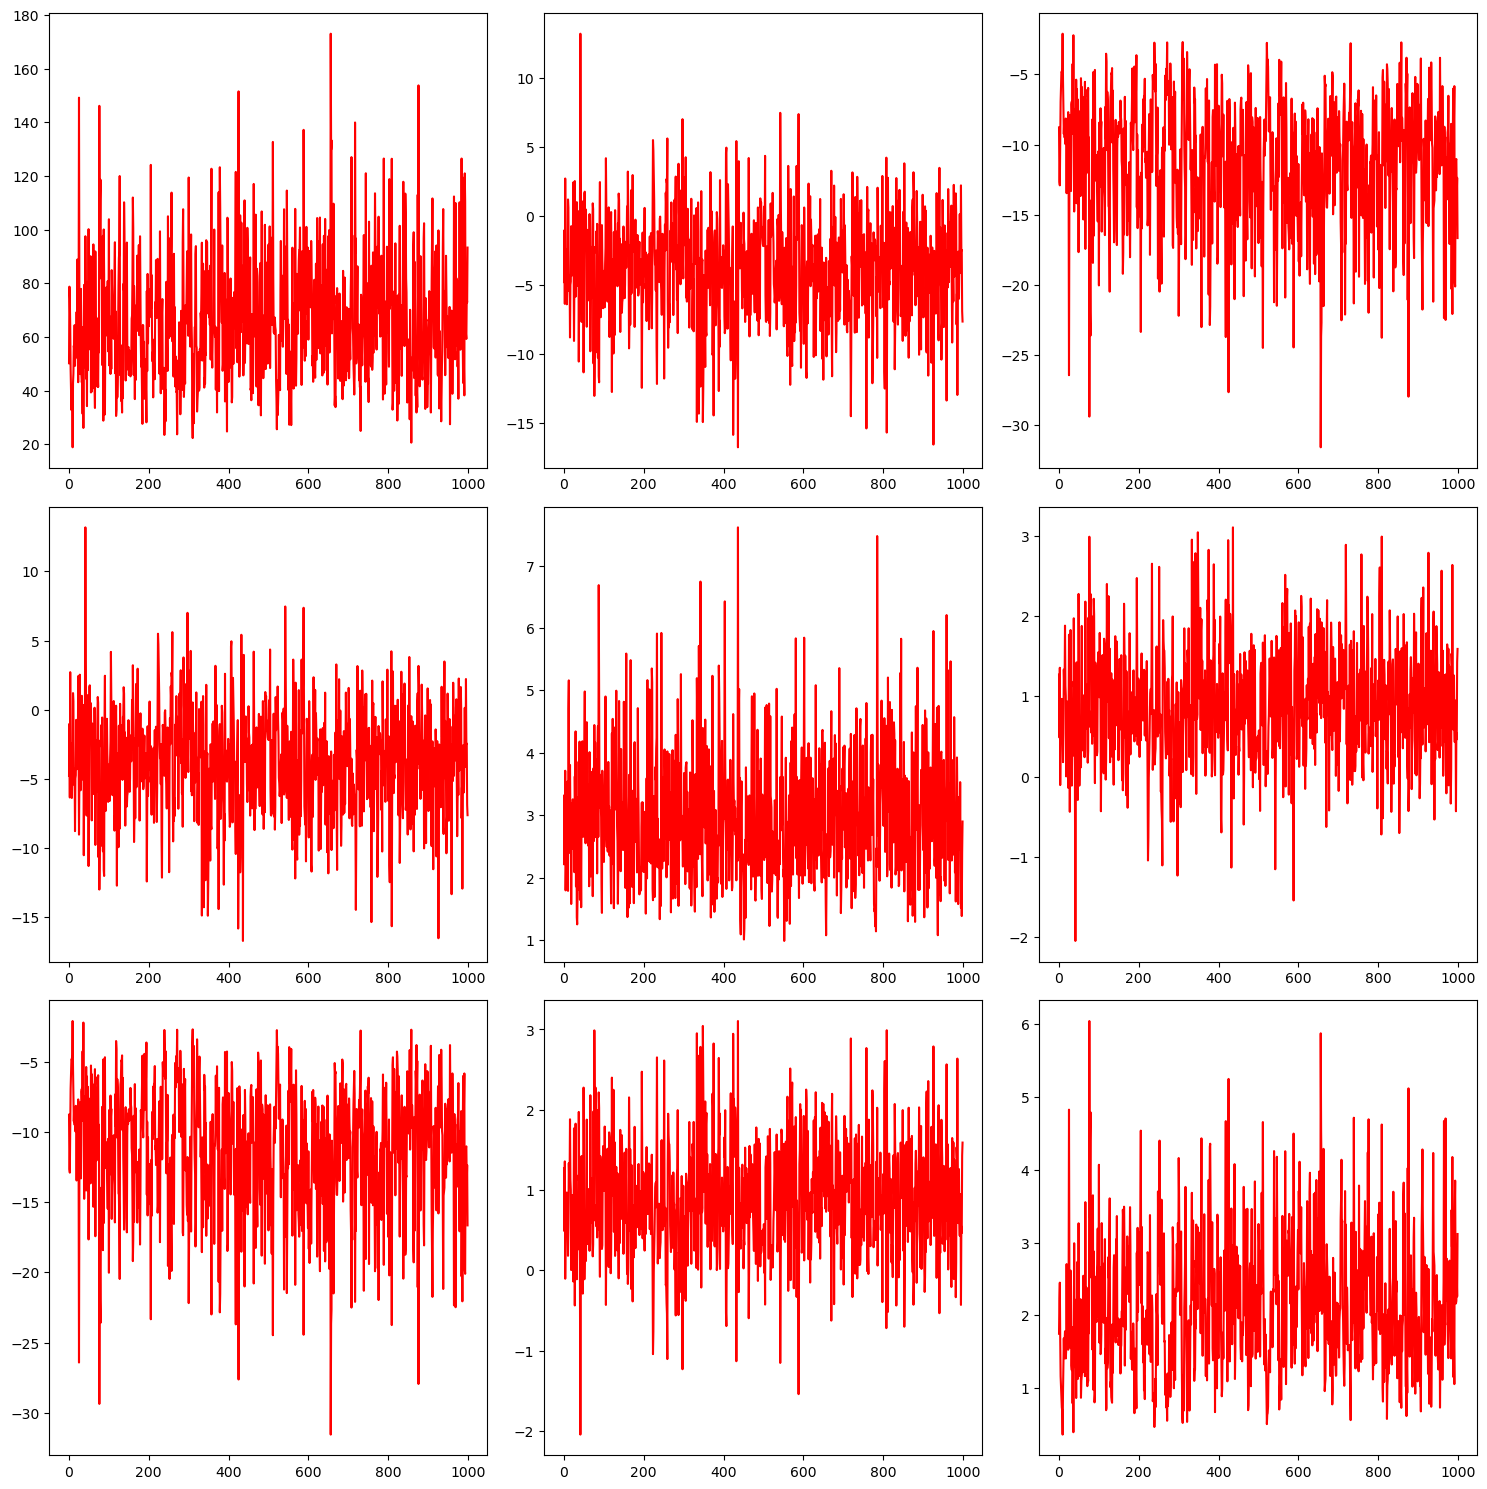

In [80]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Sigma_3[:,0,0], color = 'r')
ax[0,1].plot(Sigma_3[:,0,1], color = 'r')
ax[0,2].plot(Sigma_3[:,0,2], color = 'r')
ax[1,0].plot(Sigma_3[:,1,0], color = 'r')
ax[1,1].plot(Sigma_3[:,1,1], color = 'r')
ax[1,2].plot(Sigma_3[:,1,2], color = 'r')
ax[2,0].plot(Sigma_3[:,2,0], color = 'r')
ax[2,1].plot(Sigma_3[:,2,1], color = 'r')
ax[2,2].plot(Sigma_3[:,2,2], color = 'r')
fig.tight_layout()

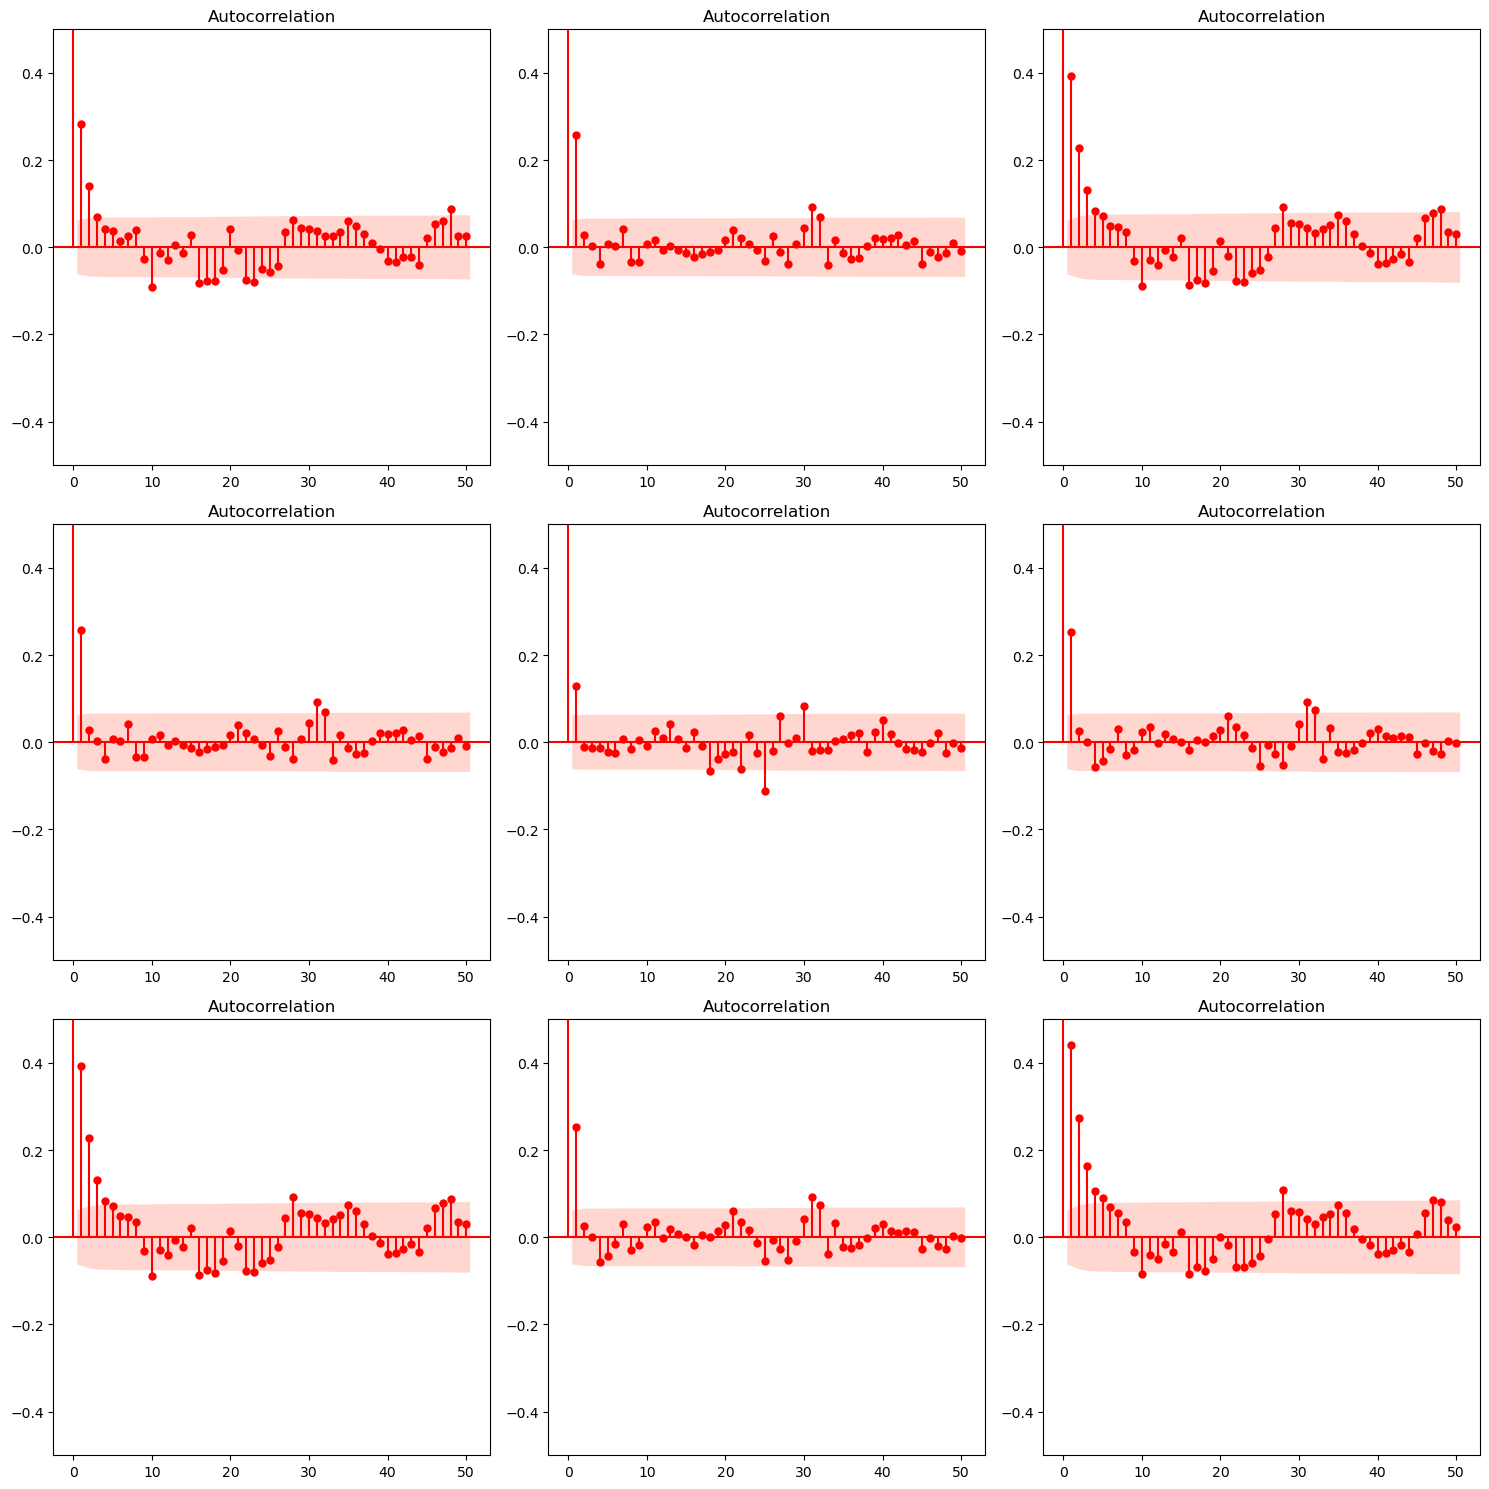

In [108]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
plot_acf(Sigma_3[:,0,0], lags = 50, ax = ax[0,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,0,1], lags = 50, ax = ax[0,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,0,2], lags = 50, ax = ax[0,2], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,1,0], lags = 50, ax = ax[1,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,1,1], lags = 50, ax = ax[1,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,1,2], lags = 50, ax = ax[1,2], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,2,0], lags = 50, ax = ax[2,0], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,2,1], lags = 50, ax = ax[2,1], color='r', vlines_kwargs={"colors": 'r'})
plot_acf(Sigma_3[:,2,2], lags = 50, ax = ax[2,2], color='r', vlines_kwargs={"colors": 'r'})
ax[0,0].set_ylim([-0.5, 0.5])
ax[0,1].set_ylim([-0.5, 0.5])
ax[0,2].set_ylim([-0.5, 0.5])
ax[1,0].set_ylim([-0.5, 0.5])
ax[1,1].set_ylim([-0.5, 0.5])
ax[1,2].set_ylim([-0.5, 0.5])
ax[2,0].set_ylim([-0.5, 0.5])
ax[2,1].set_ylim([-0.5, 0.5])
ax[2,2].set_ylim([-0.5, 0.5])
for i in range(3):
    for item in ax[i,0].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('tomato')
    for item in ax[i,1].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('tomato')
    for item in ax[i,2].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('tomato')
fig.tight_layout()

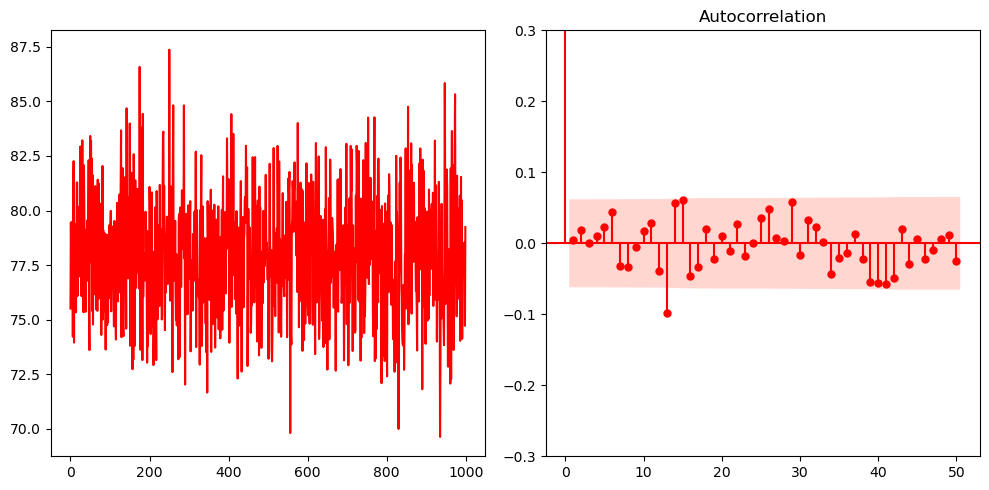

In [110]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(sigma2_3, color = 'r')
plot_acf(sigma2_3, lags = 50, ax = ax[1], color='r', vlines_kwargs={"colors": 'r'})
ax[1].set_ylim([-0.3, 0.3])
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('tomato')
fig.tight_layout()

In [31]:
def posterior_with_covariates_batch_from_zero(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size):
    
    n = np.shape(X)[0] #number of observations
    p = np.shape(X)[1]-1 #number of covariates, without the intercept
    eta0 = p + 2
    m = len(unique_sid)
    L0_inv = np.linalg.inv(L0)
    S0 = L0
    S0_inv = L0_inv
    a = (v0+n)/2

    #initial values
    theta = np.zeros((p+1,1))
    Sigma = np.eye(p+1)
    sigma2 = sigma2_0
#     betas = np.random.multivariate_normal(mean = theta, cov = Sigma).reshape((p+1), 1)
    
    #BurnIn
    Beta = np.zeros((m, p+1))
    for i in range(burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = (1/np.random.gamma(shape = a, scale = b, size = 1))
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
    
    #Actual iterations
    Beta = np.zeros((m, p+1))
    Beta_store = np.zeros((it_after_burnin//batch_size, m, p+1))
    theta_store = np.zeros((it_after_burnin//batch_size, p+1))
    Sigma_store = np.zeros((it_after_burnin//batch_size, p+1, p+1))
    sigma2_store = np.zeros((it_after_burnin//batch_size))
    for i in range(it_after_burnin):
        #Update beta1, beta2, ..., betam and sigma
        SSR = 0
        for j, sch_id in enumerate(unique_sid):
            X_j = np.array(s2[s2['sch_id'] == sch_id][['stu_ses', 'sch_freelunch']])
            y_j = np.array(s2[s2['sch_id'] == sch_id]['stu_mathscore'])
            n_j = y_j.shape[0]
            y_j = y_j.reshape((n_j, 1))
            X_j = np.hstack((np.ones((n_j,1)), X_j.reshape((n_j, p))))
            Var_Bj = np.linalg.inv(np.linalg.inv(Sigma) + (np.dot(X_j.T, X_j))/sigma2)
            E_Bj = np.dot(Var_Bj, np.dot(np.linalg.inv(Sigma), theta) + (np.dot(X_j.T, y_j))/sigma2).reshape((p+1,))
            Beta[j] = np.random.multivariate_normal(mean = E_Bj, cov = Var_Bj)  
            SSR += np.dot((y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))).T, (y_j - np.dot(X_j, Beta[j].reshape((p+1,1)))))
        b = 1/((v0*sigma2_0 + SSR.reshape((1,)))/2)
        sigma2 = 1/np.random.gamma(shape = a, scale = b, size = 1)
        #Update theta
        L_n = np.linalg.inv(np.linalg.inv(L0) + m*np.linalg.inv(Sigma))
        beta_bar = Beta.mean(axis = 0).reshape((p+1,1))
        mu_n = np.dot(L_n, np.dot(np.linalg.inv(L0), mu0) + m*np.dot(np.linalg.inv(Sigma), beta_bar)).reshape((p+1,))
        theta = np.random.multivariate_normal(mean = mu_n, cov = L_n).reshape((p+1, 1))
        #Update Sigma
        S_theta = np.zeros((p+1, p+1))
        for j in range(m):
            S_theta += np.dot((Beta[j].reshape((p+1,1)) - theta), (Beta[j].reshape((p+1,1)) - theta).T)
        Sigma = invwishart.rvs(eta0 + m, S0 + S_theta)
        
        #save the data
        if i%batch_size == 0:
            for j in range (m):
                Beta_store[i//batch_size,j] = Beta[j]
            sigma2_store[i//batch_size] = sigma2
            theta_store[i//batch_size] = theta.reshape((3,))
            Sigma_store[i//batch_size] = Sigma
        
    
    return Beta_store, sigma2_store, theta_store, Sigma_store   

In [32]:
L0 = 300*sigma2_0*np.linalg.inv(np.dot(X.T, X))
v0 = 1
burnin = 10000
it_after_burnin = 10000
batch_size = 10
Beta_4, sigma2_4, theta_4, Sigma_4 = posterior_with_covariates_batch_from_zero(Y, X, s2, L0, unique_sid, mu0, v0, sigma2_0, burnin, it_after_burnin, batch_size)

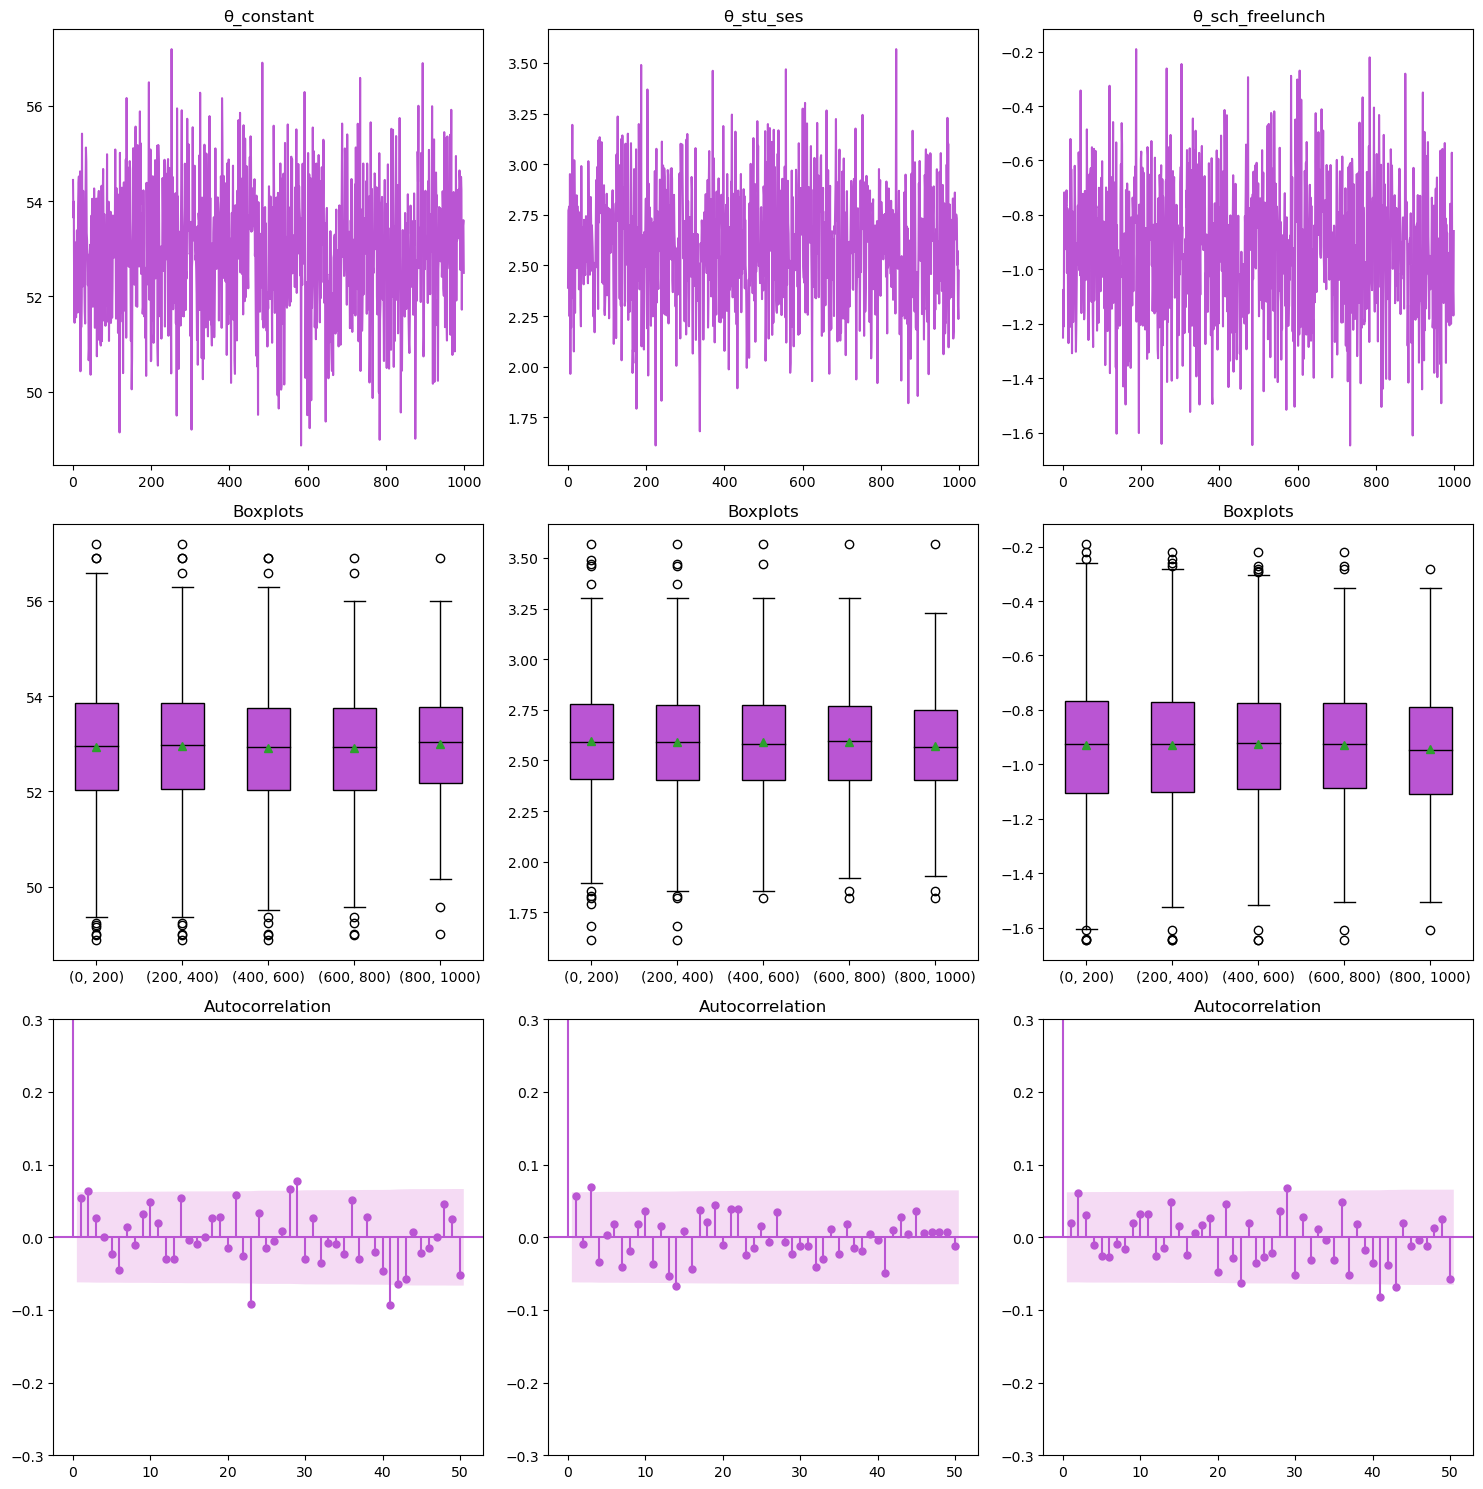

In [168]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(theta_4[:,0], 'mediumorchid')
ax[0,1].plot(theta_4[:,1], 'mediumorchid')
ax[0,2].plot(theta_4[:,2], 'mediumorchid')
ax[0,0].title.set_text('θ_constant')
ax[0,1].title.set_text('θ_stu_ses')
ax[0,2].title.set_text('θ_sch_freelunch')
ax[1,0].boxplot(np.array([theta_4[k:, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([theta_4[k:, 1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([theta_4[k:, 2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black"))
plot_acf(theta_4[:,0], lags = 50, ax = ax[2,0], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(theta_4[:,1], lags = 50, ax = ax[2,1], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(theta_4[:,2], lags = 50, ax = ax[2,2], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
fig.tight_layout()
fig.savefig('TPACB-Theta4.pdf')

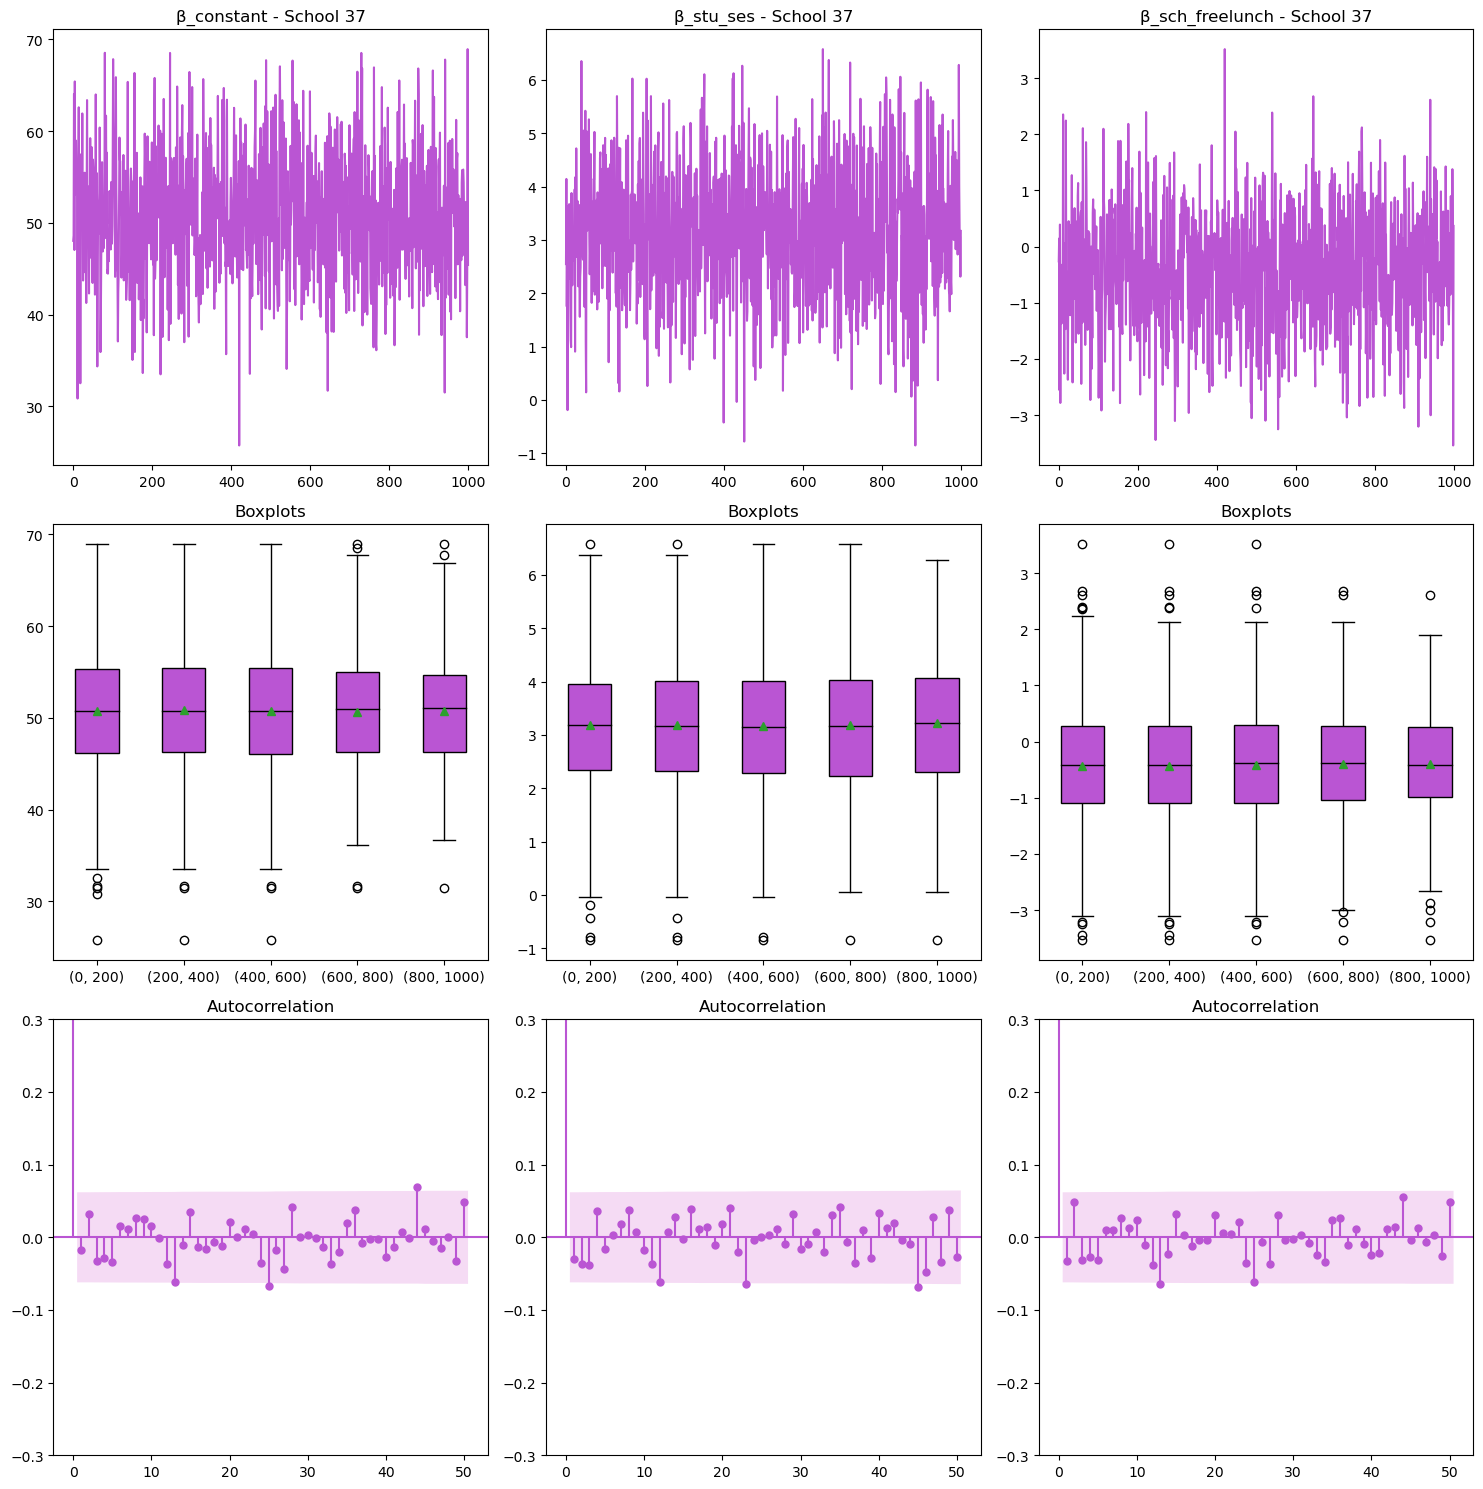

In [458]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_4[:,36, 0], 'mediumorchid')
ax[0,1].plot(Beta_4[:,36, 1], 'mediumorchid')
ax[0,2].plot(Beta_4[:,36, 2], 'mediumorchid')
ax[0,0].title.set_text('β_constant - School 37')
ax[0,1].title.set_text('β_stu_ses - School 37')
ax[0,2].title.set_text('β_sch_freelunch - School 37')
ax[1,0].boxplot(np.array([Beta_4[k:, 36, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_4[k:,36,  1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_4[k:,36,  2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black"))
plot_acf(Beta_4[:,36, 0], lags = 50, ax = ax[2,0], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Beta_4[:,36, 1], lags = 50, ax = ax[2,1], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Beta_4[:,36, 2], lags = 50, ax = ax[2,2], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
fig.tight_layout()
fig.savefig('TPACB-Beta4_36.pdf')

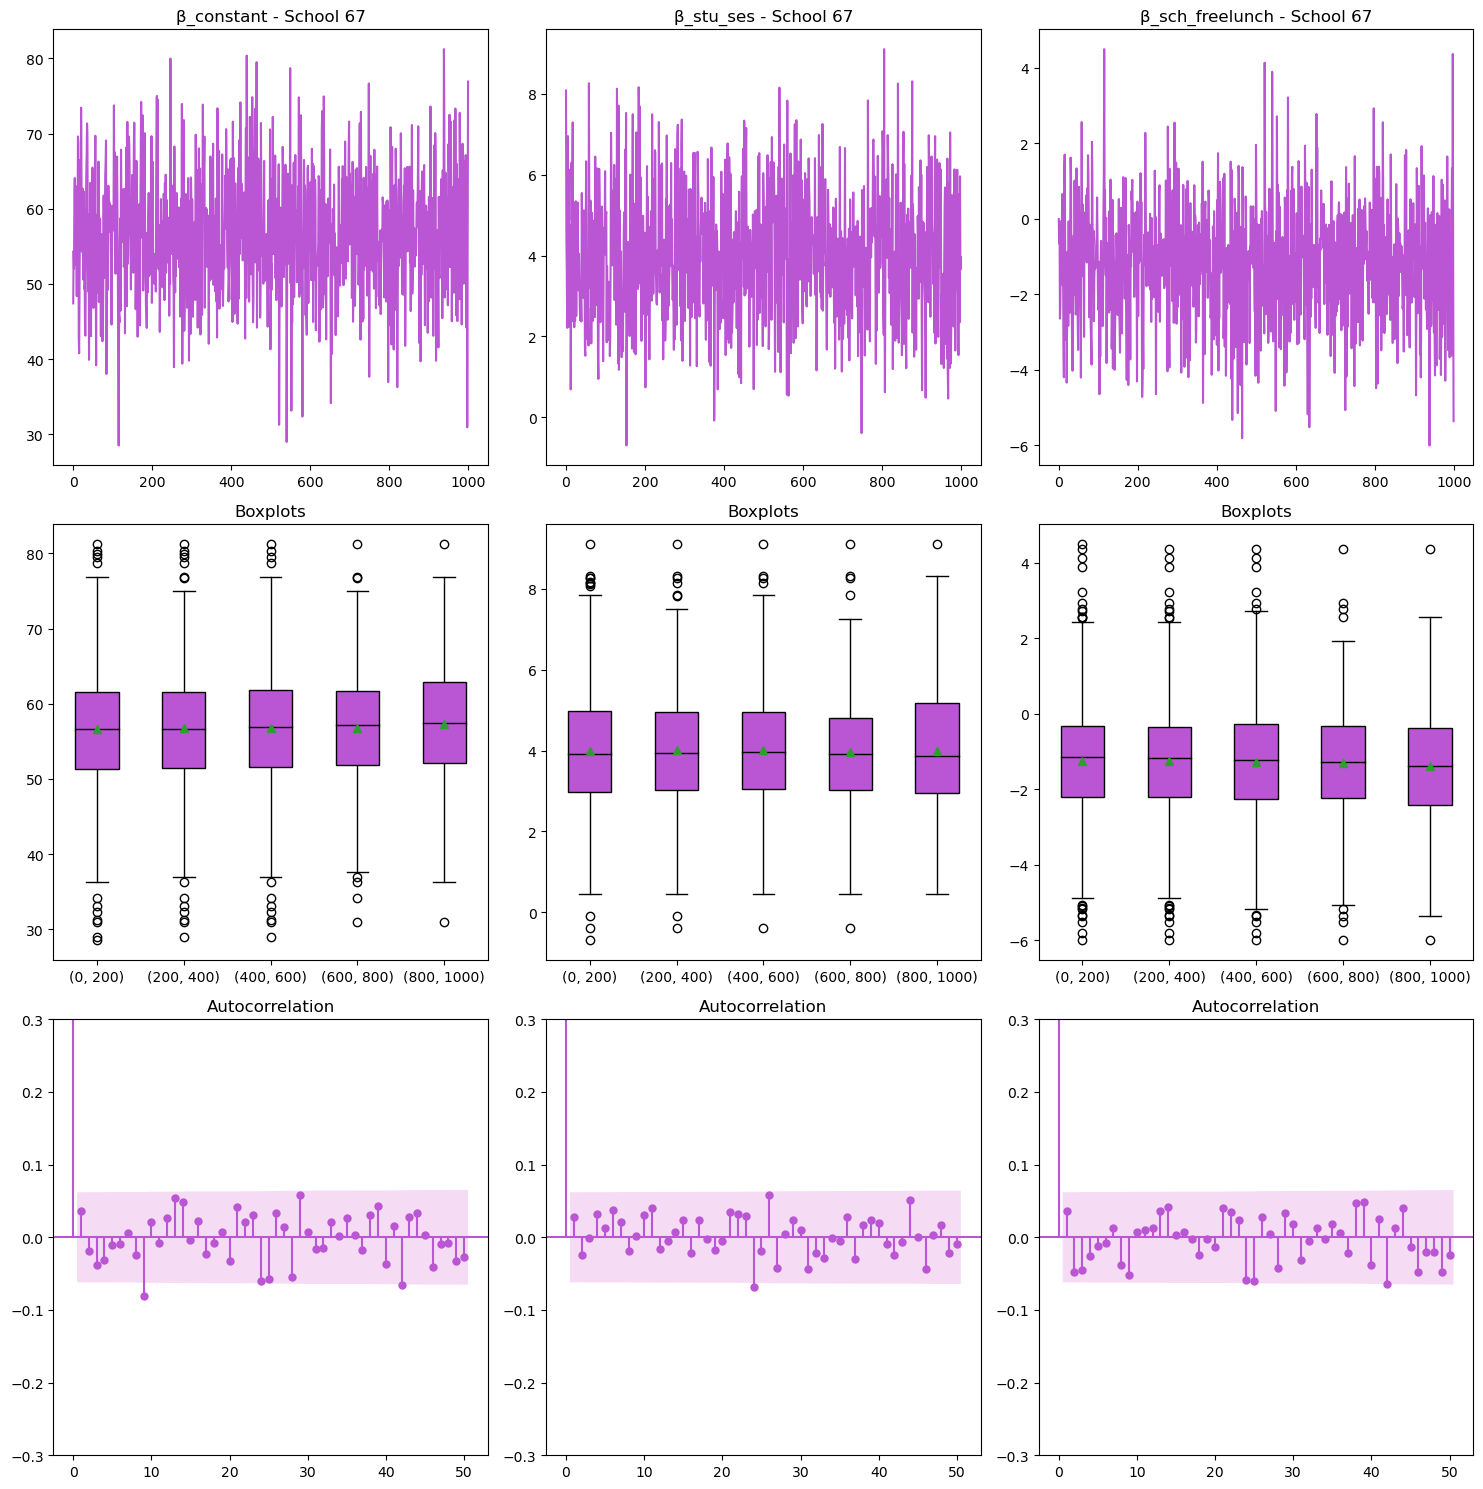

In [459]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Beta_4[:,66, 0], 'mediumorchid')
ax[0,1].plot(Beta_4[:,66, 1], 'mediumorchid')
ax[0,2].plot(Beta_4[:,66, 2], 'mediumorchid')
ax[0,0].title.set_text('β_constant - School 67')
ax[0,1].title.set_text('β_stu_ses - School 67')
ax[0,2].title.set_text('β_sch_freelunch - School 67')
ax[1,0].boxplot(np.array([Beta_4[k:, 66, 0] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([Beta_4[k:,66,  1] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([Beta_4[k:,66,  2] for k in range(0,1000,200)], dtype = list),
                vert=True, labels = [(0,200), (200,400), (400,600), (600,800), (800,1000)],
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black"))
plot_acf(Beta_4[:,66, 0], lags = 50, ax = ax[2,0], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Beta_4[:,66, 1], lags = 50, ax = ax[2,1], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Beta_4[:,66, 2], lags = 50, ax = ax[2,2], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])
ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')
for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
fig.tight_layout()
fig.savefig('TPACB-Beta4_66.pdf')

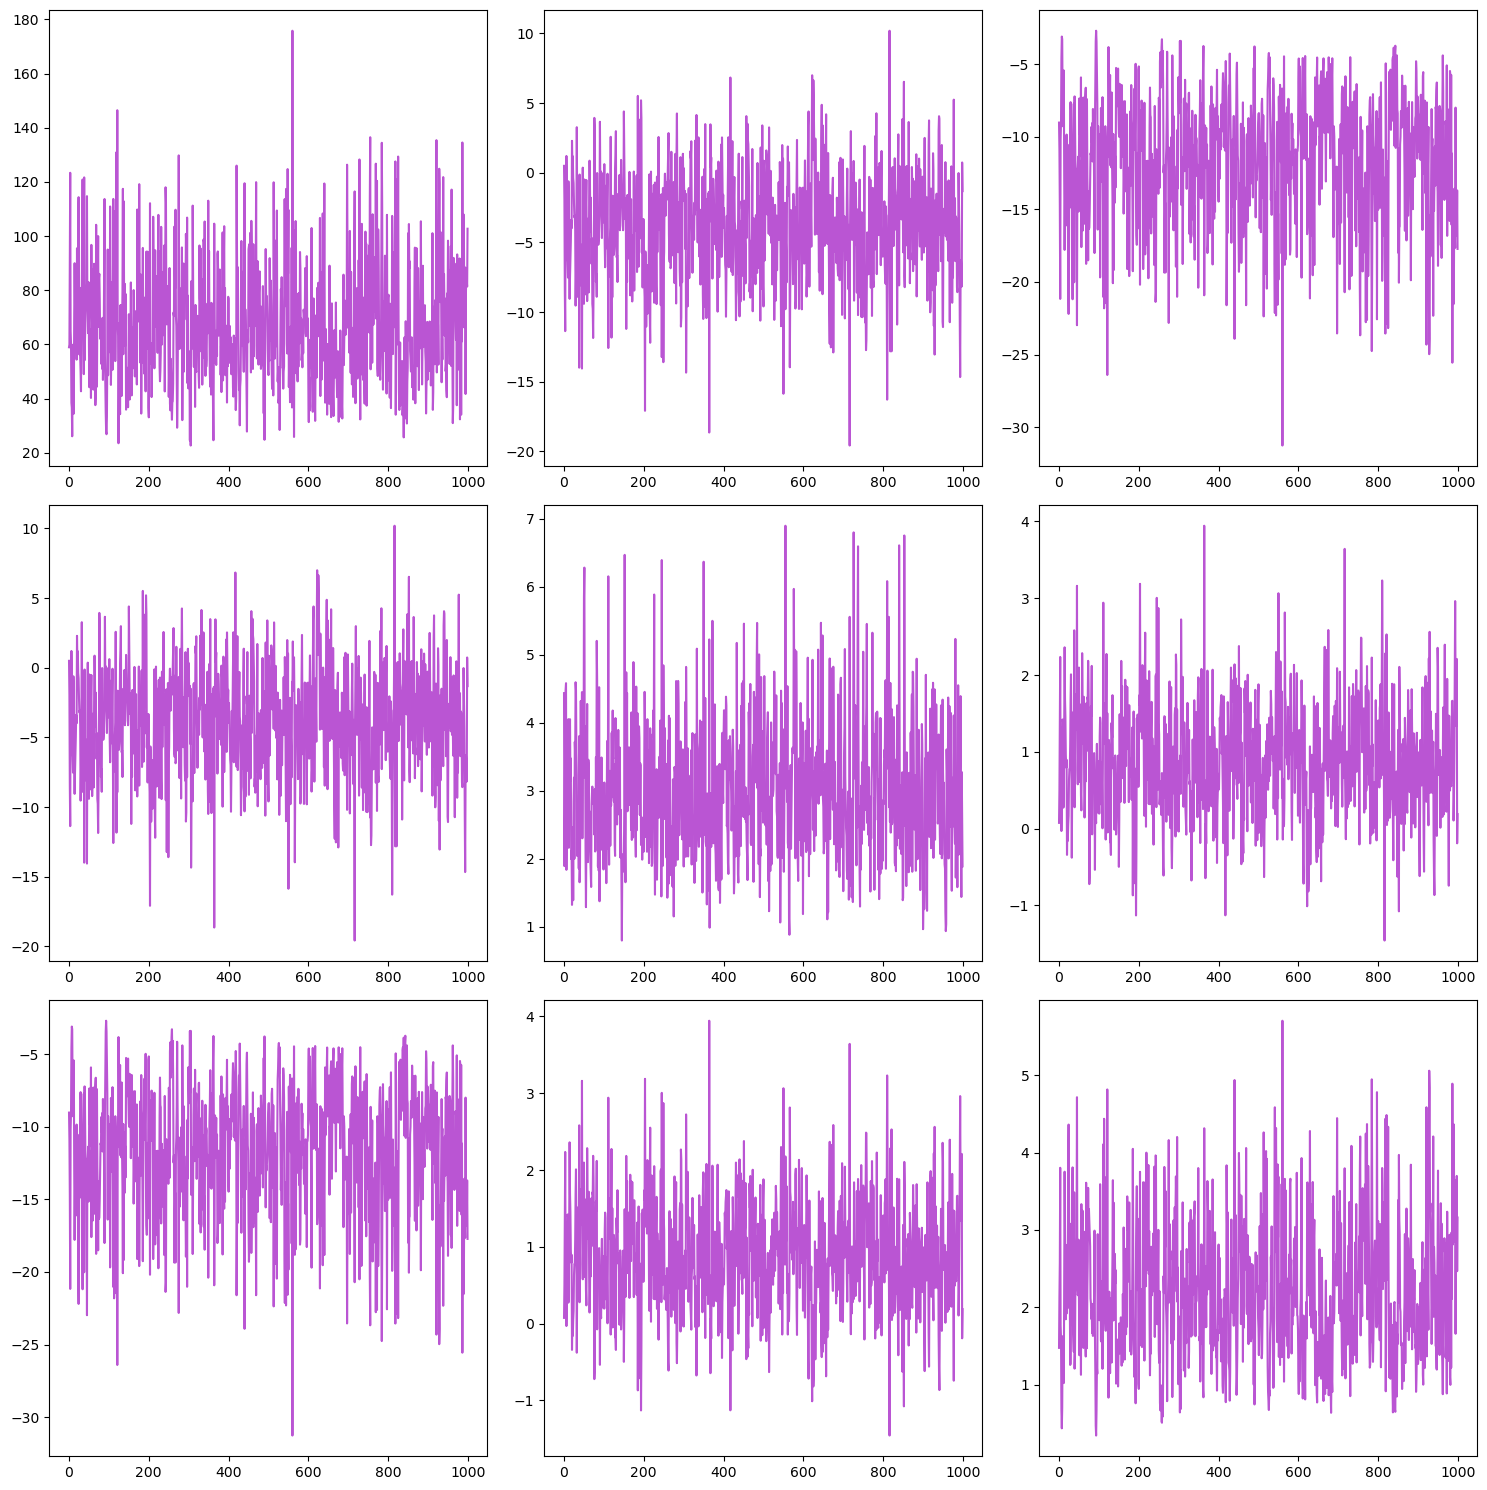

In [124]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
ax[0,0].plot(Sigma_4[:,0,0], color = 'mediumorchid')
ax[0,1].plot(Sigma_4[:,0,1], color = 'mediumorchid')
ax[0,2].plot(Sigma_4[:,0,2], color = 'mediumorchid')
ax[1,0].plot(Sigma_4[:,1,0], color = 'mediumorchid')
ax[1,1].plot(Sigma_4[:,1,1], color = 'mediumorchid')
ax[1,2].plot(Sigma_4[:,1,2], color = 'mediumorchid')
ax[2,0].plot(Sigma_4[:,2,0], color = 'mediumorchid')
ax[2,1].plot(Sigma_4[:,2,1], color = 'mediumorchid')
ax[2,2].plot(Sigma_4[:,2,2], color = 'mediumorchid')
fig.tight_layout()

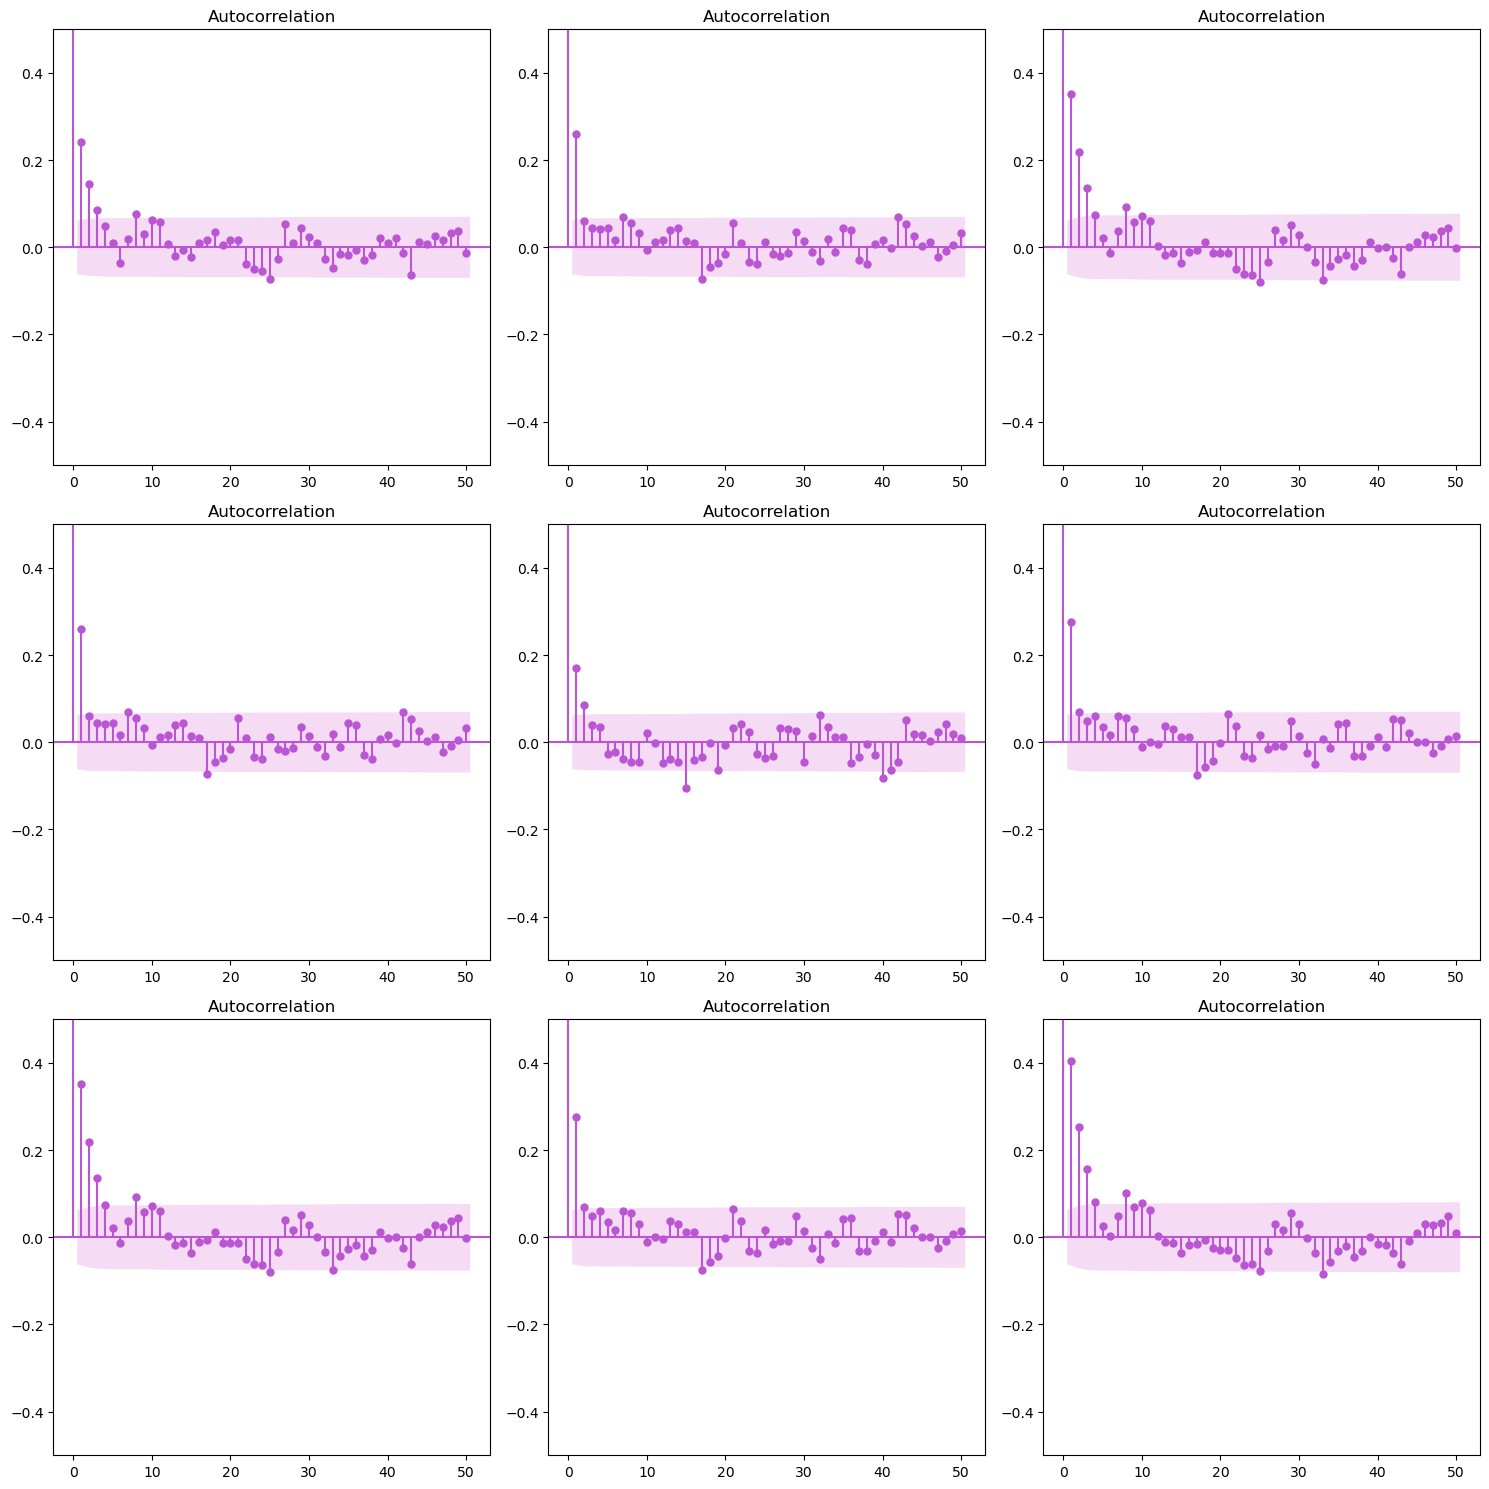

In [125]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
plot_acf(Sigma_4[:,0,0], lags = 50, ax = ax[0,0], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,0,1], lags = 50, ax = ax[0,1], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,0,2], lags = 50, ax = ax[0,2], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,1,0], lags = 50, ax = ax[1,0], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,1,1], lags = 50, ax = ax[1,1], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,1,2], lags = 50, ax = ax[1,2], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,2,0], lags = 50, ax = ax[2,0], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,2,1], lags = 50, ax = ax[2,1], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
plot_acf(Sigma_4[:,2,2], lags = 50, ax = ax[2,2], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ax[0,0].set_ylim([-0.5, 0.5])
ax[0,1].set_ylim([-0.5, 0.5])
ax[0,2].set_ylim([-0.5, 0.5])
ax[1,0].set_ylim([-0.5, 0.5])
ax[1,1].set_ylim([-0.5, 0.5])
ax[1,2].set_ylim([-0.5, 0.5])
ax[2,0].set_ylim([-0.5, 0.5])
ax[2,1].set_ylim([-0.5, 0.5])
ax[2,2].set_ylim([-0.5, 0.5])
for i in range(3):
    for item in ax[i,0].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orchid')
    for item in ax[i,1].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orchid')
    for item in ax[i,2].collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orchid')
fig.tight_layout()

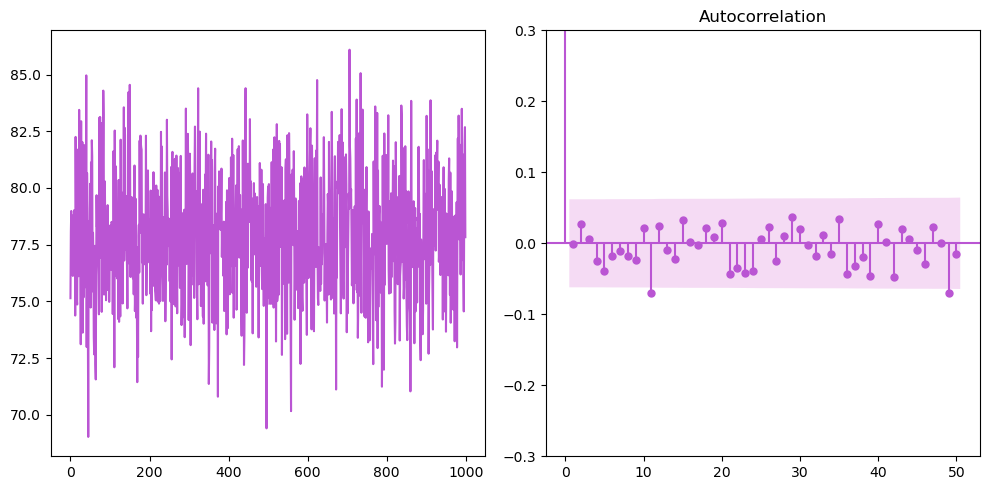

In [127]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(sigma2_4, color = 'mediumorchid')
plot_acf(sigma2_4, lags = 50, ax = ax[1], color='mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ax[1].set_ylim([-0.3, 0.3])
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orchid')
fig.tight_layout()

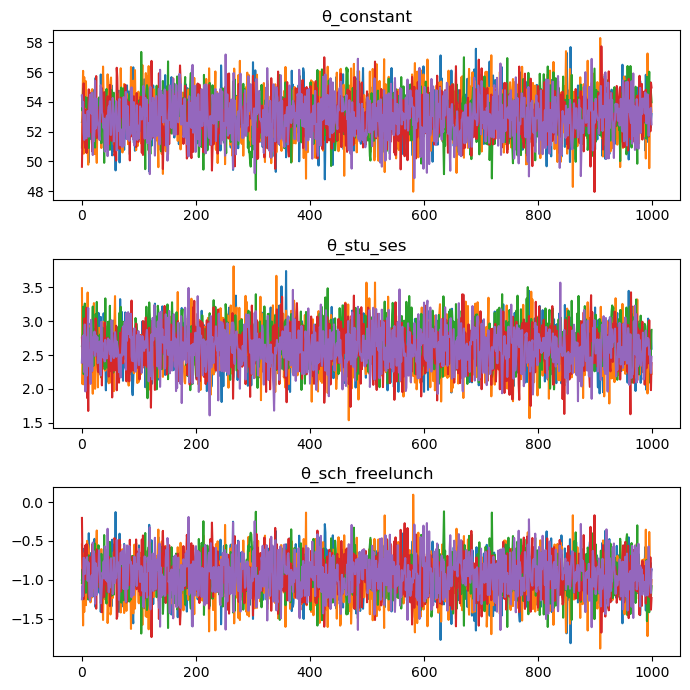

In [245]:
fig, ax = plt.subplots(3,1, figsize = (7,7))
ax[0].plot(theta[:,0])
ax[0].plot(theta_1[:,0])
ax[0].plot(theta_2[:,0])
ax[0].plot(theta_3[:,0])
ax[0].plot(theta_4[:,0])
ax[1].plot(theta[:,1])
ax[1].plot(theta_1[:,1])
ax[1].plot(theta_2[:,1])
ax[1].plot(theta_3[:,1])
ax[1].plot(theta_4[:,1])
ax[2].plot(theta[:,2])
ax[2].plot(theta_1[:,2])
ax[2].plot(theta_2[:,2])
ax[2].plot(theta_3[:,2])
ax[2].plot(theta_4[:,2])
ax[0].title.set_text('θ_constant')
ax[1].title.set_text('θ_stu_ses')
ax[2].title.set_text('θ_sch_freelunch')
fig.tight_layout()
fig.savefig('Comp_1Theta.pdf')

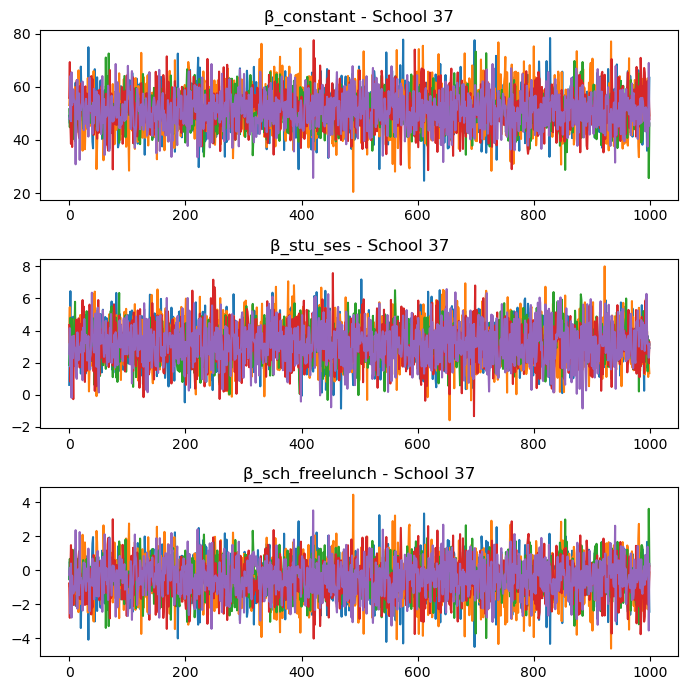

In [460]:
fig, ax = plt.subplots(3,1, figsize = (7, 7))
ax[0].plot(Beta[:,36,0])
ax[0].plot(Beta_1[:,36, 0])
ax[0].plot(Beta_2[:,36, 0])
ax[0].plot(Beta_3[:,36, 0])
ax[0].plot(Beta_4[:,36, 0])
ax[1].plot(Beta[:,36,1])
ax[1].plot(Beta_1[:,36, 1])
ax[1].plot(Beta_2[:,36, 1])
ax[1].plot(Beta_3[:,36, 1])
ax[1].plot(Beta_4[:,36, 1])
ax[2].plot(Beta[:,36,2])
ax[2].plot(Beta_1[:,36, 2])
ax[2].plot(Beta_2[:,36, 2])
ax[2].plot(Beta_3[:,36, 2])
ax[2].plot(Beta_4[:,36, 2])
ax[0].title.set_text('β_constant - School 37')
ax[1].title.set_text('β_stu_ses - School 37')
ax[2].title.set_text('β_sch_freelunch - School 37')
fig.tight_layout()
fig.savefig('Comp_1Beta36.pdf')

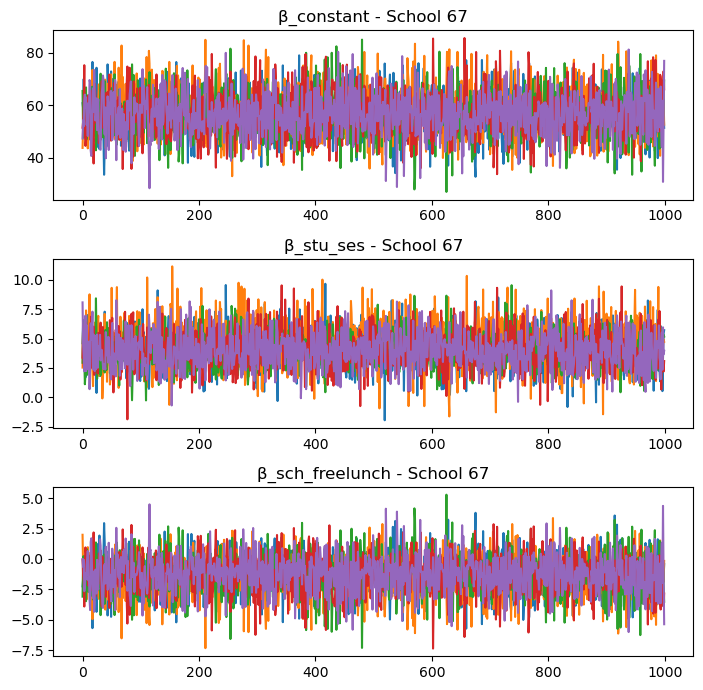

In [461]:
fig, ax = plt.subplots(3,1, figsize = (7, 7))
ax[0].plot(Beta[:,66,0])
ax[0].plot(Beta_1[:,66, 0])
ax[0].plot(Beta_2[:,66, 0])
ax[0].plot(Beta_3[:,66, 0])
ax[0].plot(Beta_4[:,66, 0])
ax[1].plot(Beta[:,66,1])
ax[1].plot(Beta_1[:,66, 1])
ax[1].plot(Beta_2[:,66, 1])
ax[1].plot(Beta_3[:,66, 1])
ax[1].plot(Beta_4[:,66, 1])
ax[2].plot(Beta[:,66,2])
ax[2].plot(Beta_1[:,66, 2])
ax[2].plot(Beta_2[:,66, 2])
ax[2].plot(Beta_3[:,66, 2])
ax[2].plot(Beta_4[:,66, 2])
ax[0].title.set_text('β_constant - School 67')
ax[1].title.set_text('β_stu_ses - School 67')
ax[2].title.set_text('β_sch_freelunch - School 67')
fig.tight_layout()
fig.savefig('Comp_1Beta66.pdf')

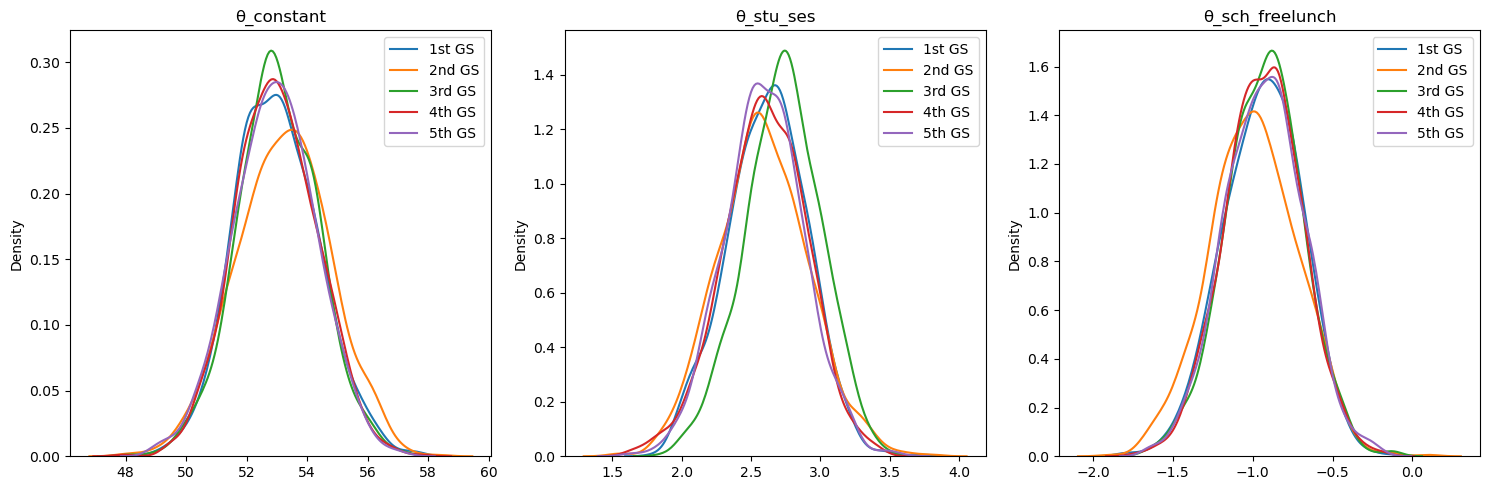

In [251]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(theta[:,0], ax = ax[0], label = '1st GS')
sns.kdeplot(theta_1[:,0], ax = ax[0], label = '2nd GS')
sns.kdeplot(theta_2[:,0], ax = ax[0], label = '3rd GS')
sns.kdeplot(theta_3[:,0], ax = ax[0], label = '4th GS')
sns.kdeplot(theta_4[:,0], ax = ax[0], label = '5th GS')
ax[0].legend()
ax[0].title.set_text('θ_constant')
ax[1].title.set_text('θ_stu_ses')
ax[2].title.set_text('θ_sch_freelunch')
sns.kdeplot(theta[:,1], ax = ax[1], label = '1st GS')
sns.kdeplot(theta_1[:,1], ax = ax[1], label = '2nd GS')
sns.kdeplot(theta_2[:,1], ax = ax[1], label = '3rd GS')
sns.kdeplot(theta_3[:,1], ax = ax[1], label = '4th GS')
sns.kdeplot(theta_4[:,1], ax = ax[1], label = '5th GS')
ax[1].legend()
sns.kdeplot(theta[:,2], ax = ax[2], label = '1st GS')
sns.kdeplot(theta_1[:,2], ax = ax[2], label = '2nd GS')
sns.kdeplot(theta_2[:,2], ax = ax[2], label = '3rd GS')
sns.kdeplot(theta_3[:,2], ax = ax[2], label = '4th GS')
sns.kdeplot(theta_4[:,2], ax = ax[2], label = '5th GS')
ax[2].legend()
fig.tight_layout()
fig.savefig('Comp2-Theta.pdf')

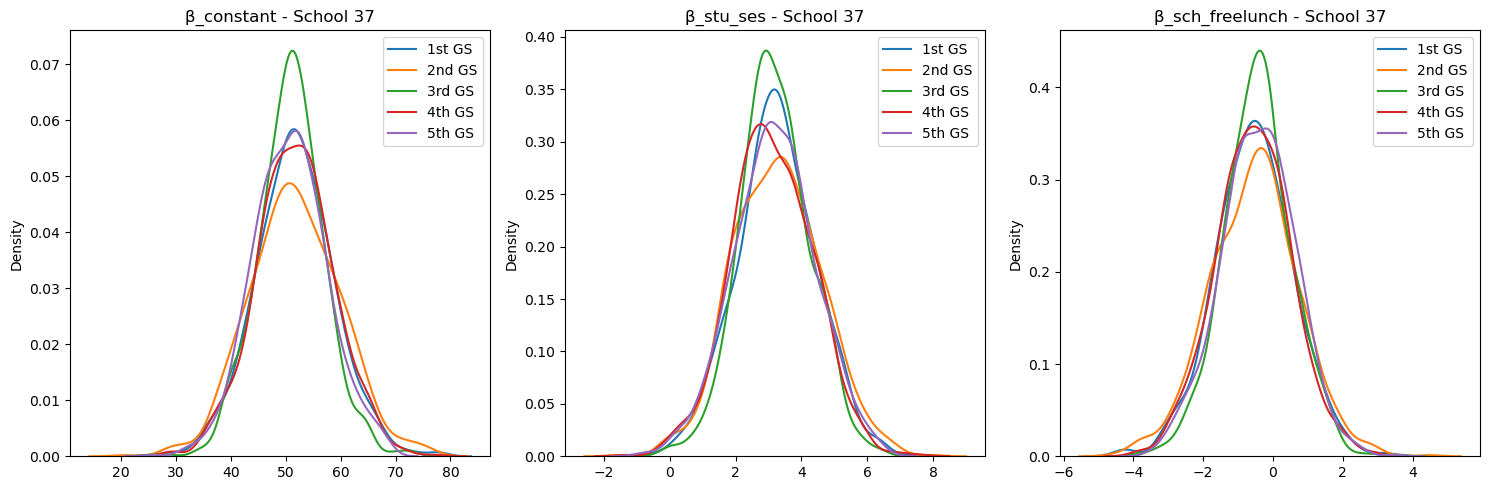

In [462]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(Beta[:,36,0], ax = ax[0], label = '1st GS')
sns.kdeplot(Beta_1[:,36,0], ax = ax[0], label = '2nd GS')
sns.kdeplot(Beta_2[:,36,0], ax = ax[0], label = '3rd GS')
sns.kdeplot(Beta_3[:,36,0], ax = ax[0], label = '4th GS')
sns.kdeplot(Beta_4[:,36,0], ax = ax[0], label = '5th GS')
sns.kdeplot(Beta[:,36,1], ax = ax[1], label = '1st GS')
sns.kdeplot(Beta_1[:,36,1], ax = ax[1], label = '2nd GS')
sns.kdeplot(Beta_2[:,36,1], ax = ax[1], label = '3rd GS')
sns.kdeplot(Beta_3[:,36,1], ax = ax[1], label = '4th GS')
sns.kdeplot(Beta_4[:,36,1], ax = ax[1], label = '5th GS')
sns.kdeplot(Beta[:,36,2], ax = ax[2], label = '1st GS')
sns.kdeplot(Beta_1[:,36,2], ax = ax[2], label = '2nd GS')
sns.kdeplot(Beta_2[:,36,2], ax = ax[2], label = '3rd GS')
sns.kdeplot(Beta_3[:,36,2], ax = ax[2], label = '4th GS')
sns.kdeplot(Beta_4[:,36,2], ax = ax[2], label = '5th GS')
ax[0].title.set_text('β_constant - School 37')
ax[1].title.set_text('β_stu_ses - School 37')
ax[2].title.set_text('β_sch_freelunch - School 37')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.tight_layout()
fig.savefig('Comp2-Beta36.pdf')

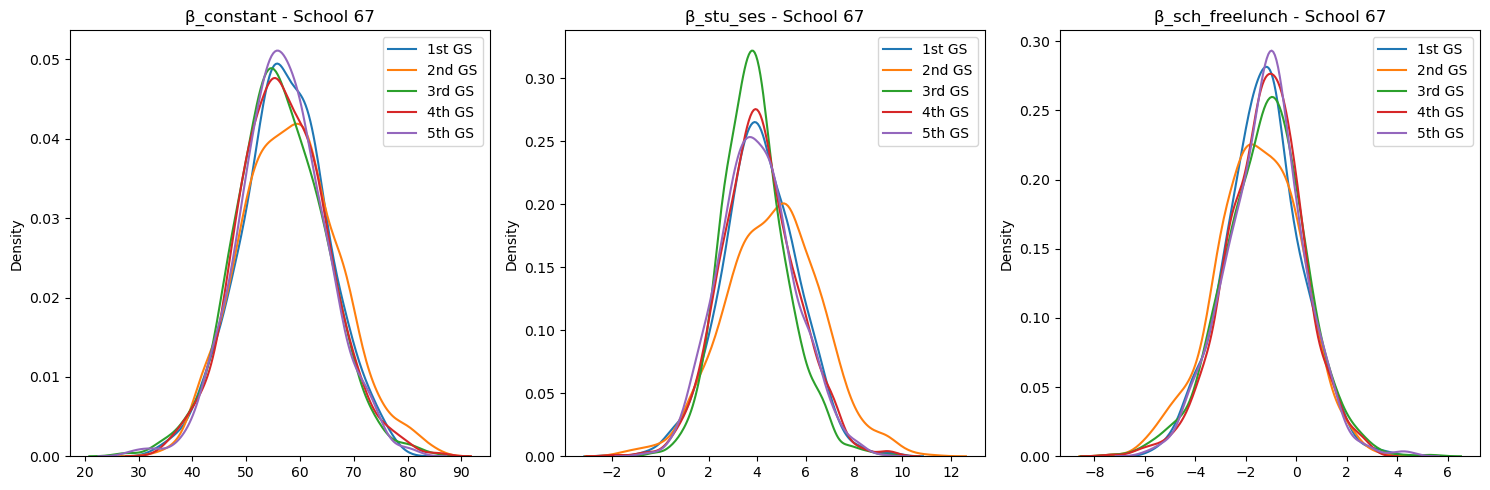

In [463]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(Beta[:,66,0], ax = ax[0], label = '1st GS')
sns.kdeplot(Beta_1[:,66,0], ax = ax[0], label = '2nd GS')
sns.kdeplot(Beta_2[:,66,0], ax = ax[0], label = '3rd GS')
sns.kdeplot(Beta_3[:,66,0], ax = ax[0], label = '4th GS')
sns.kdeplot(Beta_4[:,66,0], ax = ax[0], label = '5th GS')
sns.kdeplot(Beta[:,66,1], ax = ax[1], label = '1st GS')
sns.kdeplot(Beta_1[:,66,1], ax = ax[1], label = '2nd GS')
sns.kdeplot(Beta_2[:,66,1], ax = ax[1], label = '3rd GS')
sns.kdeplot(Beta_3[:,66,1], ax = ax[1], label = '4th GS')
sns.kdeplot(Beta_4[:,66,1], ax = ax[1], label = '5th GS')
sns.kdeplot(Beta[:,66,2], ax = ax[2], label = '1st GS')
sns.kdeplot(Beta_1[:,66,2], ax = ax[2], label = '2nd GS')
sns.kdeplot(Beta_2[:,66,2], ax = ax[2], label = '3rd GS')
sns.kdeplot(Beta_3[:,66,2], ax = ax[2], label = '4th GS')
sns.kdeplot(Beta_4[:,66,2], ax = ax[2], label = '5th GS')
ax[0].title.set_text('β_constant - School 67')
ax[1].title.set_text('β_stu_ses - School 67')
ax[2].title.set_text('β_sch_freelunch - School 67')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.tight_layout()
fig.savefig('Comp2-Beta66.pdf')

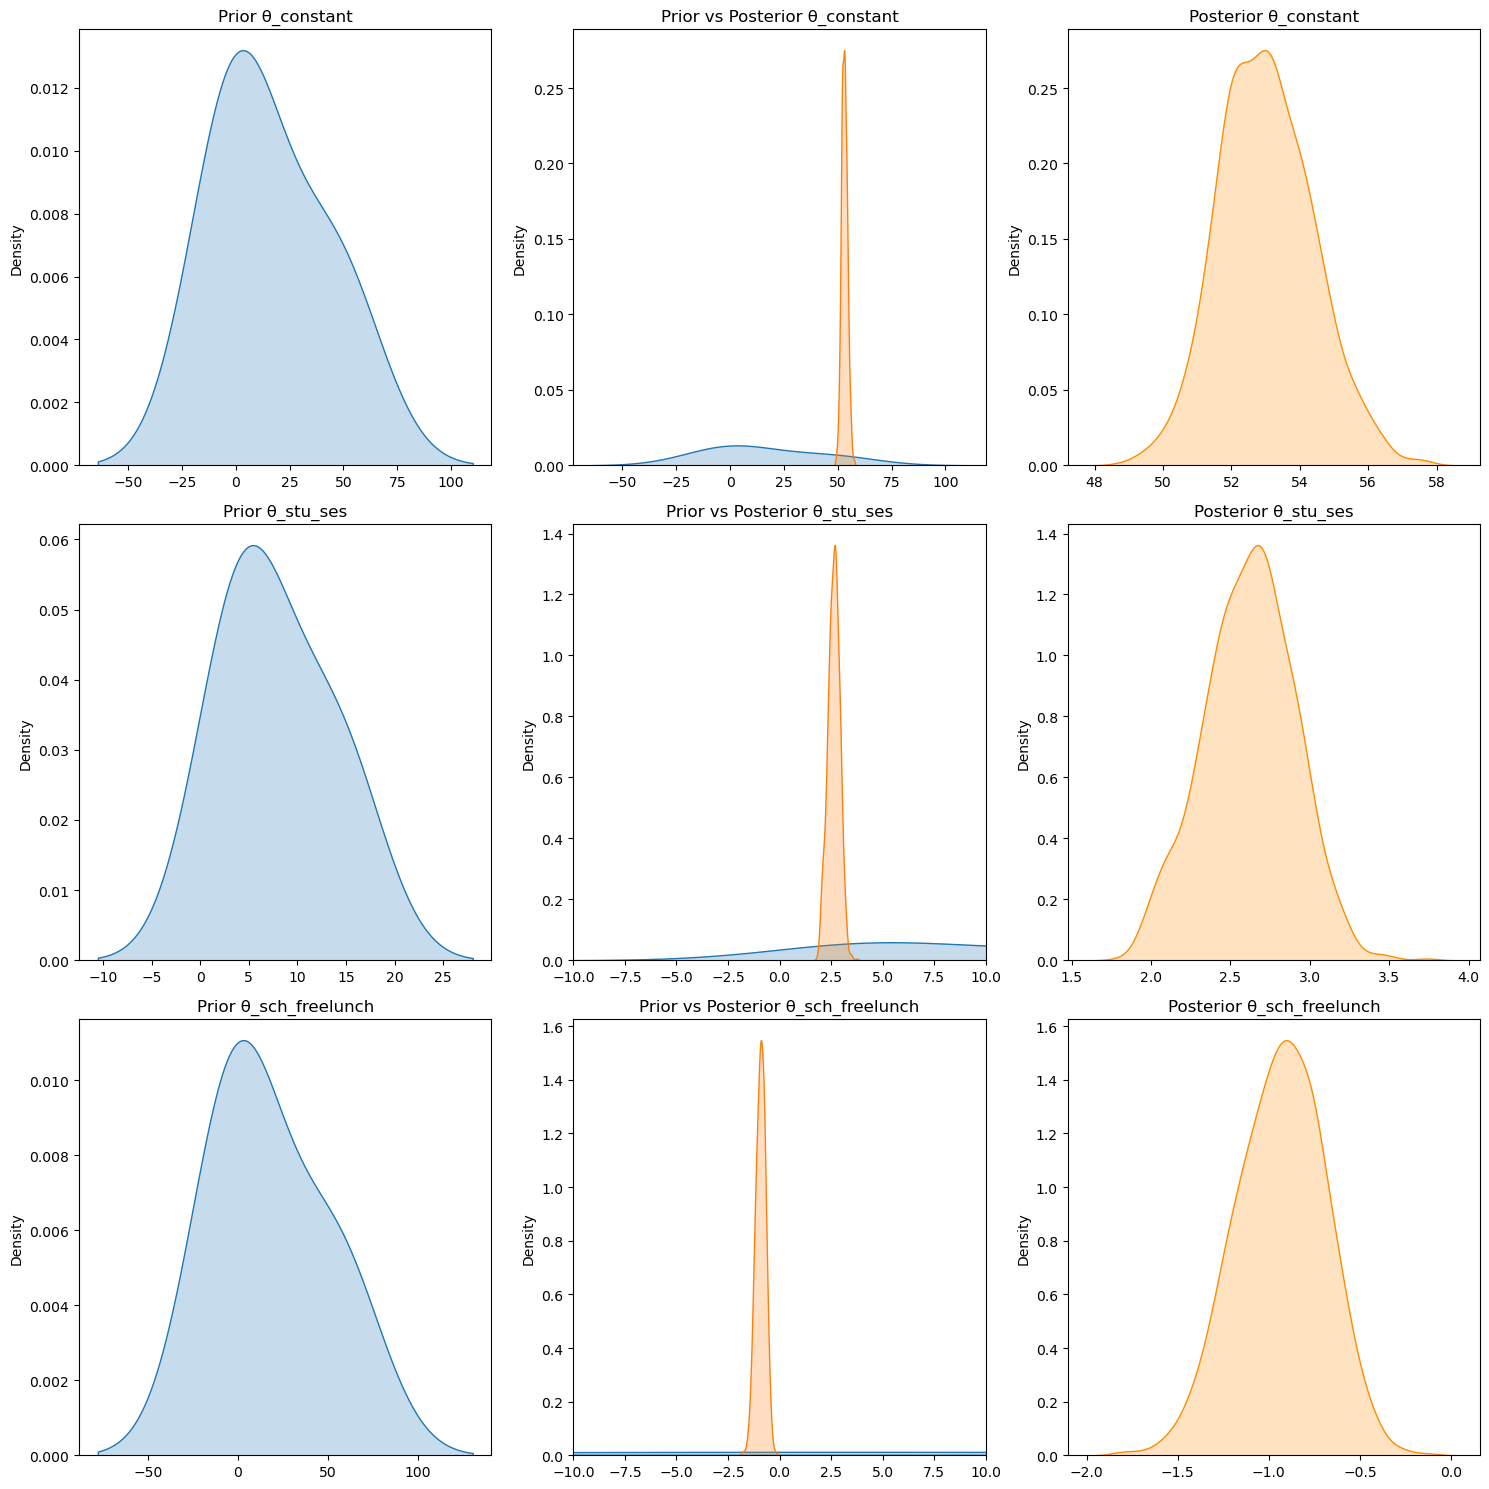

In [301]:
theta_prior = np.random.multivariate_normal(mu0.reshape(3,), L0, size = 1000)
fig, ax = plt.subplots(3,3, figsize = (15,15))
ax[0,0].set_title('Prior θ_constant')
ax[0,1].set_title('Prior vs Posterior θ_constant')
ax[0,2].set_title('Posterior θ_constant')
sns.kdeplot(theta_prior[0], fill = True, ax = ax[0, 0])
sns.kdeplot(theta_prior[0], fill = True, ax = ax[0, 1])
sns.kdeplot(theta[:,0], fill = True, ax = ax[0, 1])
sns.kdeplot(theta[:,0], fill = True, ax = ax[0, 2], color = 'darkorange')
ax[1,1].set_xlim(-50,50)
sns.kdeplot(theta_prior[1], fill = True, ax = ax[1, 0])
sns.kdeplot(theta_prior[1], fill = True, ax = ax[1, 1])
sns.kdeplot(theta[:,1], fill = True, ax = ax[1, 1])
sns.kdeplot(theta[:,1], fill = True, ax = ax[1, 2], color = 'darkorange')
ax[1,1].set_xlim(-10,10)
sns.kdeplot(theta_prior[2], fill = True, ax = ax[2, 0])
sns.kdeplot(theta_prior[2], fill = True, ax = ax[2, 1])
sns.kdeplot(theta[:,2], fill = True, ax = ax[2, 1])
sns.kdeplot(theta[:,2], fill = True, ax = ax[2, 2], color = 'darkorange')
ax[2,1].set_xlim(-10,10)
fig.tight_layout()
ax[1,0].set_title('Prior θ_stu_ses')
ax[1,1].set_title('Prior vs Posterior θ_stu_ses')
ax[1,2].set_title('Posterior θ_stu_ses')
ax[2,0].set_title('Prior θ_sch_freelunch')
ax[2,1].set_title('Prior vs Posterior θ_sch_freelunch')
ax[2,2].set_title('Posterior θ_sch_freelunch')
fig.tight_layout()
fig.savefig('Prior_Posterior_theta.pdf')

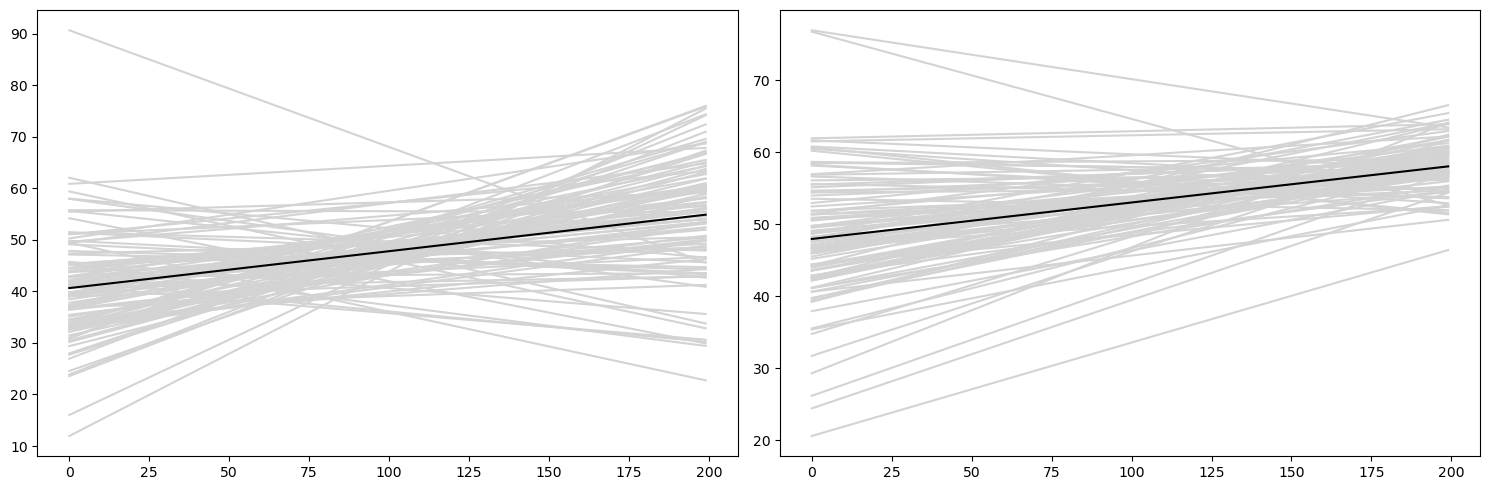

In [384]:
x1 = np.linspace(start = -3,stop = 3, num = 200)
x2 = np.linspace(start = -3,stop = 3, num = 200)
fig, ax = plt.subplots(1,2, figsize = (15,5))
for j in range(m):
    y_j = B_ols[j,0] + B_ols[j,1]*x1 + B_ols[j,2]*x2
    ax[0].plot(y_j, color = 'lightgrey')
y_bar_old = mu0[0] + mu0[1]*x1 + mu0[2]*x2
ax[0].plot(y_bar_old, color = 'black')
for j in range(m):
    y_j = (Beta[:,j, 0]).mean() + (Beta[:,j, 1]).mean()*x1 + (Beta[:,j, 2]).mean()*x2
    ax[1].plot(y_j, color = 'lightgrey')
y_bar_new = (theta[:,0]).mean() + (theta[:,1]).mean()*x1 + (theta[:,2]).mean()*x2
ax[1].plot(y_bar_new, color = 'black')
plt.tight_layout()
fig.savefig('Lines.pdf')

In [277]:
mu_n_hat = theta.mean(0)
mu_n_hat

array([53.00314788,  2.61678997, -0.93750012])

In [297]:
#95% confidence interval theta_1
np.quantile(theta[:,1], (0.025, 0.975))

array([2.04724048, 3.15300535])

In [295]:
#95% confidence interval theta_2
np.quantile(theta[:,2], (0.025, 0.975))

array([-1.4240054 , -0.48665093])

In [303]:
#95% confidence interval Beta_1 of school 37
np.quantile(Beta[:,36, 1], (0.025, 0.975))

array([0.88218716, 5.55762549])

In [290]:
#95% confidence interval Beta_2 of school 37
np.quantile(Beta[:,36, 2], (0.025, 0.975))

array([-2.84862816,  1.63611688])

In [291]:
#95% confidence interval Beta_1 of school 67
np.quantile(Beta[:,66, 1], (0.025, 0.975))

array([1.05113614, 7.00886738])

In [292]:
#95% confidence interval Beta_2 of school 67
np.quantile(Beta[:,66, 2], (0.025, 0.975))

array([-4.2629747 ,  1.62281212])

In [449]:
np.argwhere((Beta[:,:,1].mean(axis = 0)) < 0).reshape(2,) + 1

array([44, 79], dtype=int64)

In [321]:
#95% confidence interval Beta_1 of school 44
np.quantile(Beta[:,43, 1], (0.025, 0.975))

array([-3.33440652,  2.51422064])

In [322]:
#95% confidence interval Beta_1 of school 79
np.quantile(Beta[:,78, 1], (0.025, 0.975))

array([-4.38285269,  2.32911881])